# Imports

In [1151]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import datasets, svm, tree, metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas import DataFrame
from pathlib import Path
import collections
import numpy as np
import subprocess
import itertools
import os.path
import random
import time
import json
import sys
import re




# Converts C operators into natural language equivalent
                            (naive approach)

In [1041]:
def naive_word_conversion(code_string):
    
    code_string = re.sub('\>\>=', ' _GREATER_GREATER_EQUAL_ ', code_string)
    code_string = re.sub('\<\<=', ' _LESS_LESS_EQUAL_ ', code_string)
    code_string = re.sub('\<\<', ' _LESS_LESS_ ', code_string)
    code_string = re.sub('\>\>', ' _GREATER_GREATER_ ', code_string)
    code_string = re.sub('\<=', ' _LESS_EQUAL_ ', code_string)
    code_string = re.sub('\>=', ' _GREATER_EQUAL_ ', code_string)
    code_string = re.sub('-\>', ' _ARROW_ ', code_string)
    code_string = re.sub('\<', ' _LESS_ ', code_string)
    code_string = re.sub('\>', ' _GREATER_ ', code_string)
    code_string = re.sub('\+\+', ' _PLUS_PLUS_ ', code_string)
    code_string = re.sub('--', ' _MINUS_MINUS_ ', code_string)
    code_string = re.sub('\+=', ' _PLUS_EQUAL_ ', code_string)
    code_string = re.sub('\-=', ' _MINUS_EQUAL_ ', code_string)
    code_string = re.sub('\*=', ' _STAR_EQUAL_ ', code_string)
    code_string = re.sub('\/=', ' _DIVIDE_EQUAL_ ', code_string)
    code_string = re.sub('\%=', ' _PERCENT_EQUAL_ ', code_string)
    code_string = re.sub('&=', ' _AND_EQUAL_ ', code_string)
    code_string = re.sub('\|=', ' _OR_EQUAL_ ', code_string)
    code_string = re.sub('\^=', ' _CARROT_EQUAL_ ', code_string)
    code_string = re.sub('==', ' _EQUAL_EQUAL_ ', code_string)
    code_string = re.sub('\!=', ' _BANG_EQUAL_ ', code_string)
    code_string = re.sub('&&', ' _AND_AND_ ', code_string)
    code_string = re.sub('\|\|', ' _OR_OR_ ', code_string)
    code_string = re.sub('\?\:', ' _QUESTION_COLON_ ', code_string)
    code_string = re.sub('&&', ' _AND_AND_ ', code_string)
    code_string = re.sub('\/\/', ' _DIVIDE_DIVIDE_ ', code_string)
    code_string = re.sub('=', ' _EQUAL_ ', code_string)
    code_string = re.sub('\.', ' _DOT_ ', code_string)
    code_string = re.sub(' -{1} ', ' _MINUS_ ', code_string)
    code_string = re.sub('\+{1}', ' _PLUS_ ', code_string)
    code_string = re.sub('\*{1}', ' _STAR_ ', code_string)
    code_string = re.sub('&{1}', ' _AND_ ', code_string)
    code_string = re.sub('\/{1}', ' _DIVIDE_ ', code_string)
    code_string = re.sub('\%{1}', ' _PERCENT_ ', code_string)
    code_string = re.sub('\!{1}', ' _BANG_ ', code_string)
    code_string = re.sub('\|{1}', ' _OR_ ', code_string)
    code_string = re.sub('\^{1}', ' _CARROT_ ', code_string)
    code_string = re.sub('\(', ' _LEFT_PARENS_ ', code_string)
    code_string = re.sub('\)', ' _RIGHT_PARENS_ ', code_string)
    code_string = re.sub('\[', ' _LEFT_BRACKET_ ', code_string)
    code_string = re.sub('\]', ' _RIGHT_BRACKET_ ', code_string)
    code_string = re.sub('\#', ' _POUND_ ', code_string)
    code_string = re.sub(';', ' ; ', code_string)
    
    return code_string

# Load data set into script

In [1042]:
with open('processed_data.json') as data:
    jdata = json.load(data)

# Extract data Naively

In [1043]:
rows = []
index = []
for problem in jdata:
    for submissions in problem['Submissions']:
        for submission in submissions:
            code = submissions[submission]['Code'][0]
            code = naive_word_conversion(code)
            rows.append({'code':code, 'label':str(problem['contestId'])+problem['index']})
            index.append(submission)

naive_data = DataFrame(rows, index=index)
test = rows[198]['code']

# Extract data (Removing comments)

In [1044]:
rows = []
index = []

for problem in jdata:
    for submissions in problem['Submissions']:
        for submission in submissions:
            code = submissions[submission]['Code'][0]
            
            code = re.sub('\/\*.*?\*\/','',code)
            code = re.sub('\/\/.*?\\n','',code)
            code = naive_word_conversion(code)
            
            rows.append({'code':code, 'label':str(problem['contestId'])+problem['index']})
            index.append(submission)

no_comment_data = DataFrame(rows, index=index)



# Extract data (Preparation for parsing for operators only)

In [1045]:
rows = []
index = []

for problem in jdata:
    for submissions in problem['Submissions']:
        for submission in submissions:
            code = submissions[submission]['Code'][0]
            
            code = re.sub('\/\*.*?\*\/','',code)
            code = re.sub('\/\/.*?\\n','',code)
            
            rows.append({'code':code, 'label':str(problem['contestId'])+problem['index']})
            index.append(submission)

op_data = DataFrame(rows, index=index)

In [1046]:
parse_string = '\>\>=|\<\<=|\<\<|\>\>|\<=|\>=|-\>|\<|\>|\+\+|--|\+=|\-=|\*=|\/=|\%=|&='
parse_string = parse_string + '|\|=|\^=|==|\!=|&&|\|\||\?\:|&&|\/\/|=|\.|-0x[A-F,0-9]+|0x[A-F,0-9]+'
parse_string = parse_string + '|-0b[0-1]+|0b[0-1]+|-[0-9]+E.[0-9]+|-[0-9]+|[0-9]+E.[0-9]+|[0-9]+'
parse_string = parse_string + '|-|\+|\*|&|\/|\%|\!|\||\^|\(|\)|\[|\]|\#|;|\{|\}|auto|break|case'
parse_string = parse_string + '|char|const|continue|default|do|double|eles|enum|extern|float|for'
parse_string = parse_string + '|goto|if|int|long|register|return|short|signed|sizeof|static|struct'
parse_string = parse_string + '|switch|typedef|union|unsigned|void|volatile|while'

In [1047]:
ansii_parse = 'assert|isalnum|isalpha|iscntrl|isdigit|isgraph|islower|isprint|ispunct|isspace|isupper'
ansii_parse = ansii_parse + '|isxdigit|toupper|tolower|errno|setlocale|acos|asin|atan|atan2|ceil|cos'
ansii_parse = ansii_parse + '|cosh|exp|fabs|floor|fmod|frexp|ldexp|log|log10|modf|pow|sin|sinh|sqrt'
ansii_parse = ansii_parse + '|tan|tanh|abs|setjmp|longjmp|signal|raise|va_start|va_arg|va_end|clearerr'
ansii_parse = ansii_parse + '|fclose|feof|fflush|fgetc|fgetpos|fgets|fopen|fprintf|fputc|fputs|fread'
ansii_parse = ansii_parse + '|freopen|fscanf|fseek|fsetpos|ftell|fwrite|getc|getchar|gets|perror'
ansii_parse = ansii_parse + '|printf|putchar|puts|remove|rewind|scanf|setbuf|setvbuf|sprintf|sscanf'
ansii_parse = ansii_parse + '|tmpfile|tmpnam|ungetc|vfprintf|vprintf|vsprintf|abort|abs|atexit|atof'
ansii_parse = ansii_parse + '|atoi|atol|bsearch|calloc|div|exit|getenv|free|labs|ldiv|malloc|mblen'
ansii_parse = ansii_parse + '|mbstowcs|mbtowc|qsort|rand|realloc|strtod|strtol|strtoul|srand|system'
ansii_parse = ansii_parse + '|wctomb|wcstombs|memchr|memcmp|memcpy|memmove|memset|strcat|strchr|strcmp'
ansii_parse = ansii_parse + '|strcoll|strcpy|strcspn|strerror|strlen|strncat|strncmp|strncpy|strpbrk'
ansii_parse = ansii_parse + '|strrchr|strspn|strstr|strtok|strxfrm|asctime|clock|ctime|difftime|gmtime'
ansii_parse = ansii_parse + '|localtime|mktime|strftime|time'

In [1048]:
posix_parse = 'opendir|closedir|readdir|rewinddir|scandir|seekdir|telldir|access|alarm|chdir|chown'
posix_parse = posix_parse + '|close|chroot|ctermid|cuserid|dup|dup2|execl|execle|execlp|execv|execve'
posix_parse = posix_parse + '|execvp|fchdir|fork|fpathconf|getegid|geteuid|gethostname|getopt|getgid'
posix_parse = posix_parse + '|getgroups|getlogin|getpgrp|getpid|getppid|getuid|isatty|link|lseek|mkdir'
posix_parse = posix_parse + '|open|pathconf|pause|pipe|read|rename|rmdir|setgid|setpgid|setsid|setuid'
posix_parse = posix_parse + '|sleep|sysconf|tcgetpgrp|tcsetpgrp|ttyname|unlink|write|clrscr|getch|getche'
posix_parse = posix_parse + '|endpwent|fgetpwent|getpw|getpwent|getpwnam|getpwuid|getuidx|index|putpwent'
posix_parse = posix_parse + '|pclose|popen|putenv|setenv|setpwent|setreuid|stat|uname|unsetenv|setuidx'
posix_parse = posix_parse + '|setegid|seteuid|getruid'

In [1049]:
op_parse_string = parse_string
ansii_parse_string = parse_string +'|'+ ansii_parse
posix_parse_string = parse_string +'|'+ posix_parse
op_funct_parse_string = parse_string +'|'+ ansii_parse  +'|'+ posix_parse

# Extract data (Convert to llvm IR format)
 work in progress

In [1050]:


#rows = []
#index = []
#lvmrow = []
#for problem in jdata:
    #for submissions in problem['Submissions']:
        #for submission in submissions:
            #code = submissions[submission]['Code'][0]
            
            #fname = submission+'.c'
            #llvmname = submission+'.ll'
            
            #fd = open(fname,'w+')
            #fd.write(code)
            #fd.close()
            
            #time.sleep(.1)
            
            #result = subprocess.run(["clang", "-S", "-emit-llvm", fname],stderr=subprocess.STDOUT)
            #if not result:
                #print("FAILURE")
                
            #time.sleep(.1)
            #fid = Path(llvmname)
            #if(fid.exists()):
                #fd = open(llvmname,'r')
                #llvm = fd.read()
                #lvmrow.append(llvm)
                
            #subprocess.run(["rm",llvmname])
            #subprocess.run(["rm",fname])
            
            
            #rows.append({'code':code,'llvm IR':llvm, 'label':str(problem['contestId'])+problem['index']})
            #index.append(submission)

#llvm_data = DataFrame(rows, index=index)


# Split data set into a validation set, training set and testing set
                                    (Naive approach)

In [1178]:
# Create separate validation data from training and testing data
seed = 56
sub_data, naive_validate_data = train_test_split(naive_data,test_size=0.20, random_state=seed)

#print(sub_data)
#token_pattern='-\d*|\w\w+'
# Create bag of words with all of the data not part of the validation set
naive_vectorizer = CountVectorizer(token_pattern='-\d*|\w\w+')
naive_BoW = naive_vectorizer.fit_transform(sub_data['code'].values)
display(naive_vectorizer.vocabulary_)
targets_naive = sub_data['label'].values

# create traing and testing data
seed = 42
data_train, data_test = train_test_split(sub_data,test_size=0.20, random_state=seed)
x_train_naive = naive_vectorizer.transform(data_train['code'].values)
y_train_naive = data_train['label'].values
x_test_naive = naive_vectorizer.transform(data_test['code'].values)
y_test_naive = data_test['label'].values

{'_pound_': 697,
 'include': 1611,
 '_less_': 679,
 'stdio': 2551,
 '_dot_': 667,
 '_greater_': 671,
 'int': 1645,
 'main': 1857,
 '_left_parens_': 678,
 '_right_parens_': 699,
 'char': 990,
 'ch': 985,
 '_left_bracket_': 677,
 '100': 37,
 '_right_bracket_': 698,
 '_equal_': 668,
 'scanf': 2422,
 '_percent_': 692,
 '_and_': 654,
 'for': 1449,
 '_plus_plus_': 696,
 'if': 1592,
 '_equal_equal_': 669,
 'else': 1324,
 'printf': 2270,
 'math': 1870,
 'diff': 1246,
 'res': 2360,
 'res1': 2361,
 'res2': 2362,
 'abs': 721,
 '-': 0,
 '_divide_': 664,
 '_star_': 703,
 '_plus_': 694,
 'stdlib': 2552,
 '200000': 251,
 'sum': 2590,
 'long': 1834,
 'double': 1282,
 'temp': 2654,
 'return': 2378,
 '_divide_divide_': 665,
 'set': 2451,
 'many': 1862,
 'funcs': 1474,
 'template': 2662,
 'string': 2574,
 'stdbool': 2546,
 'time': 2695,
 'define': 1219,
 'inf': 1626,
 '1072114514': 105,
 'llinf': 1807,
 '4154118101919364364': 408,
 'mod': 1970,
 '1000000007': 49,
 'pi': 2195,
 '1415926535897932384': 170,

                                            Comments were removed

In [1052]:
# Create separate validation data from training and testing data
seed = 56
sub_data, no_comment_validate_data = train_test_split(no_comment_data,test_size=0.20, random_state=seed)
#token_pattern='-\d*|\w\w+'
# Create bag of words with all of the data not part of the validation set
no_comment_vectorizer = CountVectorizer(token_pattern='-\d*|\w\w+')
no_comment_BoW = no_comment_vectorizer.fit_transform(sub_data['code'].values)
display(no_comment_vectorizer.vocabulary_)
targets_no_comment = sub_data['label'].values

# create traing and testing data
seed = 42
data_train, data_test = train_test_split(sub_data,test_size=0.20, random_state=seed)
x_train_no_comment = no_comment_vectorizer.transform(data_train['code'].values)
y_train_no_comment = data_train['label'].values
x_test_no_comment = no_comment_vectorizer.transform(data_test['code'].values)
y_test_no_comment = data_test['label'].values

{'_pound_': 673,
 'include': 1388,
 '_less_': 655,
 'stdio': 2172,
 '_dot_': 644,
 '_greater_': 647,
 'int': 1414,
 'main': 1590,
 '_left_parens_': 654,
 '_right_parens_': 675,
 'char': 911,
 'ch': 906,
 '_left_bracket_': 653,
 '100': 35,
 '_right_bracket_': 674,
 '_equal_': 645,
 'scanf': 2065,
 '_percent_': 668,
 '_and_': 631,
 'for': 1270,
 '_plus_plus_': 672,
 'if': 1375,
 '_equal_equal_': 646,
 'else': 1182,
 'printf': 1933,
 'math': 1599,
 'diff': 1118,
 'res': 2011,
 'res1': 2012,
 'res2': 2013,
 'abs': 696,
 '-': 0,
 '_divide_': 641,
 '_star_': 679,
 '_plus_': 670,
 'stdlib': 2173,
 '200000': 246,
 'sum': 2204,
 'long': 1569,
 'double': 1148,
 'temp': 2259,
 'return': 2027,
 'string': 2192,
 'stdbool': 2169,
 'time': 2287,
 'define': 1100,
 'inf': 1401,
 '1072114514': 103,
 'llinf': 1544,
 '4154118101919364364': 397,
 'mod': 1689,
 '1000000007': 47,
 'pi': 1873,
 '1415926535897932384': 167,
 'max': 1601,
 'min': 1658,
 'zt': 2461,
 'round': 2047,
 '_greater_equal_': 648,
 'ceil

            Comments were removed and only operators are kept. Note: no function names are kept!

In [1053]:
# Create separate validation data from training and testing data
seed = 56
sub_data, op_validate_data = train_test_split(op_data,test_size=0.20, random_state=seed)

# Create bag of words with all of the data not part of the validation set
op_vectorizer = CountVectorizer(token_pattern=op_parse_string)
op_BoW = op_vectorizer.fit_transform(sub_data['code'].values)
display(op_vectorizer.vocabulary_)
targets_op = sub_data['label'].values

# create traing and testing data
seed = 42
data_train, data_test = train_test_split(sub_data,test_size=0.20, random_state=seed)
x_train_op = op_vectorizer.transform(data_train['code'].values)
y_train_op = data_train['label'].values
x_test_op = op_vectorizer.transform(data_test['code'].values)
y_test_op = data_test['label'].values

{'#': 2,
 '<': 616,
 '.': 41,
 '>': 622,
 'int': 643,
 '(': 7,
 ')': 8,
 '{': 656,
 'char': 633,
 '[': 626,
 '100': 54,
 ']': 627,
 ';': 615,
 '=': 620,
 '0': 45,
 '%': 3,
 '&': 5,
 'for': 640,
 '++': 12,
 'if': 642,
 '==': 621,
 '1': 52,
 '}': 660,
 '2': 239,
 '-': 14,
 '/': 42,
 '*': 9,
 '+': 11,
 '200000': 244,
 'long': 644,
 'do': 637,
 'return': 646,
 '1072114514': 119,
 '4154118101919364364': 390,
 '1000000007': 65,
 '3': 332,
 '1415926535897932384': 177,
 '>=': 623,
 'while': 655,
 '!=': 1,
 '/=': 44,
 '<=': 619,
 '*=': 10,
 'const': 634,
 'void': 654,
 '-1': 17,
 '262144': 311,
 '&&': 6,
 '-=': 39,
 'break': 631,
 '601': 480,
 '600': 479,
 '4': 382,
 '5005': 430,
 '||': 659,
 '128': 159,
 '10': 53,
 '--': 15,
 '10001': 84,
 '10000': 56,
 '+=': 13,
 'float': 639,
 '-2': 27,
 '21': 273,
 '5000': 421,
 'continue': 635,
 '101': 100,
 '100000': 57,
 '500000': 423,
 '1000000': 58,
 'short': 647,
 '5': 418,
 '15': 188,
 '100001': 73,
 '11': 126,
 '22': 281,
 '-1000000000000000000': 21

                Comments were removed and only operators and ANSII functions were kept

In [1054]:
# Create bag of words with all of the data not part of the validation set
ansii_vectorizer = CountVectorizer()
ansii_BoW = ansii_vectorizer.fit_transform(sub_data['code'].values)
display(ansii_vectorizer.vocabulary_)
targets_ansii = sub_data['label'].values

# create traing and testing data
x_train_ansii = ansii_vectorizer.transform(data_train['code'].values)
y_train_ansii = data_train['label'].values
x_test_ansii = ansii_vectorizer.transform(data_test['code'].values)
y_test_ansii = data_test['label'].values

{'#': 2,
 '<': 616,
 '.': 41,
 '>': 622,
 'int': 665,
 '(': 7,
 ')': 8,
 '{': 705,
 'char': 639,
 '[': 626,
 '100': 54,
 ']': 627,
 ';': 615,
 '=': 620,
 '0': 45,
 'scanf': 683,
 '%': 3,
 '&': 5,
 'for': 656,
 '++': 12,
 'if': 664,
 '==': 621,
 '1': 52,
 '}': 709,
 'printf': 676,
 '2': 239,
 'abs': 630,
 '-': 14,
 '/': 42,
 '*': 9,
 '+': 11,
 '200000': 244,
 'long': 671,
 'do': 646,
 'return': 682,
 'time': 700,
 '1072114514': 119,
 '4154118101919364364': 390,
 '1000000007': 65,
 '3': 332,
 '1415926535897932384': 177,
 '>=': 623,
 'ceil': 638,
 'while': 704,
 '!=': 1,
 '/=': 44,
 '<=': 619,
 '*=': 10,
 'pow': 675,
 'const': 641,
 'void': 703,
 '-1': 17,
 'strcmp': 690,
 '262144': 311,
 '&&': 6,
 '-=': 39,
 'break': 635,
 '601': 480,
 '600': 479,
 '4': 382,
 '5005': 430,
 'gets': 662,
 'strlen': 692,
 '||': 708,
 '128': 159,
 '10': 53,
 '--': 15,
 '10001': 84,
 '10000': 56,
 '+=': 13,
 'float': 654,
 '-2': 27,
 '21': 273,
 'getc': 661,
 'strcpy': 691,
 '5000': 421,
 'continue': 642,
 '1

                Comments were removed and only operators and Posix functions were kept

In [1055]:
# Create bag of words with all of the data not part of the validation set
posix_vectorizer = CountVectorizer(token_pattern=posix_parse_string)
posix_BoW = posix_vectorizer.fit_transform(sub_data['code'].values)
display(posix_vectorizer.vocabulary_)
targets_posix = sub_data['label'].values

# create traing and testing data
x_train_posix = posix_vectorizer.transform(data_train['code'].values)
y_train_posix = data_train['label'].values
x_test_posix = posix_vectorizer.transform(data_test['code'].values)
y_test_posix = data_test['label'].values

{'#': 2,
 '<': 616,
 '.': 41,
 '>': 622,
 'int': 647,
 '(': 7,
 ')': 8,
 '{': 667,
 'char': 633,
 '[': 626,
 '100': 54,
 ']': 627,
 ';': 615,
 '=': 620,
 '0': 45,
 '%': 3,
 '&': 5,
 'for': 642,
 '++': 12,
 'if': 645,
 '==': 621,
 '1': 52,
 '}': 671,
 '2': 239,
 '-': 14,
 '/': 42,
 '*': 9,
 '+': 11,
 '200000': 244,
 'long': 649,
 'do': 638,
 'return': 654,
 '1072114514': 119,
 '4154118101919364364': 390,
 '1000000007': 65,
 '3': 332,
 '1415926535897932384': 177,
 '>=': 623,
 'while': 665,
 '!=': 1,
 '/=': 44,
 '<=': 619,
 '*=': 10,
 'const': 635,
 'void': 664,
 '-1': 17,
 '262144': 311,
 '&&': 6,
 '-=': 39,
 'break': 631,
 '601': 480,
 '600': 479,
 '4': 382,
 '5005': 430,
 '||': 670,
 '128': 159,
 '10': 53,
 '--': 15,
 '10001': 84,
 '10000': 56,
 '+=': 13,
 'float': 641,
 '-2': 27,
 '21': 273,
 'getch': 643,
 '5000': 421,
 'continue': 636,
 '101': 100,
 '100000': 57,
 '500000': 423,
 '1000000': 58,
 'short': 655,
 '5': 418,
 '15': 188,
 '100001': 73,
 '11': 126,
 '22': 281,
 '-100000000

            Comments were removed and only operators, ANSII, and Posix functions were kept

In [1056]:
# Create bag of words with all of the data not part of the validation set
op_funct_vectorizer = CountVectorizer(token_pattern=op_funct_parse_string)
op_funct_BoW = op_funct_vectorizer.fit_transform(sub_data['code'].values)
display(op_funct_vectorizer.vocabulary_)
targets_op_funct = sub_data['label'].values

# create traing and testing data
seed = 42
data_train, data_test = train_test_split(sub_data,test_size=0.20, random_state=seed)
x_train_op_funct = op_funct_vectorizer.transform(data_train['code'].values)
y_train_op_funct = data_train['label'].values
x_test_op_funct = op_funct_vectorizer.transform(data_test['code'].values)
y_test_op_funct = data_test['label'].values

{'#': 2,
 '<': 616,
 '.': 41,
 '>': 622,
 'int': 667,
 '(': 7,
 ')': 8,
 '{': 714,
 'char': 639,
 '[': 626,
 '100': 54,
 ']': 627,
 ';': 615,
 '=': 620,
 '0': 45,
 'scanf': 689,
 '%': 3,
 '&': 5,
 'for': 657,
 '++': 12,
 'if': 665,
 '==': 621,
 '1': 52,
 '}': 718,
 'printf': 681,
 '2': 239,
 'abs': 630,
 '-': 14,
 '/': 42,
 '*': 9,
 '+': 11,
 '200000': 244,
 'long': 674,
 'do': 646,
 'return': 688,
 'time': 708,
 '1072114514': 119,
 '4154118101919364364': 390,
 '1000000007': 65,
 '3': 332,
 '1415926535897932384': 177,
 '>=': 623,
 'ceil': 638,
 'while': 712,
 '!=': 1,
 '/=': 44,
 '<=': 619,
 '*=': 10,
 'pow': 680,
 'const': 641,
 'void': 711,
 '-1': 17,
 'strcmp': 698,
 '262144': 311,
 '&&': 6,
 '-=': 39,
 'break': 635,
 '601': 480,
 '600': 479,
 '4': 382,
 '5005': 430,
 'gets': 663,
 'strlen': 700,
 '||': 717,
 '128': 159,
 '10': 53,
 '--': 15,
 '10001': 84,
 '10000': 56,
 '+=': 13,
 'float': 655,
 '-2': 27,
 '21': 273,
 'getc': 662,
 'strcpy': 699,
 '5000': 421,
 'continue': 642,
 '1

                                            TDF-IDF

In [1152]:
# Create separate validation data from training and testing data
seed = 56
sub_data, naive_validate_data = train_test_split(naive_data,test_size=0.20, random_state=seed)

# Create bag of words with all of the data not part of the validation set
tfidf_vectorizer = TfidfVectorizer(token_pattern='-\d*|\w\w+',smooth_idf=False,sublinear_tf=True)
tfidf_BoW = tfidf_vectorizer.fit_transform(sub_data['code'].values)
targets_tfidf = sub_data['label'].values

display(tfidf_vectorizer.vocabulary_)

# create traing and testing data
seed = 42
data_train, data_test = train_test_split(sub_data,test_size=0.20, random_state=seed)

x_train_tfidf = tfidf_vectorizer.transform(data_train['code'].values)
y_train_tfidf = data_train['label'].values
x_test_tfidf = tfidf_vectorizer.transform(data_test['code'].values)
y_test_tfidf= data_test['label'].values

{'_pound_': 697,
 'include': 1611,
 '_less_': 679,
 'stdio': 2551,
 '_dot_': 667,
 '_greater_': 671,
 'int': 1645,
 'main': 1857,
 '_left_parens_': 678,
 '_right_parens_': 699,
 'char': 990,
 'ch': 985,
 '_left_bracket_': 677,
 '100': 37,
 '_right_bracket_': 698,
 '_equal_': 668,
 'scanf': 2422,
 '_percent_': 692,
 '_and_': 654,
 'for': 1449,
 '_plus_plus_': 696,
 'if': 1592,
 '_equal_equal_': 669,
 'else': 1324,
 'printf': 2270,
 'math': 1870,
 'diff': 1246,
 'res': 2360,
 'res1': 2361,
 'res2': 2362,
 'abs': 721,
 '-': 0,
 '_divide_': 664,
 '_star_': 703,
 '_plus_': 694,
 'stdlib': 2552,
 '200000': 251,
 'sum': 2590,
 'long': 1834,
 'double': 1282,
 'temp': 2654,
 'return': 2378,
 '_divide_divide_': 665,
 'set': 2451,
 'many': 1862,
 'funcs': 1474,
 'template': 2662,
 'string': 2574,
 'stdbool': 2546,
 'time': 2695,
 'define': 1219,
 'inf': 1626,
 '1072114514': 105,
 'llinf': 1807,
 '4154118101919364364': 408,
 'mod': 1970,
 '1000000007': 49,
 'pi': 2195,
 '1415926535897932384': 170,

                                                    KMeans

In [1182]:
# Create bag of words with all of the data not part of the validation set
kmeans_vectorizer = CountVectorizer(token_pattern='-\d*|\w\w+')
kmeans_BoW = kmeans_vectorizer.fit_transform(sub_data['code'].values)
print(kmeans_BoW.toarray())
targets_kmeans = sub_data['label'].values

KMeans(init='k-means++',n_clusters=len(set(targets_kmeans)),random_state=0)
KMeans.fit(kmeans_BoW)

[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]]


TypeError: fit() missing 1 required positional argument: 'X'

# Create Machine Learning algorithms

In [1149]:

svm_classifier_naive = svm.SVC(kernel='linear',class_weight='balanced')
svm_classifier_no_comment = svm.SVC(kernel='linear',class_weight='balanced')
svm_classifier_op = svm.SVC(kernel='linear',class_weight='balanced')
svm_classifier_ansii = svm.SVC(kernel='linear',class_weight='balanced')
svm_classifier_posix = svm.SVC(kernel='linear',class_weight='balanced')
svm_classifier_op_funct = svm.SVC(kernel='linear',class_weight='balanced')
svm_classifier_tfidf = svm.SVC(kernel='linear',class_weight='balanced')

dt_classifier_naive = tree.DecisionTreeClassifier(class_weight='balanced')
dt_classifier_no_comment = tree.DecisionTreeClassifier(class_weight='balanced')
dt_classifier_op = tree.DecisionTreeClassifier(class_weight='balanced')
dt_classifier_ansii = tree.DecisionTreeClassifier(class_weight='balanced')
dt_classifier_posix = tree.DecisionTreeClassifier(class_weight='balanced')
dt_classifier_op_funct = tree.DecisionTreeClassifier(class_weight='balanced')
dt_classifier_tfidf = tree.DecisionTreeClassifier(class_weight='balanced')

rf_classifier_naive = RandomForestClassifier(n_estimators=10,class_weight='balanced')
rf_classifier_no_comment = RandomForestClassifier(n_estimators=10,class_weight='balanced')
rf_classifier_op = RandomForestClassifier(n_estimators=10,class_weight='balanced')
rf_classifier_ansii = RandomForestClassifier(n_estimators=10,class_weight='balanced')
rf_classifier_posix = RandomForestClassifier(n_estimators=10,class_weight='balanced')
rf_classifier_op_funct = RandomForestClassifier(n_estimators=10,class_weight='balanced')
rf_classifier_tfidf = RandomForestClassifier(n_estimators=10,class_weight='balanced')

nn_classifier_naive = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)
nn_classifier_no_comment = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)
nn_classifier_op = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)
nn_classifier_ansii = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)
nn_classifier_posix = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)
nn_classifier_op_funct = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)
nn_classifier_tfidf = MLPClassifier(hidden_layer_sizes=(100,70),max_iter=500)

# Cross validate for each classifier

                                       naive approach: uses everything

In [1139]:
print('Random chance score: ' + str(1/len(set(targets))))
svm_scores = cross_val_score(svm_classifier_naive, naive_BoW, targets_naive, cv=5)
print('SVM scores: ' + str(svm_scores))
dt_scores = cross_val_score(dt_classifier_naive, naive_BoW, targets_naive, cv=5)
print('DT scores:  ' + str(dt_scores))
rf_scores = cross_val_score(rf_classifier_naive, naive_BoW, targets_naive, cv=5)
print('RF scores:  ' + str(rf_scores))
nn_scores = cross_val_score(nn_classifier_naive, naive_BoW, targets_naive, cv=5)
print('NN scores:  ' + str(nn_scores))

Random chance score: 0.019230769230769232
SVM scores: [0.87519501 0.84126984 0.86871961 0.84754098 0.84742952]
DT scores:  [0.84087363 0.85555556 0.88006483 0.87704918 0.86235489]
RF scores:  [0.84867395 0.8047619  0.83468395 0.83770492 0.81923715]
NN scores:  [0.84399376 0.82380952 0.86061588 0.84918033 0.80762852]


                            TDF-IDF Comparison

In [1153]:
svm_scores = cross_val_score(svm_classifier_tfidf, tfidf_BoW, targets_tfidf, cv=5)
print('SVM scores: ' + str(svm_scores))
dt_scores = cross_val_score(dt_classifier_tfidf, tfidf_BoW, targets_tfidf, cv=5)
print('DT scores:  ' + str(dt_scores))
rf_scores = cross_val_score(rf_classifier_tfidf, tfidf_BoW, targets_tfidf, cv=5)
print('RF scores:  ' + str(rf_scores))
nn_scores = cross_val_score(nn_classifier_tfidf, tfidf_BoW, targets_tfidf, cv=5)
print('NN scores:  ' + str(nn_scores))

SVM scores: [0.82215289 0.8031746  0.82171799 0.80983607 0.7827529 ]
DT scores:  [0.75195008 0.73968254 0.72123177 0.7557377  0.76119403]
RF scores:  [0.72698908 0.70793651 0.75040519 0.7147541  0.72305141]
NN scores:  [0.78627145 0.77142857 0.81361426 0.76065574 0.77777778]


                                        naive approach: ignores comments

In [1059]:
svm_scores_no_comment = cross_val_score(svm_classifier_no_comment, no_comment_BoW, targets_no_comment, cv=5)
print('SVM scores: ' + str(svm_scores_no_comment))
dt_scores_no_comment = cross_val_score(dt_classifier_no_comment, no_comment_BoW, targets_no_comment, cv=5)
print('DT scores:  ' + str(dt_scores_no_comment))
rf_scores_no_comment = cross_val_score(rf_classifier_no_comment, no_comment_BoW, targets_no_comment, cv=5)
print('RF scores:  ' + str(rf_scores_no_comment))
nn_scores_no_comment = cross_val_score(nn_classifier_no_comment, no_comment_BoW, targets_no_comment, cv=5)
print('NN scores:  ' + str(nn_scores_no_comment))

SVM scores: [0.88143526 0.85079365 0.87520259 0.86229508 0.86235489]
DT scores:  [0.8424337  0.84761905 0.87358185 0.87213115 0.86235489]
RF scores:  [0.83931357 0.84126984 0.86709887 0.82786885 0.84079602]
NN scores:  [0.83931357 0.85079365 0.8541329  0.84918033 0.8225539 ]


                                    only operators and keywords used

In [1060]:
svm_scores_op = cross_val_score(svm_classifier_op, op_BoW, targets_op, cv=5)
print('SVM scores: ' + str(svm_scores_op))
dt_scores_op = cross_val_score(dt_classifier_op, op_BoW, targets_op, cv=5)
print('DT scores:  ' + str(dt_scores_op))
rf_scores_op = cross_val_score(rf_classifier_op, op_BoW, targets_op, cv=5)
print('RF scores:  ' + str(rf_scores_op))
nn_scores_op = cross_val_score(nn_classifier_op, op_BoW, targets_op, cv=5)
print('NN scores:  ' + str(nn_scores_op))

SVM scores: [0.89547582 0.87619048 0.90599676 0.87540984 0.87230514]
DT scores:  [0.82839314 0.84444444 0.83306321 0.84590164 0.84245439]
RF scores:  [0.84555382 0.86507937 0.86871961 0.8442623  0.82089552]
NN scores:  [0.87207488 0.86825397 0.89951378 0.84918033 0.86235489]


                           only operators, keywords, and ANSII functions used

In [1061]:
svm_scores_ansii = cross_val_score(svm_classifier_ansii, ansii_BoW, targets_ansii, cv=5)
print('SVM scores: ' + str(svm_scores_ansii))
dt_scores_ansii = cross_val_score(dt_classifier_ansii, ansii_BoW, targets_ansii, cv=5)
print('DT scores:  ' + str(dt_scores_ansii))
rf_scores_ansii = cross_val_score(rf_classifier_ansii, ansii_BoW, targets_ansii, cv=5)
print('RF scores:  ' + str(rf_scores_ansii))
nn_scores_ansii = cross_val_score(nn_classifier_ansii, ansii_BoW, targets_ansii, cv=5)
print('NN scores:  ' + str(nn_scores_ansii))

SVM scores: [0.91107644 0.87619048 0.90923825 0.87704918 0.86898839]
DT scores:  [0.86895476 0.83492063 0.85737439 0.83114754 0.83913765]
RF scores:  [0.86895476 0.85396825 0.86223663 0.85409836 0.84577114]
NN scores:  [0.88611544 0.86349206 0.89141005 0.86065574 0.87893864]


                           only operators, keywords, and Posix functions used

In [1062]:
svm_scores_posix = cross_val_score(svm_classifier_posix, posix_BoW, targets_posix, cv=5)
print('SVM scores: ' + str(svm_scores_posix))
dt_scores_posix = cross_val_score(dt_classifier_posix, posix_BoW, targets_posix, cv=5)
print('DT scores:  ' + str(dt_scores_posix))
rf_scores_posix = cross_val_score(rf_classifier_posix, posix_BoW, targets_posix, cv=5)
print('RF scores:  ' + str(rf_scores_posix))
nn_scores_posix = cross_val_score(nn_classifier_posix, posix_BoW, targets_posix, cv=5)
print('NN scores:  ' + str(nn_scores_posix))

SVM scores: [0.89859594 0.87619048 0.90599676 0.87540984 0.87064677]
DT scores:  [0.83463339 0.83650794 0.83954619 0.83442623 0.83747927]
RF scores:  [0.85647426 0.80634921 0.83792545 0.84098361 0.83250415]
NN scores:  [0.88923557 0.85873016 0.87520259 0.84262295 0.85074627]


                     only operators, keywords, Posix, and ANSII functions used

In [1063]:
svm_scores_op_funct = cross_val_score(svm_classifier_op_funct, op_funct_BoW, targets_op_funct, cv=5)
print('SVM scores: ' + str(svm_scores_op_funct))
dt_scores_op_funct = cross_val_score(dt_classifier_op_funct, op_funct_BoW, targets_op_funct, cv=5)
print('DT scores:  ' + str(dt_scores_op_funct))
rf_scores_op_funct = cross_val_score(rf_classifier_op_funct, op_funct_BoW, targets_op_funct, cv=5)
print('RF scores:  ' + str(rf_scores_op_funct))
nn_scores_op_funct = cross_val_score(nn_classifier_op_funct, op_funct_BoW, targets_op_funct, cv=5)
print('NN scores:  ' + str(nn_scores_op_funct))

SVM scores: [0.91107644 0.87777778 0.90923825 0.87704918 0.86898839]
DT scores:  [0.85803432 0.83809524 0.84927066 0.82622951 0.84245439]
RF scores:  [0.86271451 0.84603175 0.86385737 0.85901639 0.84245439]
NN scores:  [0.88923557 0.87301587 0.87682334 0.85737705 0.88391376]


# Mean Accuracy of each classifier

                                       naive approach: uses everything

In [1064]:
print("Accuracy of SVM (linear): %0.2f (+/- %0.3f)" % (svm_scores.mean(), svm_scores.std() * 2))
print("Accuracy of Decision Tree: %0.2f (+/- %0.3f)" % (dt_scores.mean(), dt_scores.std() * 2))
print("Accuracy of Random Forest: %0.2f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))
print("Accuracy of Neural Network: %0.2f (+/- %0.3f)" % (nn_scores.mean(), nn_scores.std() * 2))

Accuracy of SVM (linear): 0.86 (+/- 0.027)
Accuracy of Decision Tree: 0.86 (+/- 0.029)
Accuracy of Random Forest: 0.83 (+/- 0.020)
Accuracy of Neural Network: 0.84 (+/- 0.031)


                                        naive approach: ignores comments

In [1065]:
print("Accuracy of SVM (linear): %0.2f (+/- %0.3f)" % (svm_scores_no_comment.mean(), svm_scores_no_comment.std() * 2))
print("Accuracy of Decision Tree: %0.2f (+/- %0.3f)" % (dt_scores_no_comment.mean(), dt_scores_no_comment.std() * 2))
print("Accuracy of Random Forest: %0.2f (+/- %0.3f)" % (rf_scores_no_comment.mean(), rf_scores_no_comment.std() * 2))
print("Accuracy of Neural Network: %0.2f (+/- %0.3f)" % (nn_scores_no_comment.mean(), nn_scores_no_comment.std() * 2))


Accuracy of SVM (linear): 0.87 (+/- 0.022)
Accuracy of Decision Tree: 0.86 (+/- 0.025)
Accuracy of Random Forest: 0.84 (+/- 0.026)
Accuracy of Neural Network: 0.84 (+/- 0.023)


                                    only operators and keywords used

In [1066]:
print("Accuracy of SVM (linear): %0.2f (+/- %0.3f)" % (svm_scores_op.mean(), svm_scores_op.std() * 2))
print("Accuracy of Decision Tree: %0.2f (+/- %0.3f)" % (dt_scores_op.mean(), dt_scores_op.std() * 2))
print("Accuracy of Random Forest: %0.2f (+/- %0.3f)" % (rf_scores_op.mean(), rf_scores_op.std() * 2))
print("Accuracy of Neural Network: %0.2f (+/- %0.3f)" % (nn_scores_op.mean(), nn_scores_op.std() * 2))

Accuracy of SVM (linear): 0.89 (+/- 0.027)
Accuracy of Decision Tree: 0.84 (+/- 0.014)
Accuracy of Random Forest: 0.85 (+/- 0.034)
Accuracy of Neural Network: 0.87 (+/- 0.033)


                           only operators, keywords, and ANSII functions used

In [1067]:
print("Accuracy of SVM (linear): %0.2f (+/- %0.3f)" % (svm_scores_ansii.mean(), svm_scores_ansii.std() * 2))
print("Accuracy of Decision Tree: %0.2f (+/- %0.3f)" % (dt_scores_ansii.mean(), dt_scores_ansii.std() * 2))
print("Accuracy of Random Forest: %0.2f (+/- %0.3f)" % (rf_scores_ansii.mean(), rf_scores_ansii.std() * 2))
print("Accuracy of Neural Network: %0.2f (+/- %0.3f)" % (nn_scores_ansii.mean(), nn_scores_ansii.std() * 2))

Accuracy of SVM (linear): 0.89 (+/- 0.036)
Accuracy of Decision Tree: 0.85 (+/- 0.029)
Accuracy of Random Forest: 0.86 (+/- 0.016)
Accuracy of Neural Network: 0.88 (+/- 0.024)


                           only operators, keywords, and Posix functions used

In [1068]:
print("Accuracy of SVM (linear): %0.2f (+/- %0.3f)" % (svm_scores_posix.mean(), svm_scores_posix.std() * 2))
print("Accuracy of Decision Tree: %0.2f (+/- %0.3f)" % (dt_scores_posix.mean(), dt_scores_posix.std() * 2))
print("Accuracy of Random Forest: %0.2f (+/- %0.3f)" % (rf_scores_posix.mean(), rf_scores_posix.std() * 2))
print("Accuracy of Neural Network: %0.2f (+/- %0.3f)" % (nn_scores_posix.mean(), nn_scores_posix.std() * 2))

Accuracy of SVM (linear): 0.89 (+/- 0.028)
Accuracy of Decision Tree: 0.84 (+/- 0.004)
Accuracy of Random Forest: 0.83 (+/- 0.033)
Accuracy of Neural Network: 0.86 (+/- 0.034)


                     only operators, keywords, Posix, and ANSII functions used

In [1069]:
print("Accuracy of SVM (linear): %0.2f (+/- %0.3f)" % (svm_scores_op_funct.mean(), svm_scores_op_funct.std() * 2))
print("Accuracy of Decision Tree: %0.2f (+/- %0.3f)" % (dt_scores_op_funct.mean(), dt_scores_op_funct.std() * 2))
print("Accuracy of Random Forest: %0.2f (+/- %0.3f)" % (rf_scores_op_funct.mean(), rf_scores_op_funct.std() * 2))
print("Accuracy of Neural Network: %0.2f (+/- %0.3f)" % (nn_scores_op_funct.mean(), nn_scores_op_funct.std() * 2))

Accuracy of SVM (linear): 0.89 (+/- 0.035)
Accuracy of Decision Tree: 0.84 (+/- 0.021)
Accuracy of Random Forest: 0.85 (+/- 0.018)
Accuracy of Neural Network: 0.88 (+/- 0.022)


# Train classifiers using Training data

                                       naive approach: uses everything

In [1070]:
svm_classifier_naive.fit(x_train_naive,y_train_naive)
dt_classifier_naive.fit(x_train_naive,y_train_naive)
rf_classifier_naive.fit(x_train_naive,y_train_naive)
nn_classifier_naive.fit(x_train_naive,y_train_naive)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 70), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

                                        naive approach: ignores comments

In [1071]:
svm_classifier_no_comment.fit(x_train_no_comment,y_train_no_comment)
dt_classifier_no_comment.fit(x_train_no_comment,y_train_no_comment)
rf_classifier_no_comment.fit(x_train_no_comment,y_train_no_comment)
nn_classifier_no_comment.fit(x_train_no_comment,y_train_no_comment)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 70), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

                                    only operators and keywords used

In [1072]:
svm_classifier_op.fit(x_train_op,y_train_op)
dt_classifier_op.fit(x_train_op,y_train_op)
rf_classifier_op.fit(x_train_op,y_train_op)
nn_classifier_op.fit(x_train_op,y_train_op)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 70), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

                           only operators, keywords, and ANSII functions used

In [1073]:
svm_classifier_ansii.fit(x_train_ansii,y_train_ansii)
dt_classifier_ansii.fit(x_train_ansii,y_train_ansii)
rf_classifier_ansii.fit(x_train_ansii,y_train_ansii)
nn_classifier_ansii.fit(x_train_ansii,y_train_ansii)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 70), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

                           only operators, keywords, and Posix functions used

In [1074]:
svm_classifier_posix.fit(x_train_posix,y_train_posix)
dt_classifier_posix.fit(x_train_posix,y_train_posix)
rf_classifier_posix.fit(x_train_posix,y_train_posix)
nn_classifier_posix.fit(x_train_posix,y_train_posix)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 70), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

                     only operators, keywords, Posix, and ANSII functions used

In [1075]:
svm_classifier_op_funct.fit(x_train_op_funct,y_train_op_funct)
dt_classifier_op_funct.fit(x_train_op_funct,y_train_op_funct)
rf_classifier_op_funct.fit(x_train_op_funct,y_train_op_funct)
nn_classifier_op_funct.fit(x_train_op_funct,y_train_op_funct)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 70), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

# Get scores for the classifiers using test data

                                       naive approach: uses everything

In [1076]:
score = svm_classifier_naive.score(x_test_naive, y_test_naive)
print('SVM score: ' + str(score))
score = dt_classifier_naive.score(x_test_naive, y_test_naive)
print('DT score: ' + str(score))
score = rf_classifier_naive.score(x_test_naive, y_test_naive)
print('RF score: ' + str(score))
score = nn_classifier_naive.score(x_test_naive, y_test_naive)
print('NN score: ' + str(score))

SVM score: 0.8776167471819646
DT score: 0.8743961352657005
RF score: 0.8196457326892109
NN score: 0.8663446054750402


                                        naive approach: ignores comments

In [1077]:
score = svm_classifier_no_comment.score(x_test_no_comment, y_test_no_comment)
print('SVM score: ' + str(score))
score = dt_classifier_no_comment.score(x_test_no_comment, y_test_no_comment)
print('DT score: ' + str(score))
score = rf_classifier_no_comment.score(x_test_no_comment, y_test_no_comment)
print('RF score: ' + str(score))
score = nn_classifier_no_comment.score(x_test_no_comment, y_test_no_comment)
print('NN score: ' + str(score))

SVM score: 0.8904991948470209
DT score: 0.8856682769726248
RF score: 0.8341384863123994
NN score: 0.8695652173913043


                                    only operators and keywords used

In [1078]:
score = svm_classifier_op.score(x_test_op, y_test_op)
print('SVM score: ' + str(score))
score = dt_classifier_op.score(x_test_op, y_test_op)
print('DT score: ' + str(score))
score = rf_classifier_op.score(x_test_op, y_test_op)
print('RF score: ' + str(score))
score = nn_classifier_op.score(x_test_op, y_test_op)
print('NN score: ' + str(score))

SVM score: 0.9001610305958132
DT score: 0.8582930756843801
RF score: 0.8309178743961353
NN score: 0.9066022544283414


                           only operators, keywords, and ANSII functions used

In [1079]:
score = svm_classifier_ansii.score(x_test_ansii, y_test_ansii)
print('SVM score: ' + str(score))
score = dt_classifier_ansii.score(x_test_ansii, y_test_ansii)
print('DT score: ' + str(score))
score = rf_classifier_ansii.score(x_test_ansii, y_test_ansii)
print('RF score: ' + str(score))
score = nn_classifier_ansii.score(x_test_ansii, y_test_ansii)
print('NN score: ' + str(score))

SVM score: 0.9130434782608695
DT score: 0.8470209339774557
RF score: 0.8663446054750402
NN score: 0.9049919484702094


                           only operators, keywords, and Posix functions used

In [1080]:
score = svm_classifier_posix.score(x_test_posix, y_test_posix)
print('SVM score: ' + str(score))
score = dt_classifier_posix.score(x_test_posix, y_test_posix)
print('DT score: ' + str(score))
score = rf_classifier_posix.score(x_test_posix, y_test_posix)
print('RF score: ' + str(score))
score = nn_classifier_posix.score(x_test_posix, y_test_posix)
print('NN score: ' + str(score))

SVM score: 0.9001610305958132
DT score: 0.856682769726248
RF score: 0.8470209339774557
NN score: 0.8647342995169082


                     only operators, keywords, Posix, and ANSII functions used

In [1081]:
score = svm_classifier_op_funct.score(x_test_op_funct, y_test_op_funct)
print('SVM score: ' + str(score))
score = dt_classifier_op_funct.score(x_test_op_funct, y_test_op_funct)
print('DT score: ' + str(score))
score = rf_classifier_op_funct.score(x_test_op_funct, y_test_op_funct)
print('RF score: ' + str(score))
score = nn_classifier_op_funct.score(x_test_op_funct, y_test_op_funct)
print('NN score: ' + str(score))

SVM score: 0.9130434782608695
DT score: 0.8502415458937198
RF score: 0.8582930756843801
NN score: 0.8921095008051529


# Create bag of words for validate data

In [1082]:
x_validate_naive = naive_vectorizer.transform(naive_validate_data['code'].values)
y_validate_naive = naive_validate_data['label'].values

In [1083]:
x_validate_no_comment = no_comment_vectorizer.transform(no_comment_validate_data['code'].values)
y_validate_no_comment = no_comment_validate_data['label'].values

In [1084]:
x_validate_op = op_vectorizer.transform(op_validate_data['code'].values)
y_validate_op = op_validate_data['label'].values

In [1085]:
x_validate_ansii = ansii_vectorizer.transform(op_validate_data['code'].values)
y_validate_ansii = op_validate_data['label'].values

In [1086]:
x_validate_posix = posix_vectorizer.transform(op_validate_data['code'].values)
y_validate_posix = op_validate_data['label'].values

In [1087]:
x_validate_op_funct = op_funct_vectorizer.transform(op_validate_data['code'].values)
y_validate_op_funct = op_validate_data['label'].values

# Get scores for the classifiers using validation data

                                       naive approach: uses everything

In [1088]:
score = svm_classifier_naive.score(x_validate_naive, y_validate_naive)
print('SVM score: ' + str(score))
score = dt_classifier_naive.score(x_validate_naive, y_validate_naive)
print('DT score: ' + str(score))
score = rf_classifier_naive.score(x_validate_naive, y_validate_naive)
print('RF score: ' + str(score))
score = nn_classifier_naive.score(x_validate_naive, y_validate_naive)
print('NN score: ' + str(score))

SVM score: 0.8569587628865979
DT score: 0.8479381443298969
RF score: 0.8273195876288659
NN score: 0.8414948453608248


                                        naive approach: ignores comments

In [1089]:
score = svm_classifier_no_comment.score(x_validate_no_comment, y_validate_no_comment)
print('SVM score: ' + str(score))
score = dt_classifier_no_comment.score(x_validate_no_comment, y_validate_no_comment)
print('DT score: ' + str(score))
score = rf_classifier_no_comment.score(x_validate_no_comment, y_validate_no_comment)
print('RF score: ' + str(score))
score = nn_classifier_no_comment.score(x_validate_no_comment, y_validate_no_comment)
print('NN score: ' + str(score))

SVM score: 0.8711340206185567
DT score: 0.8595360824742269
RF score: 0.8427835051546392
NN score: 0.8621134020618557


                                    only operators and keywords used

In [1090]:
score = svm_classifier_op.score(x_validate_op, y_validate_op)
print('SVM score: ' + str(score))
score = dt_classifier_op.score(x_validate_op, y_validate_op)
print('DT score: ' + str(score))
score = rf_classifier_op.score(x_validate_op, y_validate_op)
print('RF score: ' + str(score))
score = nn_classifier_op.score(x_validate_op, y_validate_op)
print('NN score: ' + str(score))

SVM score: 0.8827319587628866
DT score: 0.8582474226804123
RF score: 0.8402061855670103
NN score: 0.8814432989690721


                           only operators, keywords, and ANSII functions used

In [1091]:
score = svm_classifier_ansii.score(x_validate_ansii, y_validate_ansii)
print('SVM score: ' + str(score))
score = dt_classifier_ansii.score(x_validate_ansii, y_validate_ansii)
print('DT score: ' + str(score))
score = rf_classifier_ansii.score(x_validate_ansii, y_validate_ansii)
print('RF score: ' + str(score))
score = nn_classifier_ansii.score(x_validate_ansii, y_validate_ansii)
print('NN score: ' + str(score))

SVM score: 0.8853092783505154
DT score: 0.8337628865979382
RF score: 0.8556701030927835
NN score: 0.9020618556701031


                           only operators, keywords, and Posix functions used

In [1092]:
score = svm_classifier_posix.score(x_validate_posix, y_validate_posix)
print('SVM score: ' + str(score))
score = dt_classifier_posix.score(x_validate_posix, y_validate_posix)
print('DT score: ' + str(score))
score = rf_classifier_posix.score(x_validate_posix, y_validate_posix)
print('RF score: ' + str(score))
score = nn_classifier_posix.score(x_validate_posix, y_validate_posix)
print('NN score: ' + str(score))

SVM score: 0.8788659793814433
DT score: 0.8479381443298969
RF score: 0.8608247422680413
NN score: 0.8608247422680413


                     only operators, keywords, Posix, and ANSII functions used

In [1093]:
score = svm_classifier_op_funct.score(x_validate_op_funct, y_validate_op_funct)
print('SVM score: ' + str(score))
score = dt_classifier_op_funct.score(x_validate_op_funct, y_validate_op_funct)
print('DT score: ' + str(score))
score = rf_classifier_op_funct.score(x_validate_op_funct, y_validate_op_funct)
print('RF score: ' + str(score))
score = nn_classifier_op_funct.score(x_validate_op_funct, y_validate_op_funct)
print('NN score: ' + str(score))

SVM score: 0.8878865979381443
DT score: 0.8286082474226805
RF score: 0.8595360824742269
NN score: 0.8814432989690721


# Create confusion matrix for each classifier

                                       naive approach: uses everything

In [1106]:
svm_y_pred_naive = svm_classifier_naive.predict(x_validate_naive)
display(metrics.confusion_matrix(y_validate_naive, svm_y_pred_naive))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_naive, svm_y_pred_naive)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
dt_y_pred_naive = dt_classifier_naive.predict(x_validate_naive)
metrics.confusion_matrix(y_validate_naive, dt_y_pred_naive)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_naive, dt_y_pred_naive)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
rf_y_pred_naive = rf_classifier_naive.predict(x_validate_naive)
metrics.confusion_matrix(y_validate_naive, rf_y_pred_naive)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_naive, rf_y_pred_naive)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
nn_y_pred_naive = nn_classifier_naive.predict(x_validate_naive)
metrics.confusion_matrix(y_validate_naive, nn_y_pred_naive)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_naive, nn_y_pred_naive)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  2,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 23,  0],
       [ 0,  0,  0, ...,  0,  0, 20]])

precision: [1.         0.5        0.4        0.92307692 0.85714286 0.91666667
 0.375      0.83333333 0.9        1.         0.68421053 1.
 0.83870968 1.         0.83333333 0.71428571 0.88888889 0.86666667
 0.625      0.75       0.57142857 0.71875    1.         0.5
 0.9        0.78125    0.92307692 1.         0.5        0.81481481
 1.         0.94117647 0.86666667 1.         0.83333333 0.78947368
 0.42857143 0.96153846 0.44444444 1.         0.9047619  1.
 1.         0.94736842 1.         1.         0.73333333 0.77777778
 0.625      1.         1.         1.        ]

avg precision: 0.8244054004370879

recall: [1.         0.4        0.66666667 0.72727273 0.75       1.
 1.         1.         0.81818182 1.         0.56521739 1.
 0.86666667 0.5        0.9375     0.58823529 0.96       0.92857143
 0.55555556 0.75       0.8        0.95833333 0.85714286 1.
 0.9        0.86206897 0.85714286 1.         0.4        0.75862069
 0.4        0.88888889 0.92857143 1.         0.83333333 0.83333333
 0.5    

/home/sznaiercamps/.conda/envs/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                        naive approach: ignores comments

In [1107]:
svm_y_pred_no_comment = svm_classifier_no_comment.predict(x_validate_no_comment)
display(metrics.confusion_matrix(y_validate_no_comment, svm_y_pred_no_comment))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_no_comment, svm_y_pred_no_comment)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
dt_y_pred_no_comment = dt_classifier_no_comment.predict(x_validate_no_comment)
metrics.confusion_matrix(y_validate_no_comment, dt_y_pred_no_comment)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_no_comment, dt_y_pred_no_comment)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
rf_y_pred_no_comment = rf_classifier_no_comment.predict(x_validate_no_comment)
metrics.confusion_matrix(y_validate_no_comment, rf_y_pred_no_comment)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_no_comment, rf_y_pred_no_comment)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
nn_y_pred_no_comment = nn_classifier_no_comment.predict(x_validate_no_comment)
metrics.confusion_matrix(y_validate_no_comment, nn_y_pred_no_comment)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_no_comment, nn_y_pred_no_comment)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  3,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 23,  0],
       [ 0,  0,  0, ...,  0,  0, 20]])

precision: [1.         0.5        0.5        0.96153846 1.         0.91666667
 0.6        0.71428571 0.81818182 1.         0.78947368 1.
 0.87096774 1.         0.77777778 0.78571429 0.96       0.86666667
 0.5        0.77777778 0.66666667 0.71875    0.85714286 0.42857143
 0.64285714 0.83333333 0.92307692 1.         0.66666667 0.82758621
 1.         1.         0.86666667 1.         0.83333333 0.83333333
 0.55555556 0.96153846 0.5        1.         0.9047619  1.
 1.         0.85714286 1.         1.         0.85714286 0.88235294
 0.625      1.         1.         1.        ]

avg precision: 0.8380871102041958

recall: [1.         0.6        0.66666667 0.75757576 0.875      1.
 1.         1.         0.81818182 1.         0.65217391 1.
 0.9        0.5        0.875      0.64705882 0.96       0.92857143
 0.33333333 0.875      0.8        0.95833333 0.85714286 1.
 0.9        0.86206897 0.85714286 1.         0.4        0.82758621
 0.2        0.88888889 0.92857143 1.         0.83333333 0.83333333
 

                                    only operators and keywords used

In [1108]:
svm_y_pred_op = svm_classifier_op.predict(x_validate_op)
display(metrics.confusion_matrix(y_validate_op, svm_y_pred_op))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op, svm_y_pred_op)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
dt_y_pred_op = dt_classifier_op.predict(x_validate_op)
metrics.confusion_matrix(y_validate_op, dt_y_pred_op)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op, dt_y_pred_op)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
rf_y_pred_op = rf_classifier_op.predict(x_validate_op)
metrics.confusion_matrix(y_validate_op, rf_y_pred_op)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op, rf_y_pred_op)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
nn_y_pred_op = nn_classifier_op.predict(x_validate_op)
metrics.confusion_matrix(y_validate_op, nn_y_pred_op)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op, nn_y_pred_op)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 23,  0],
       [ 0,  0,  0, ...,  0,  0, 18]])

precision: [1.         0.16666667 0.5        0.84375    1.         1.
 1.         0.8        0.9        0.94594595 0.83333333 1.
 0.75675676 1.         0.83333333 1.         0.91304348 0.85714286
 0.5        0.77777778 0.55555556 0.85185185 1.         0.42857143
 0.9        0.92592593 0.9        1.         1.         0.96551724
 1.         1.         0.70588235 1.         0.88888889 0.75
 0.75       0.92857143 0.33333333 1.         0.95454545 1.
 1.         0.9047619  1.         1.         0.8        0.9375
 0.8125     0.71428571 1.         1.        ]

avg precision: 0.8583738698044137

recall: [1.         0.2        0.66666667 0.81818182 0.875      1.
 1.         0.8        0.81818182 1.         0.86956522 1.
 0.93333333 0.75       0.9375     0.52941176 0.84       0.85714286
 0.55555556 0.875      1.         0.95833333 0.85714286 1.
 0.9        0.86206897 0.64285714 1.         0.4        0.96551724
 0.6        0.94444444 0.85714286 1.         0.66666667 1.
 0.5        0.96296296 0.5 

                           only operators, keywords, and ANSII functions used

In [1109]:
svm_y_pred_ansii = svm_classifier_ansii.predict(x_validate_ansii)
display(metrics.confusion_matrix(y_validate_ansii, svm_y_pred_ansii))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_ansii, svm_y_pred_ansii)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
dt_y_pred_ansii = dt_classifier_ansii.predict(x_validate_ansii)
metrics.confusion_matrix(y_validate_ansii, dt_y_pred_ansii)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_ansii, dt_y_pred_ansii)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
rf_y_pred_ansii = rf_classifier_ansii.predict(x_validate_ansii)
metrics.confusion_matrix(y_validate_ansii, rf_y_pred_ansii)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_ansii, rf_y_pred_ansii)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
nn_y_pred_ansii = nn_classifier_ansii.predict(x_validate_ansii)
metrics.confusion_matrix(y_validate_ansii, nn_y_pred_ansii)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_ansii, nn_y_pred_ansii)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  2,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 23,  0],
       [ 0,  0,  0, ...,  0,  0, 19]])

precision: [1.         0.28571429 0.4        0.86666667 1.         1.
 1.         0.66666667 0.9        0.97222222 0.84       1.
 0.87878788 1.         0.83333333 0.84615385 1.         0.8
 0.45454545 0.875      0.71428571 0.79310345 1.         0.42857143
 0.81818182 0.89285714 0.81818182 0.97142857 1.         0.93103448
 1.         1.         0.70588235 0.96551724 1.         0.73913043
 0.6        0.96296296 0.4        1.         0.95454545 1.
 1.         0.86363636 1.         1.         0.84615385 0.89473684
 0.85714286 1.         1.         1.        ]

avg precision: 0.8610854448900225

recall: [1.         0.4        0.66666667 0.78787879 0.875      0.90909091
 1.         0.8        0.81818182 1.         0.91304348 1.
 0.96666667 0.75       0.9375     0.64705882 0.88       0.85714286
 0.55555556 0.875      1.         0.95833333 0.85714286 1.
 0.9        0.86206897 0.64285714 0.97142857 0.4        0.93103448
 0.6        0.94444444 0.85714286 0.96551724 0.75       0.94444444
 0.5    

                           only operators, keywords, and Posix functions used

In [1116]:
svm_y_pred_posix = svm_classifier_posix.predict(x_validate_posix)
display(metrics.confusion_matrix(y_validate_posix, svm_y_pred_posix))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_posix, svm_y_pred_posix)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
dt_y_pred_posix = dt_classifier_posix.predict(x_validate_posix)
metrics.confusion_matrix(y_validate_posix, dt_y_pred_posix)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_posix, dt_y_pred_posix)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
rf_y_pred_posix = rf_classifier_posix.predict(x_validate_posix)
metrics.confusion_matrix(y_validate_posix, rf_y_pred_posix)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_posix, rf_y_pred_posix)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
nn_y_pred_posix = nn_classifier_posix.predict(x_validate_posix)
metrics.confusion_matrix(y_validate_posix, nn_y_pred_posix)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_posix, nn_y_pred_posix)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 23,  0],
       [ 0,  0,  0, ...,  0,  0, 19]])

precision: [1.         0.14285714 0.5        0.84375    1.         0.91666667
 1.         0.8        0.9        0.94594595 0.82608696 1.
 0.71794872 1.         0.88235294 1.         0.91304348 0.85714286
 0.45454545 0.77777778 0.55555556 0.85185185 1.         0.42857143
 0.9        0.92592593 0.9        1.         1.         0.96551724
 1.         1.         0.70588235 1.         0.88888889 0.68
 0.75       0.92857143 0.33333333 1.         0.95454545 1.
 1.         0.9047619  1.         1.         0.84615385 0.93333333
 0.92857143 0.71428571 1.         1.        ]

avg precision: 0.8571897620675811

recall: [1.         0.2        0.66666667 0.81818182 0.875      1.
 1.         0.8        0.81818182 1.         0.82608696 1.
 0.93333333 0.75       0.9375     0.52941176 0.84       0.85714286
 0.55555556 0.875      1.         0.95833333 0.85714286 1.
 0.9        0.86206897 0.64285714 1.         0.4        0.96551724
 0.6        0.94444444 0.85714286 1.         0.66666667 0.94444444
 0.5   

                     only operators, keywords, Posix, and ANSII functions used

In [1117]:
svm_y_pred_op_funct = svm_classifier_op_funct.predict(x_validate_op_funct)
display(metrics.confusion_matrix(y_validate_op_funct, svm_y_pred_op_funct))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op_funct, svm_y_pred_op_funct)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
dt_y_pred_op_funct = dt_classifier_op_funct.predict(x_validate_op_funct)
metrics.confusion_matrix(y_validate_op_funct, dt_y_pred_op_funct)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op_funct, dt_y_pred_op_funct)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
rf_y_pred_op_funct = rf_classifier_op_funct.predict(x_validate_op_funct)
metrics.confusion_matrix(y_validate_op_funct, rf_y_pred_op_funct)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op_funct, rf_y_pred_op_funct)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()
nn_y_pred_op_funct = nn_classifier_op_funct.predict(x_validate_op_funct)
metrics.confusion_matrix(y_validate_op_funct, nn_y_pred_op_funct)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_validate_op_funct, nn_y_pred_op_funct)
print('precision: ' + str(precision))
print()
print('avg precision: ' + str(sum(precision)/len(precision)))
print()
print('recall: ' + str(recall))
print()
print('avg recall: ' + str(sum(recall)/len(recall)))
print()
print('fbeta_score' + str(fbeta_score))
print()
print('avg fbeta_score: ' + str(sum(fbeta_score)/len(fbeta_score)))
print()

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  2,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 23,  0],
       [ 0,  0,  0, ...,  0,  0, 19]])

precision: [1.         0.28571429 0.4        0.86666667 1.         1.
 1.         0.8        0.9        0.97222222 0.84       1.
 0.87878788 1.         0.83333333 0.84615385 1.         0.8
 0.45454545 0.875      0.625      0.85185185 1.         0.42857143
 0.81818182 0.89285714 0.81818182 0.97142857 1.         0.93103448
 1.         1.         0.70588235 0.96551724 1.         0.73913043
 0.6        0.96296296 0.4        1.         0.95454545 1.
 1.         0.86363636 1.         1.         0.84615385 0.89473684
 0.85714286 1.         1.         1.        ]

avg precision: 0.863062291478938

recall: [1.         0.4        0.66666667 0.78787879 0.875      0.90909091
 1.         0.8        0.81818182 1.         0.91304348 1.
 0.96666667 0.75       0.9375     0.64705882 0.96       0.85714286
 0.55555556 0.875      1.         0.95833333 0.85714286 1.
 0.9        0.86206897 0.64285714 0.97142857 0.4        0.93103448
 0.6        0.94444444 0.85714286 0.96551724 0.75       0.94444444
 0.5     

In [1110]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(40,40))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.4        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.71428571 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.95238095]]
Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.8        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.85714286 0.         0.        ]
 [0.         0.         0.         ... 0.         0.91304348 0.        ]
 [0.         0.         0.         ... 0.         0.         0.95238095]]
Normalized confusion matrix
[[0.75       0.         0.  

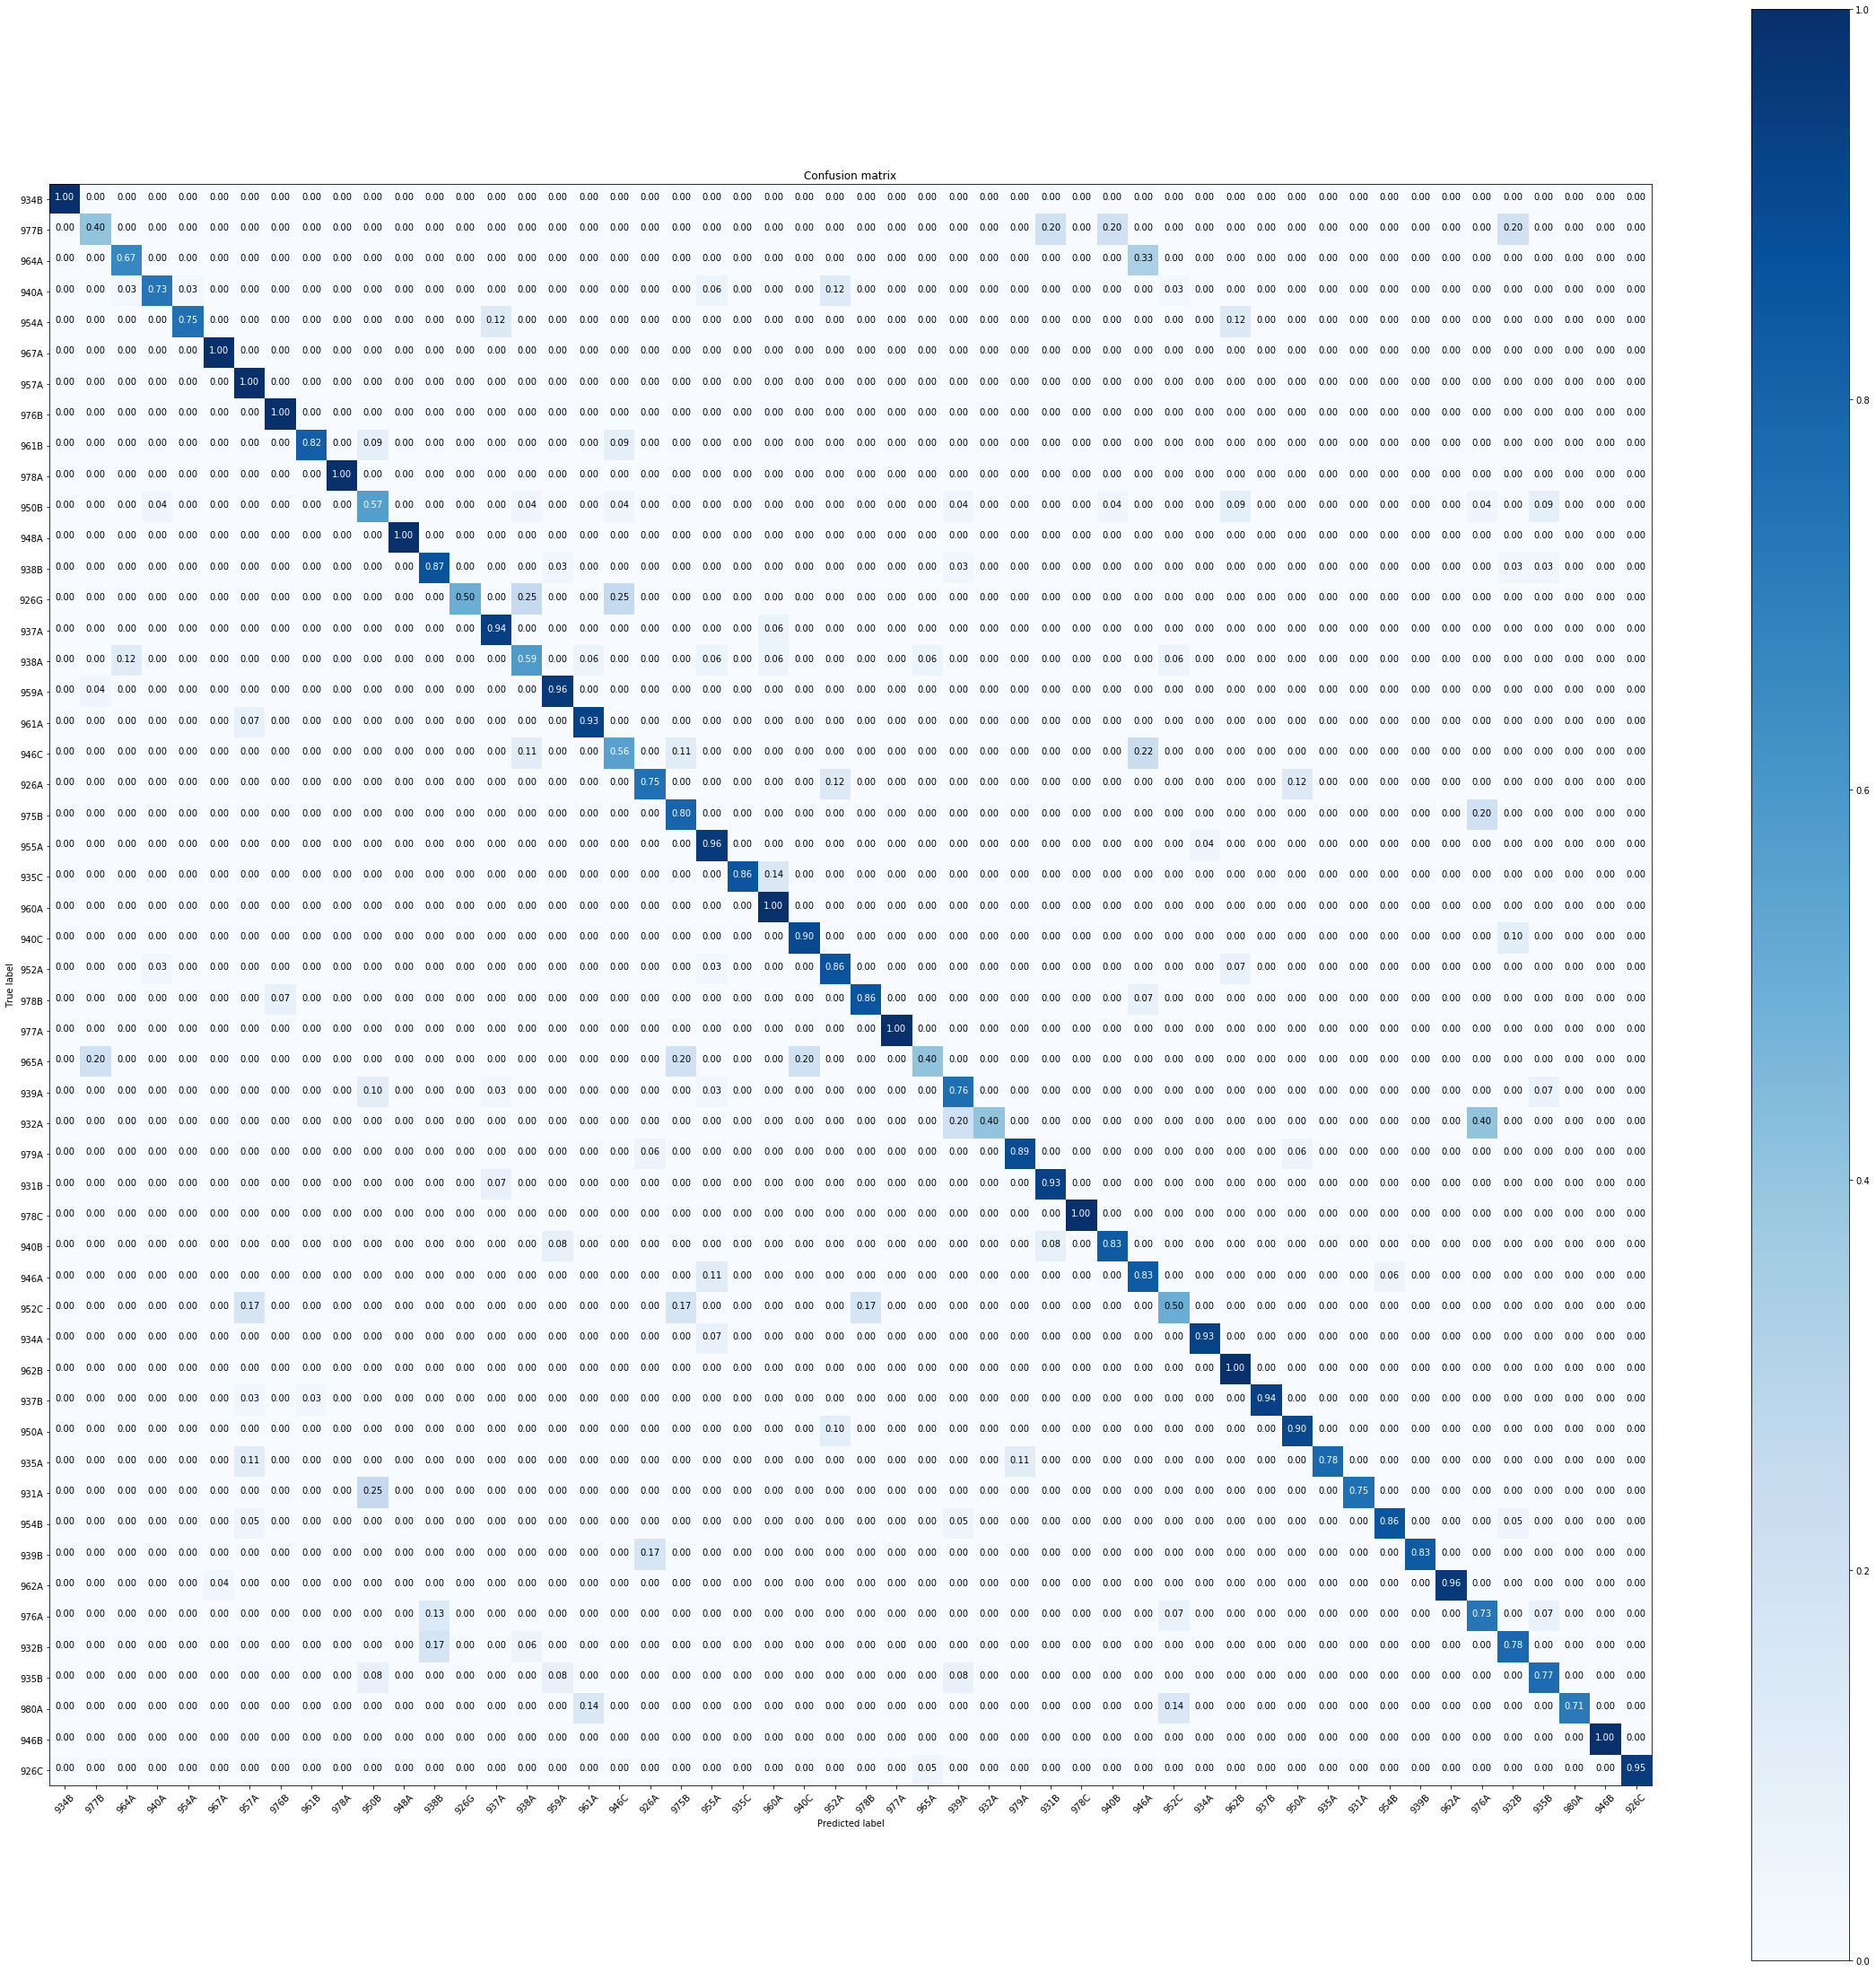

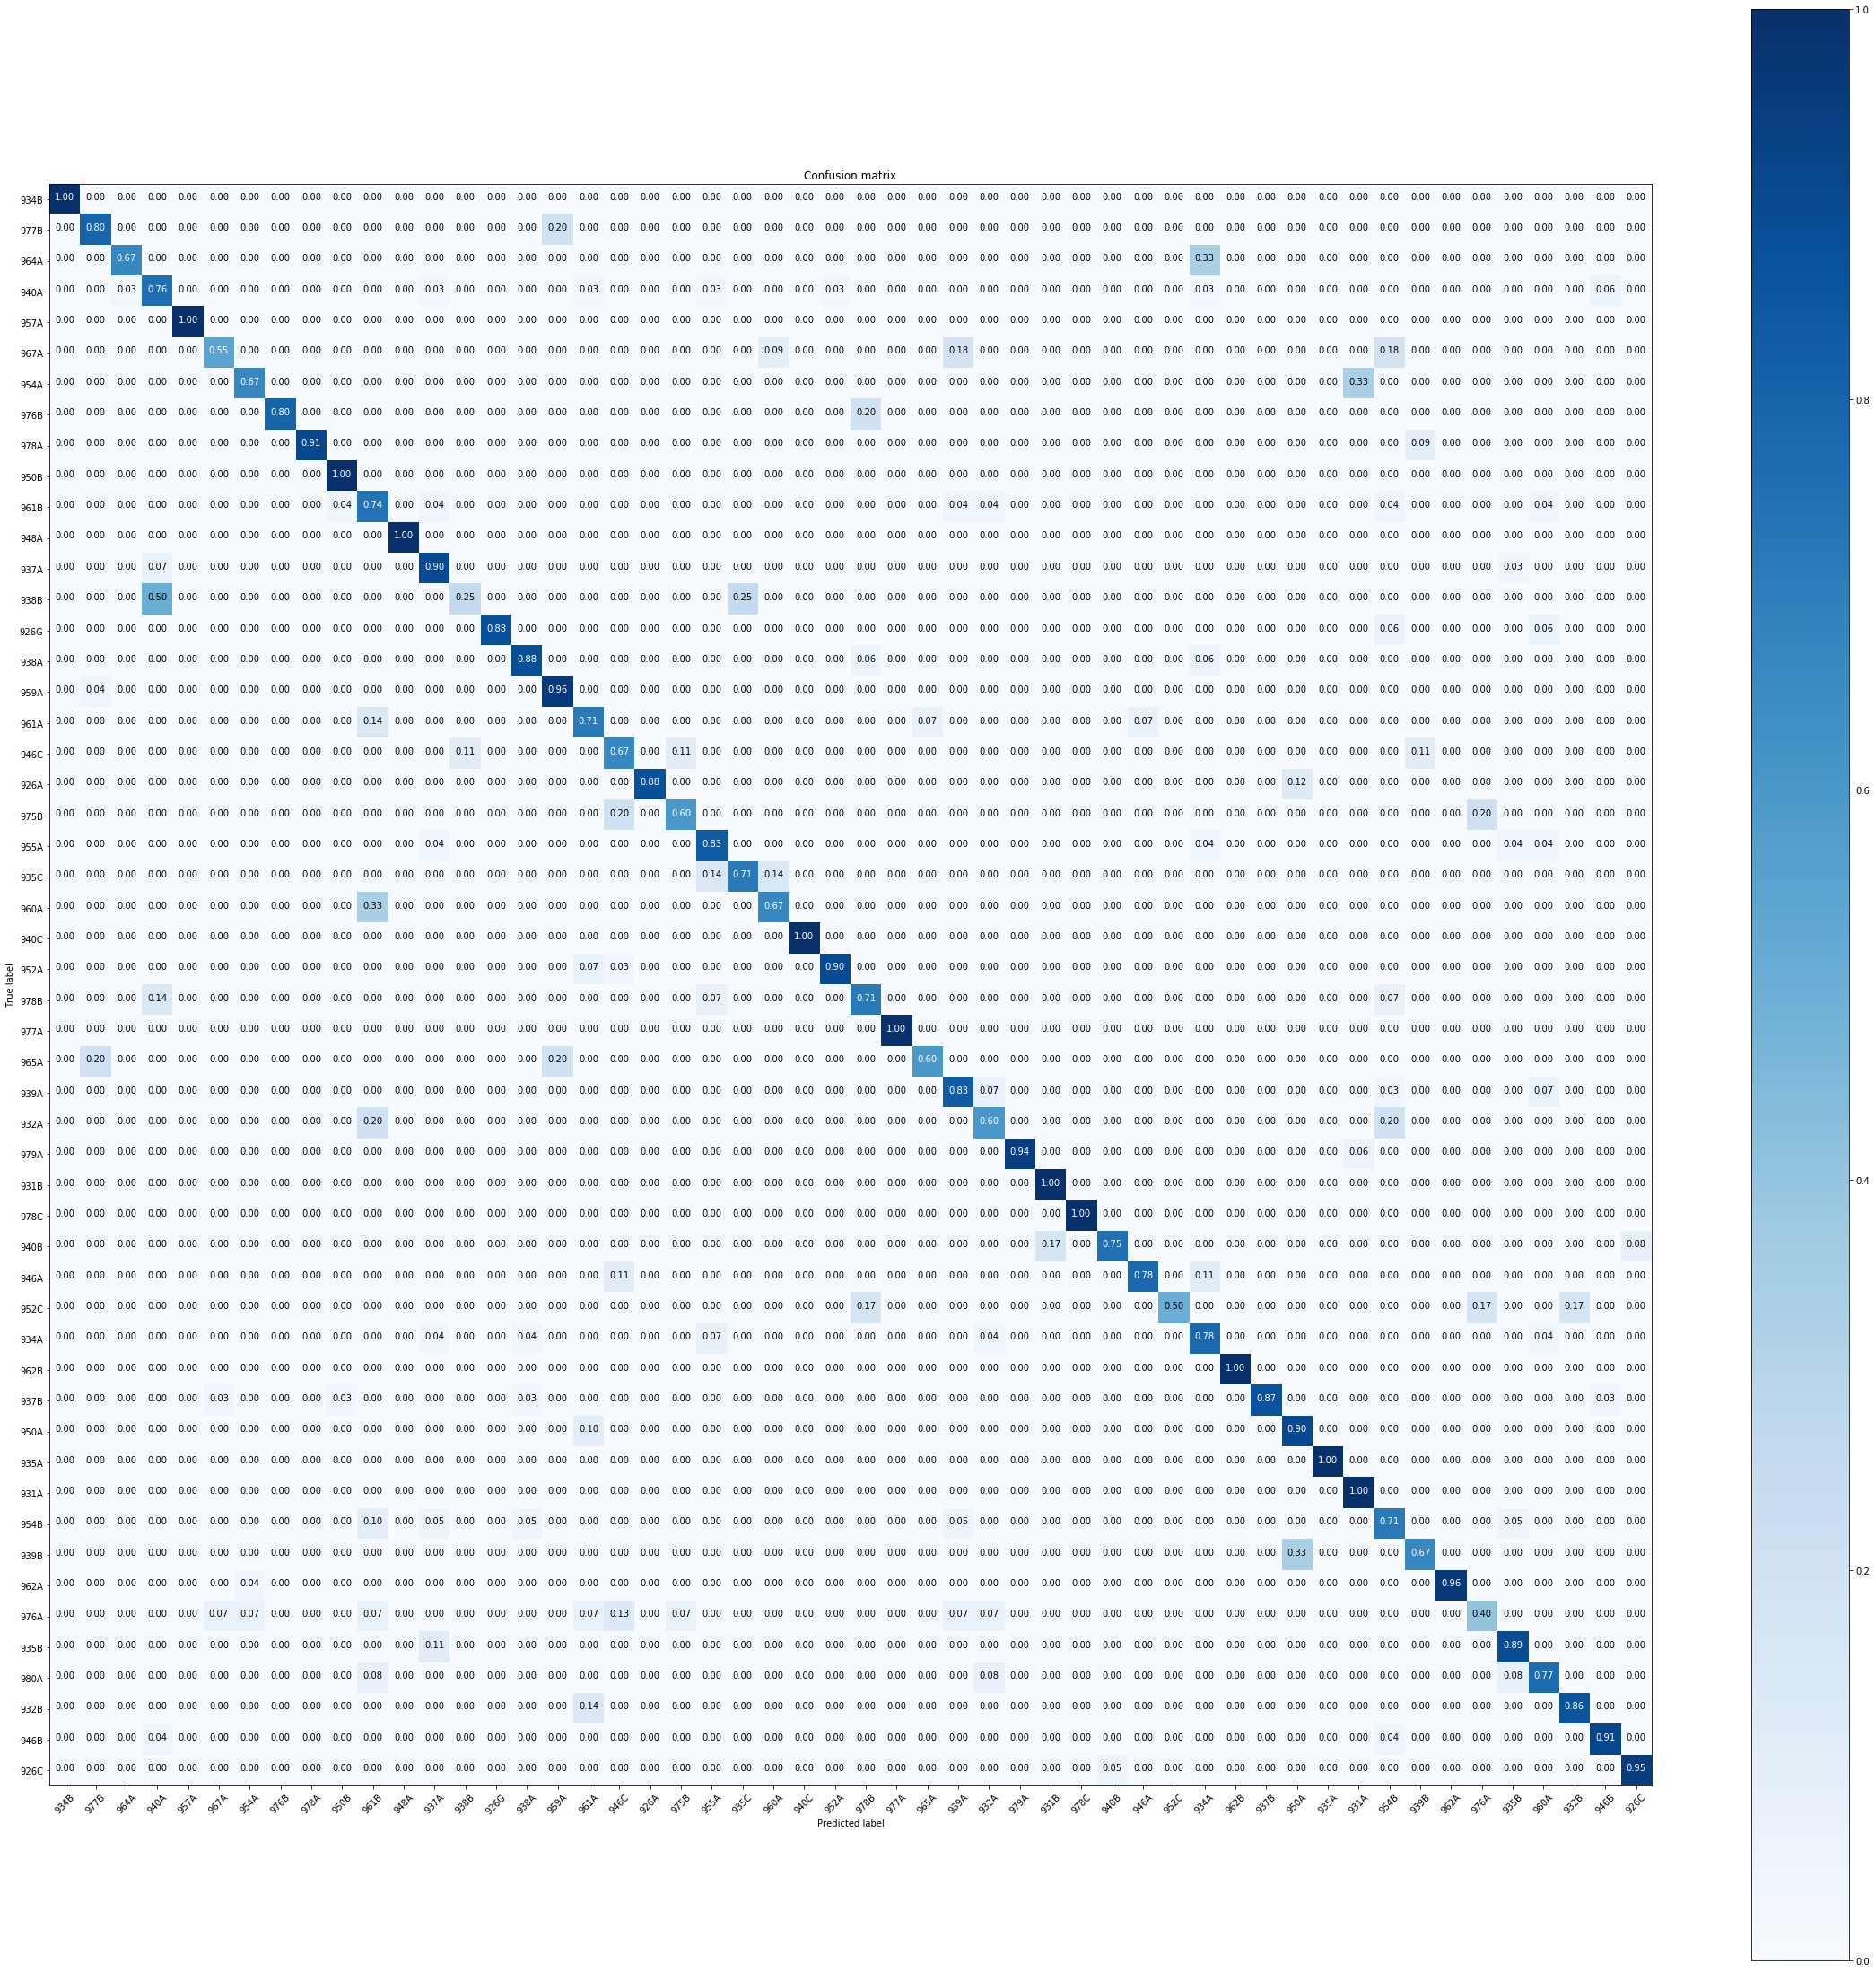

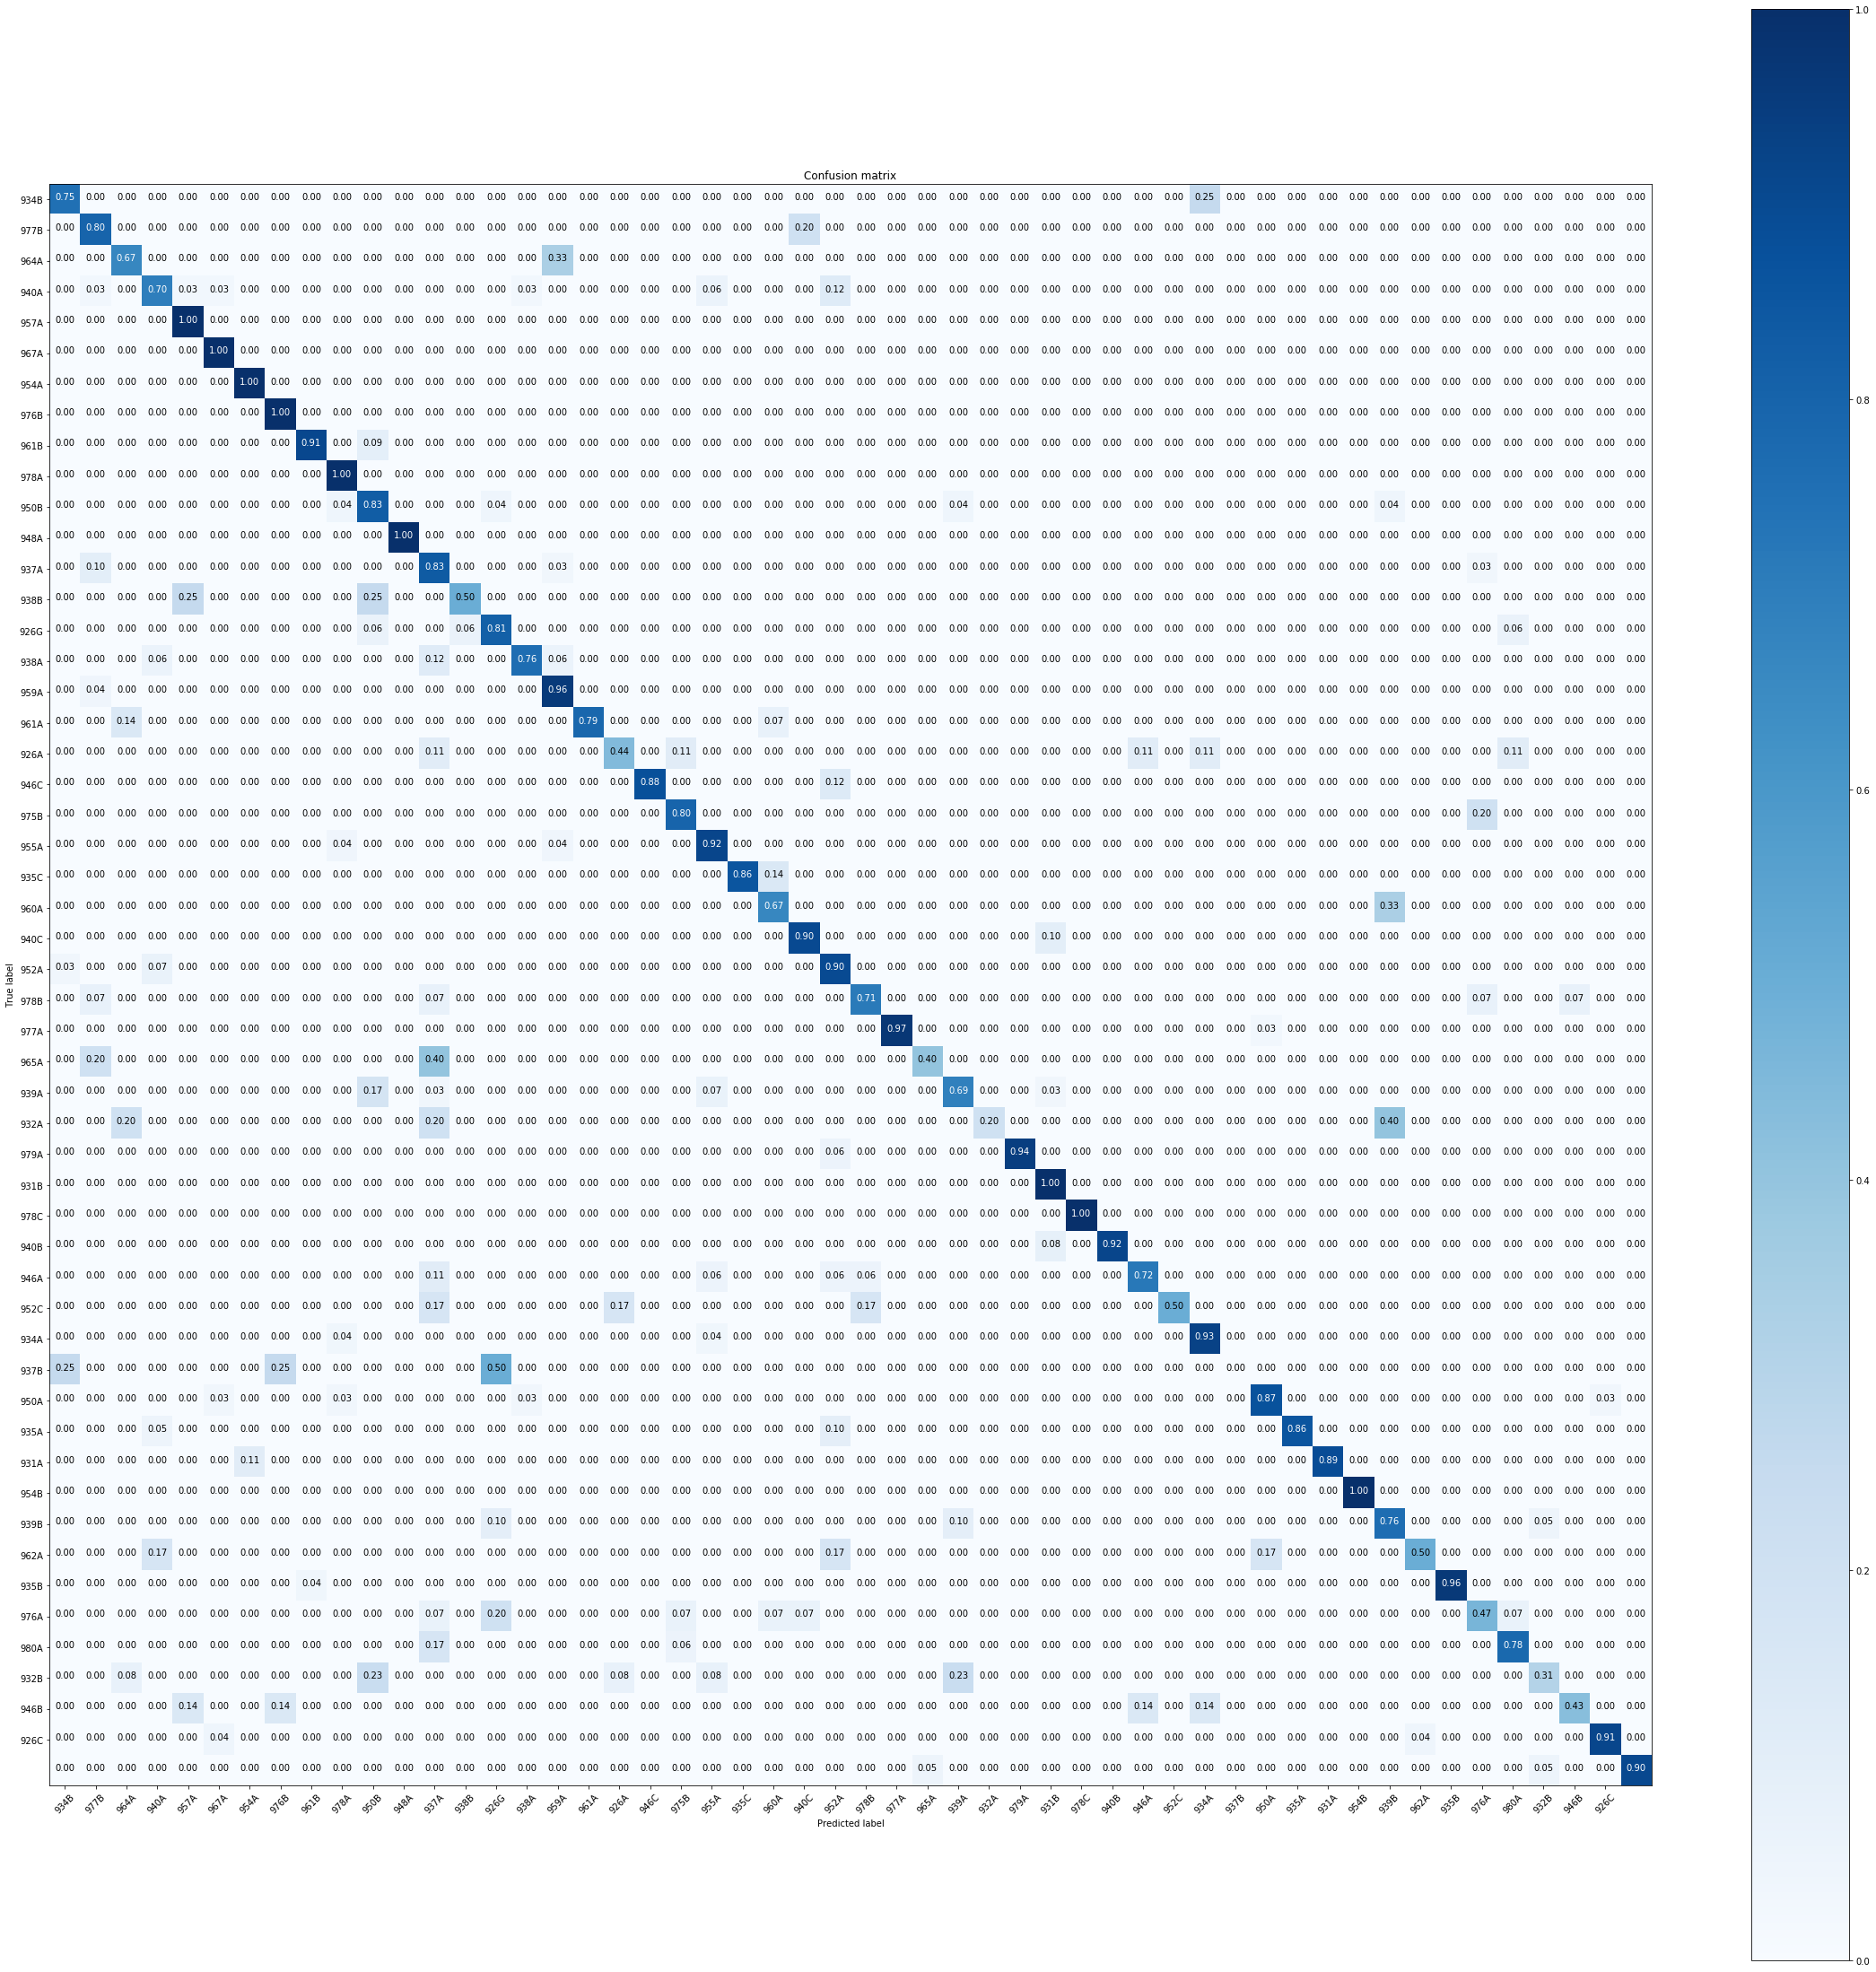

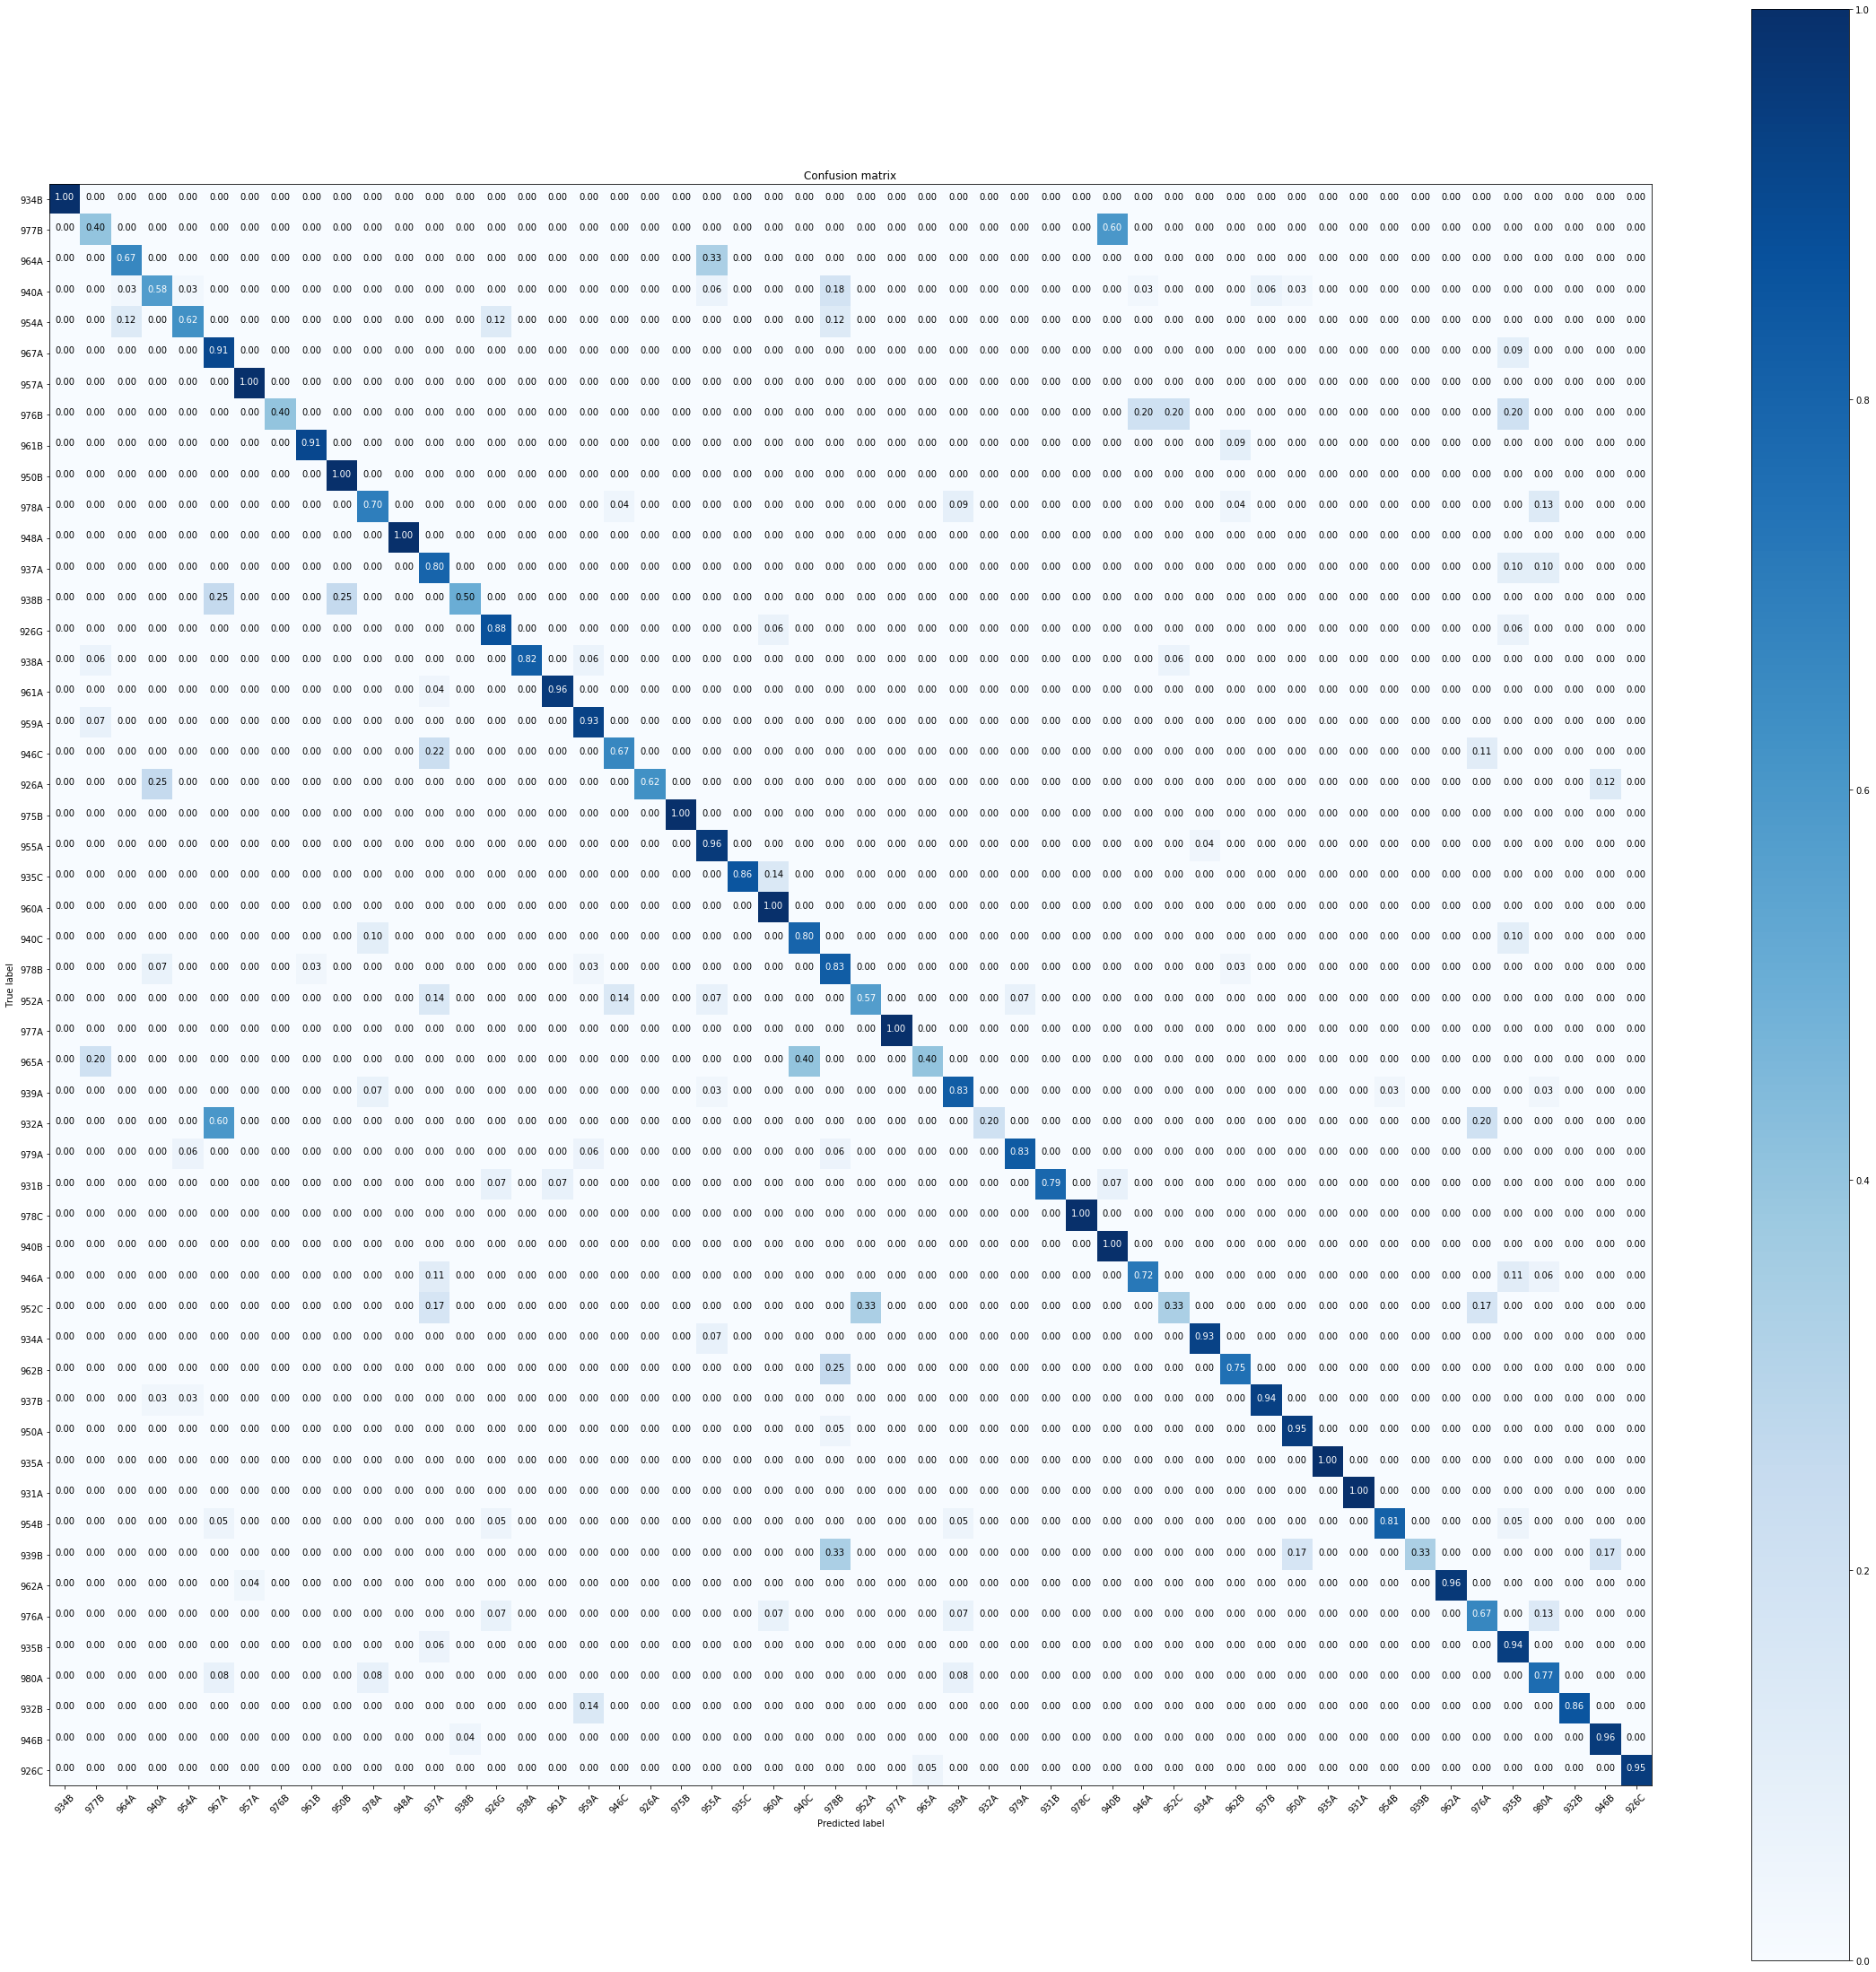

In [1112]:
plot_confusion_matrix(metrics.confusion_matrix(y_validate_naive, svm_y_pred_naive),set(svm_y_pred_naive),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_naive, dt_y_pred_naive),set(dt_y_pred_naive),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_naive, rf_y_pred_naive),set(rf_y_pred_naive),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_naive, nn_y_pred_naive),set(nn_y_pred_naive),normalize=True)

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.6        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.71428571 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.95238095]]
Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.8        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.33333333 0.        ]
 ...
 [0.         0.         0.         ... 0.85714286 0.         0.        ]
 [0.         0.         0.         ... 0.         0.91304348 0.        ]
 [0.         0.         0.         ... 0.         0.         0.95238095]]
Normalized confusion matrix
[[1.         0.         0.  

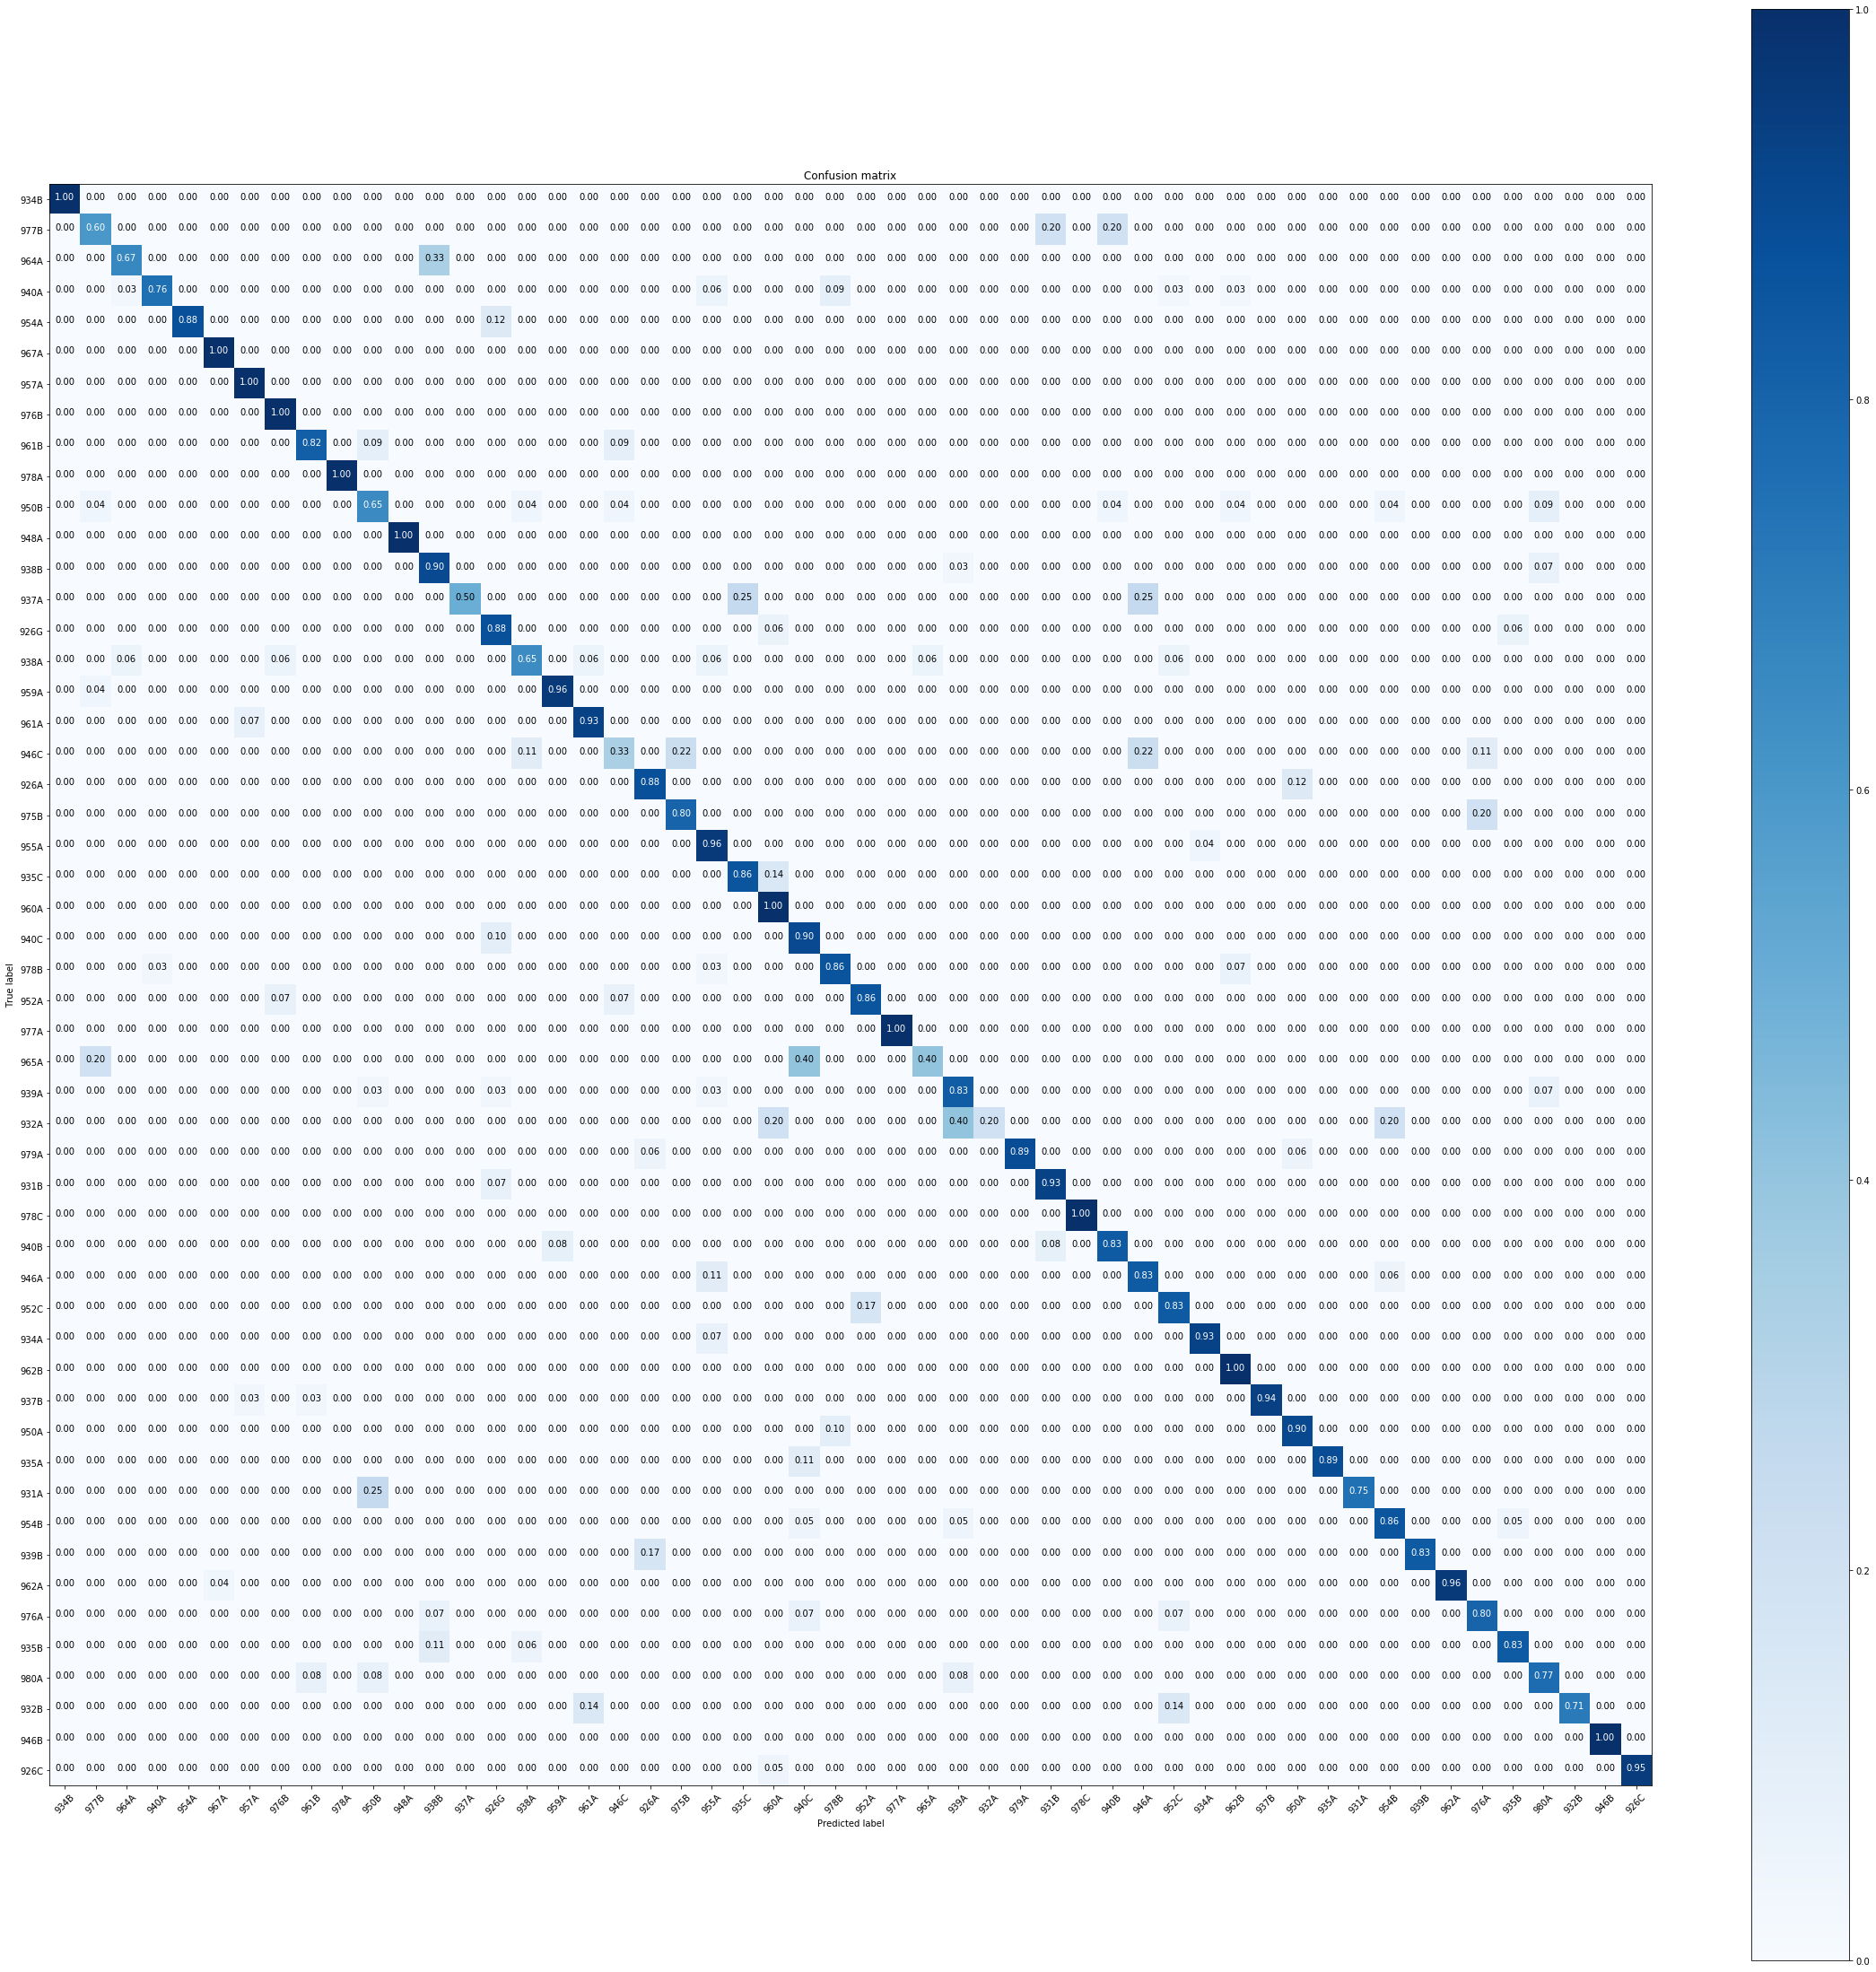

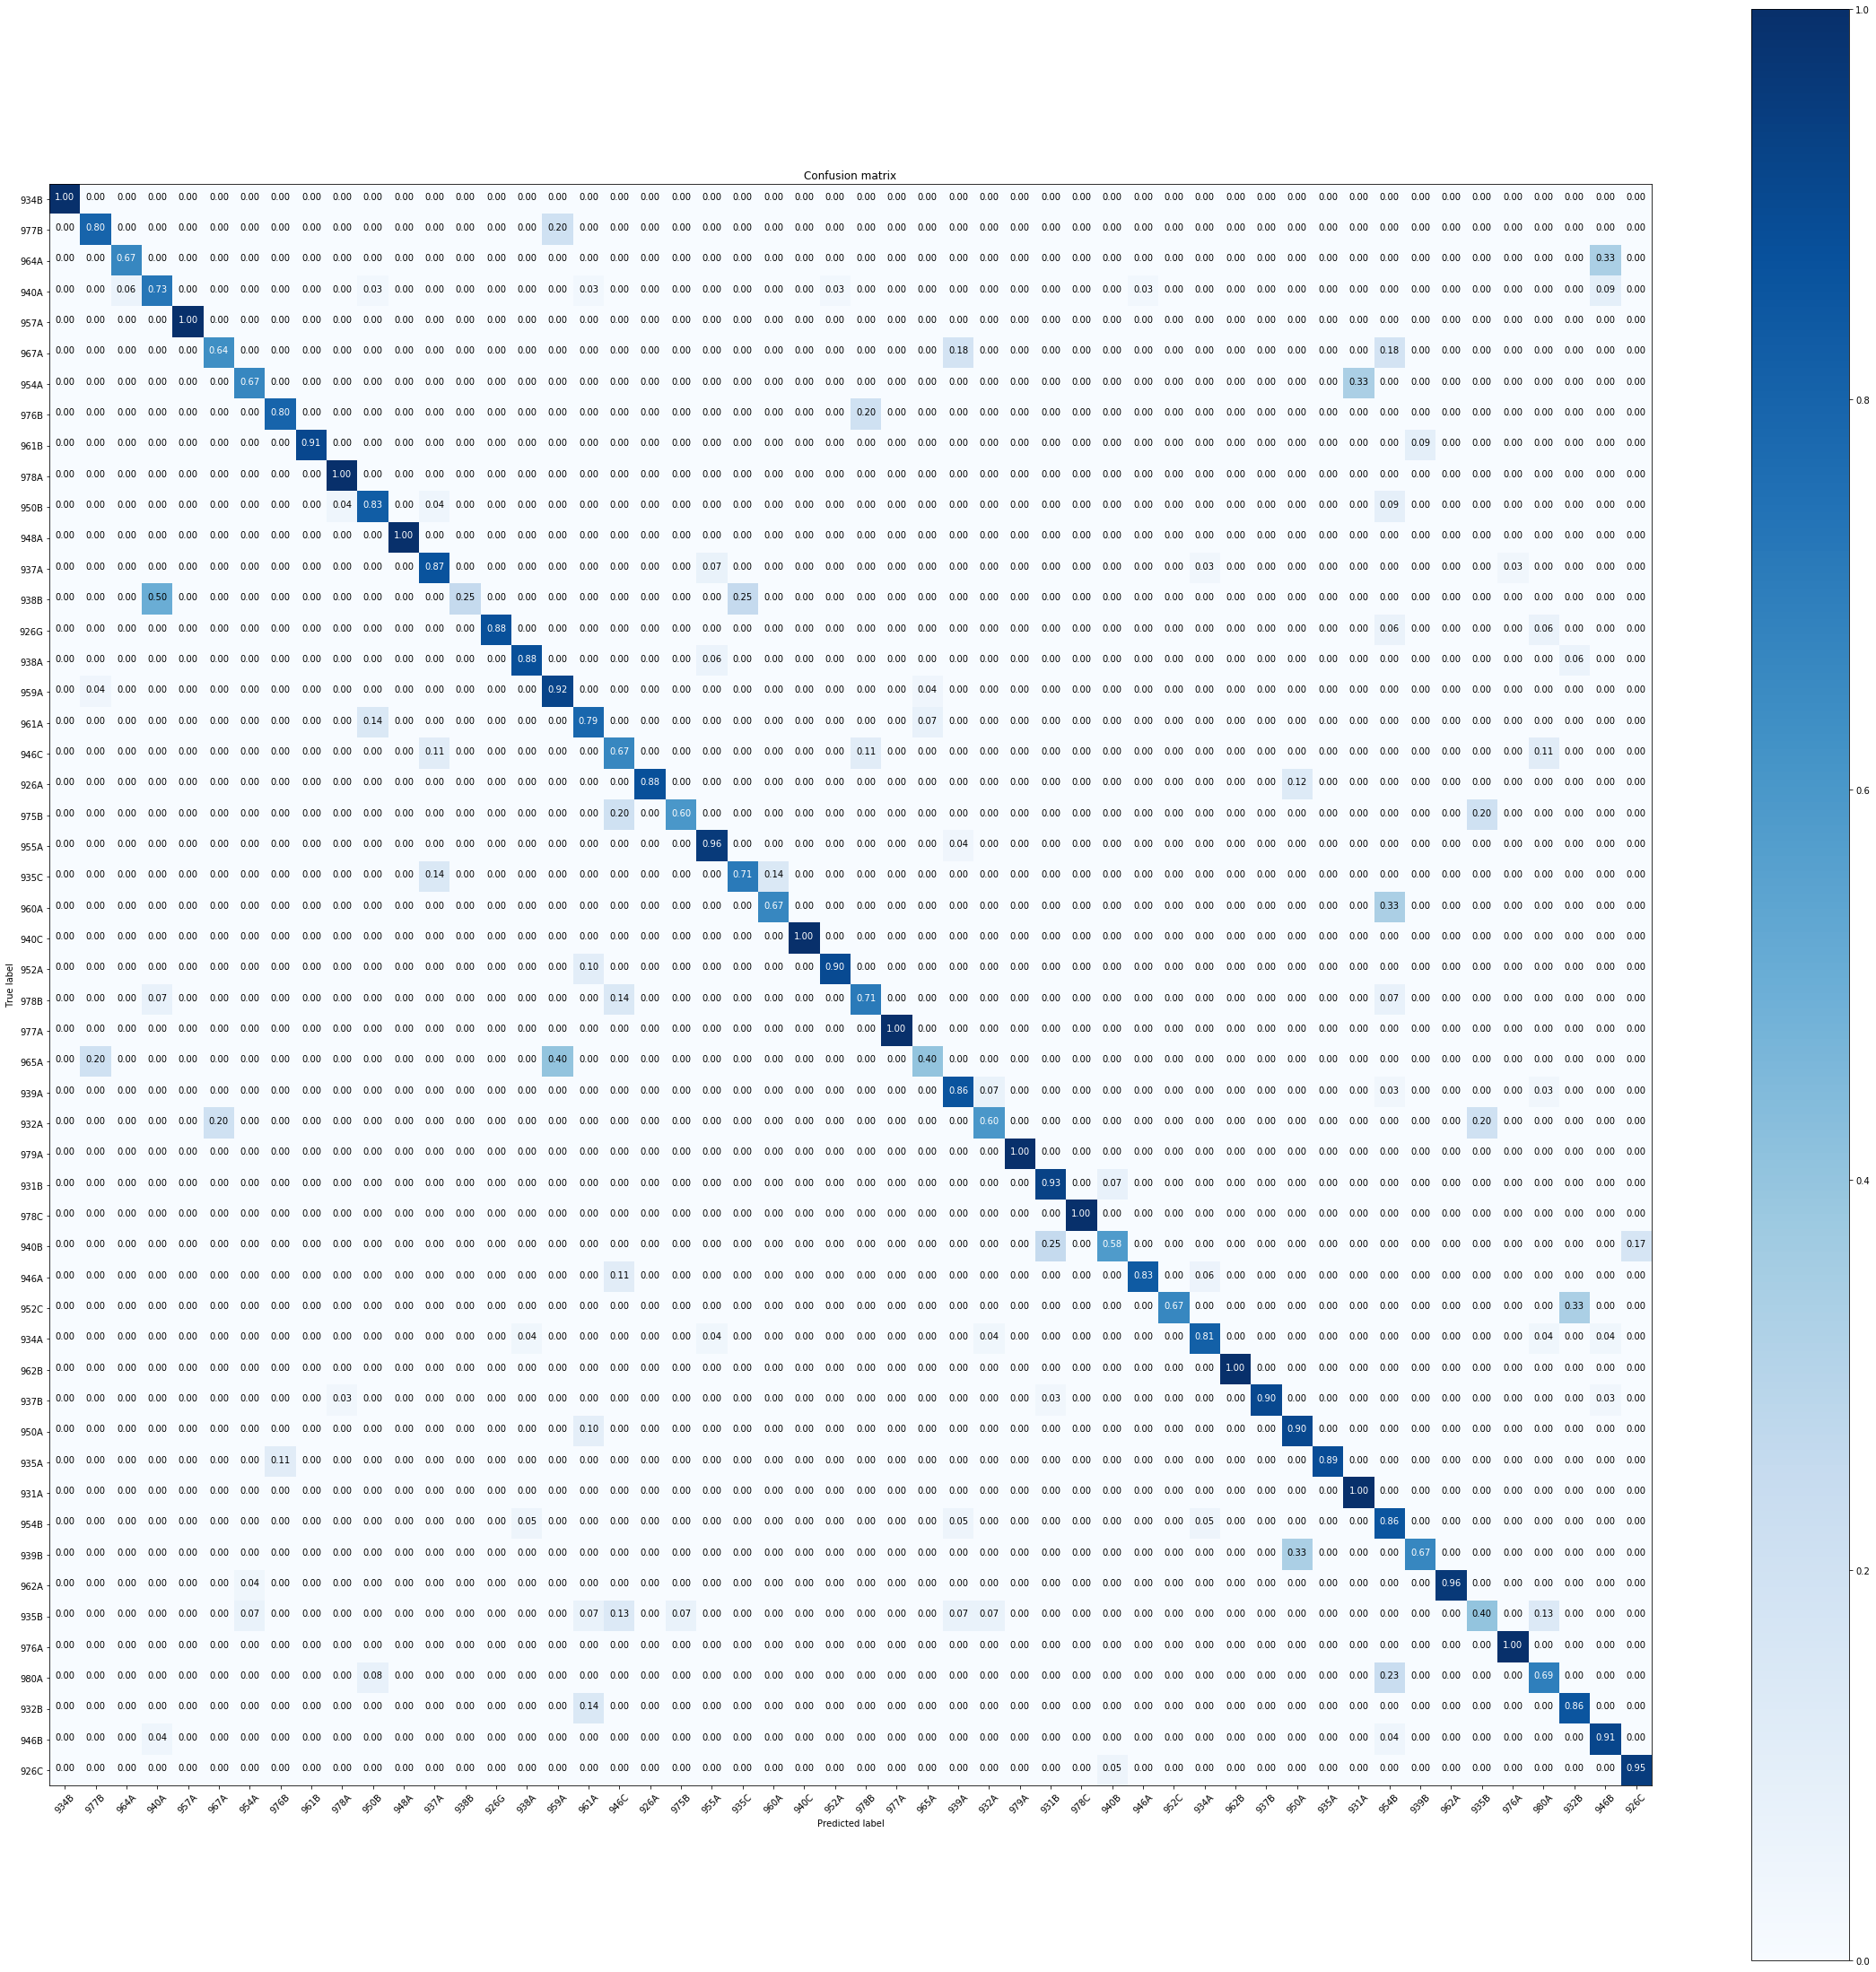

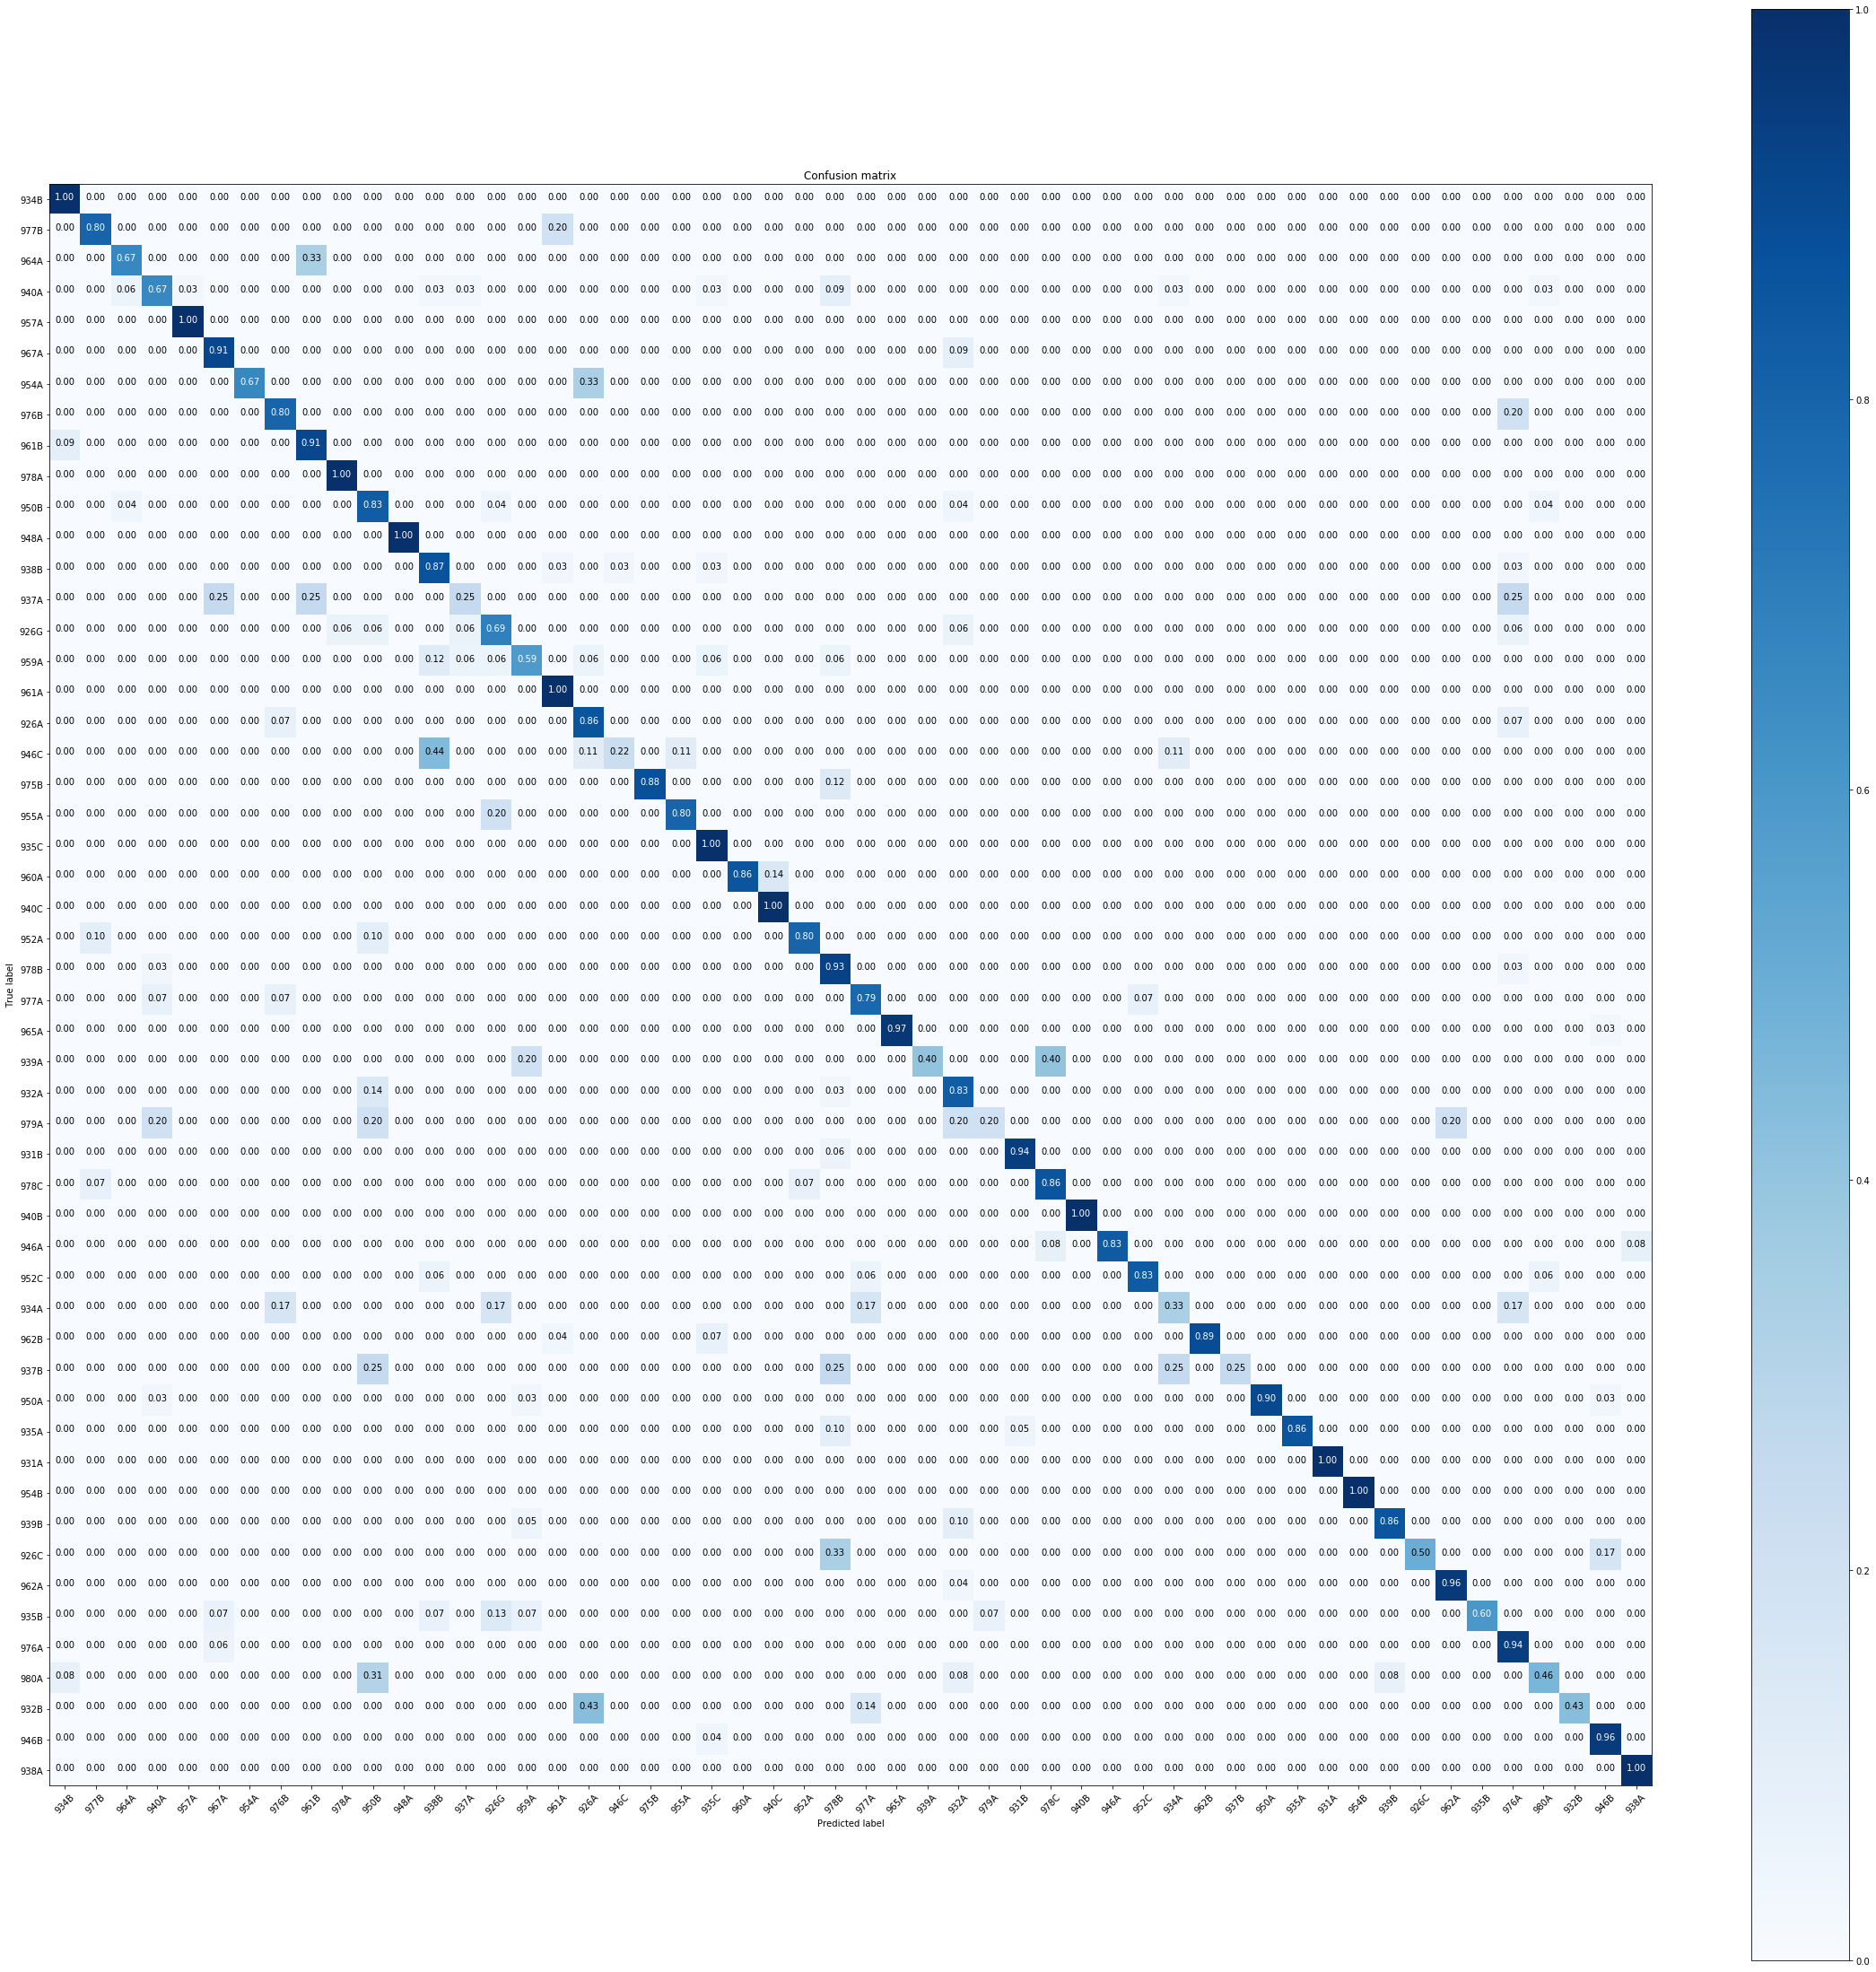

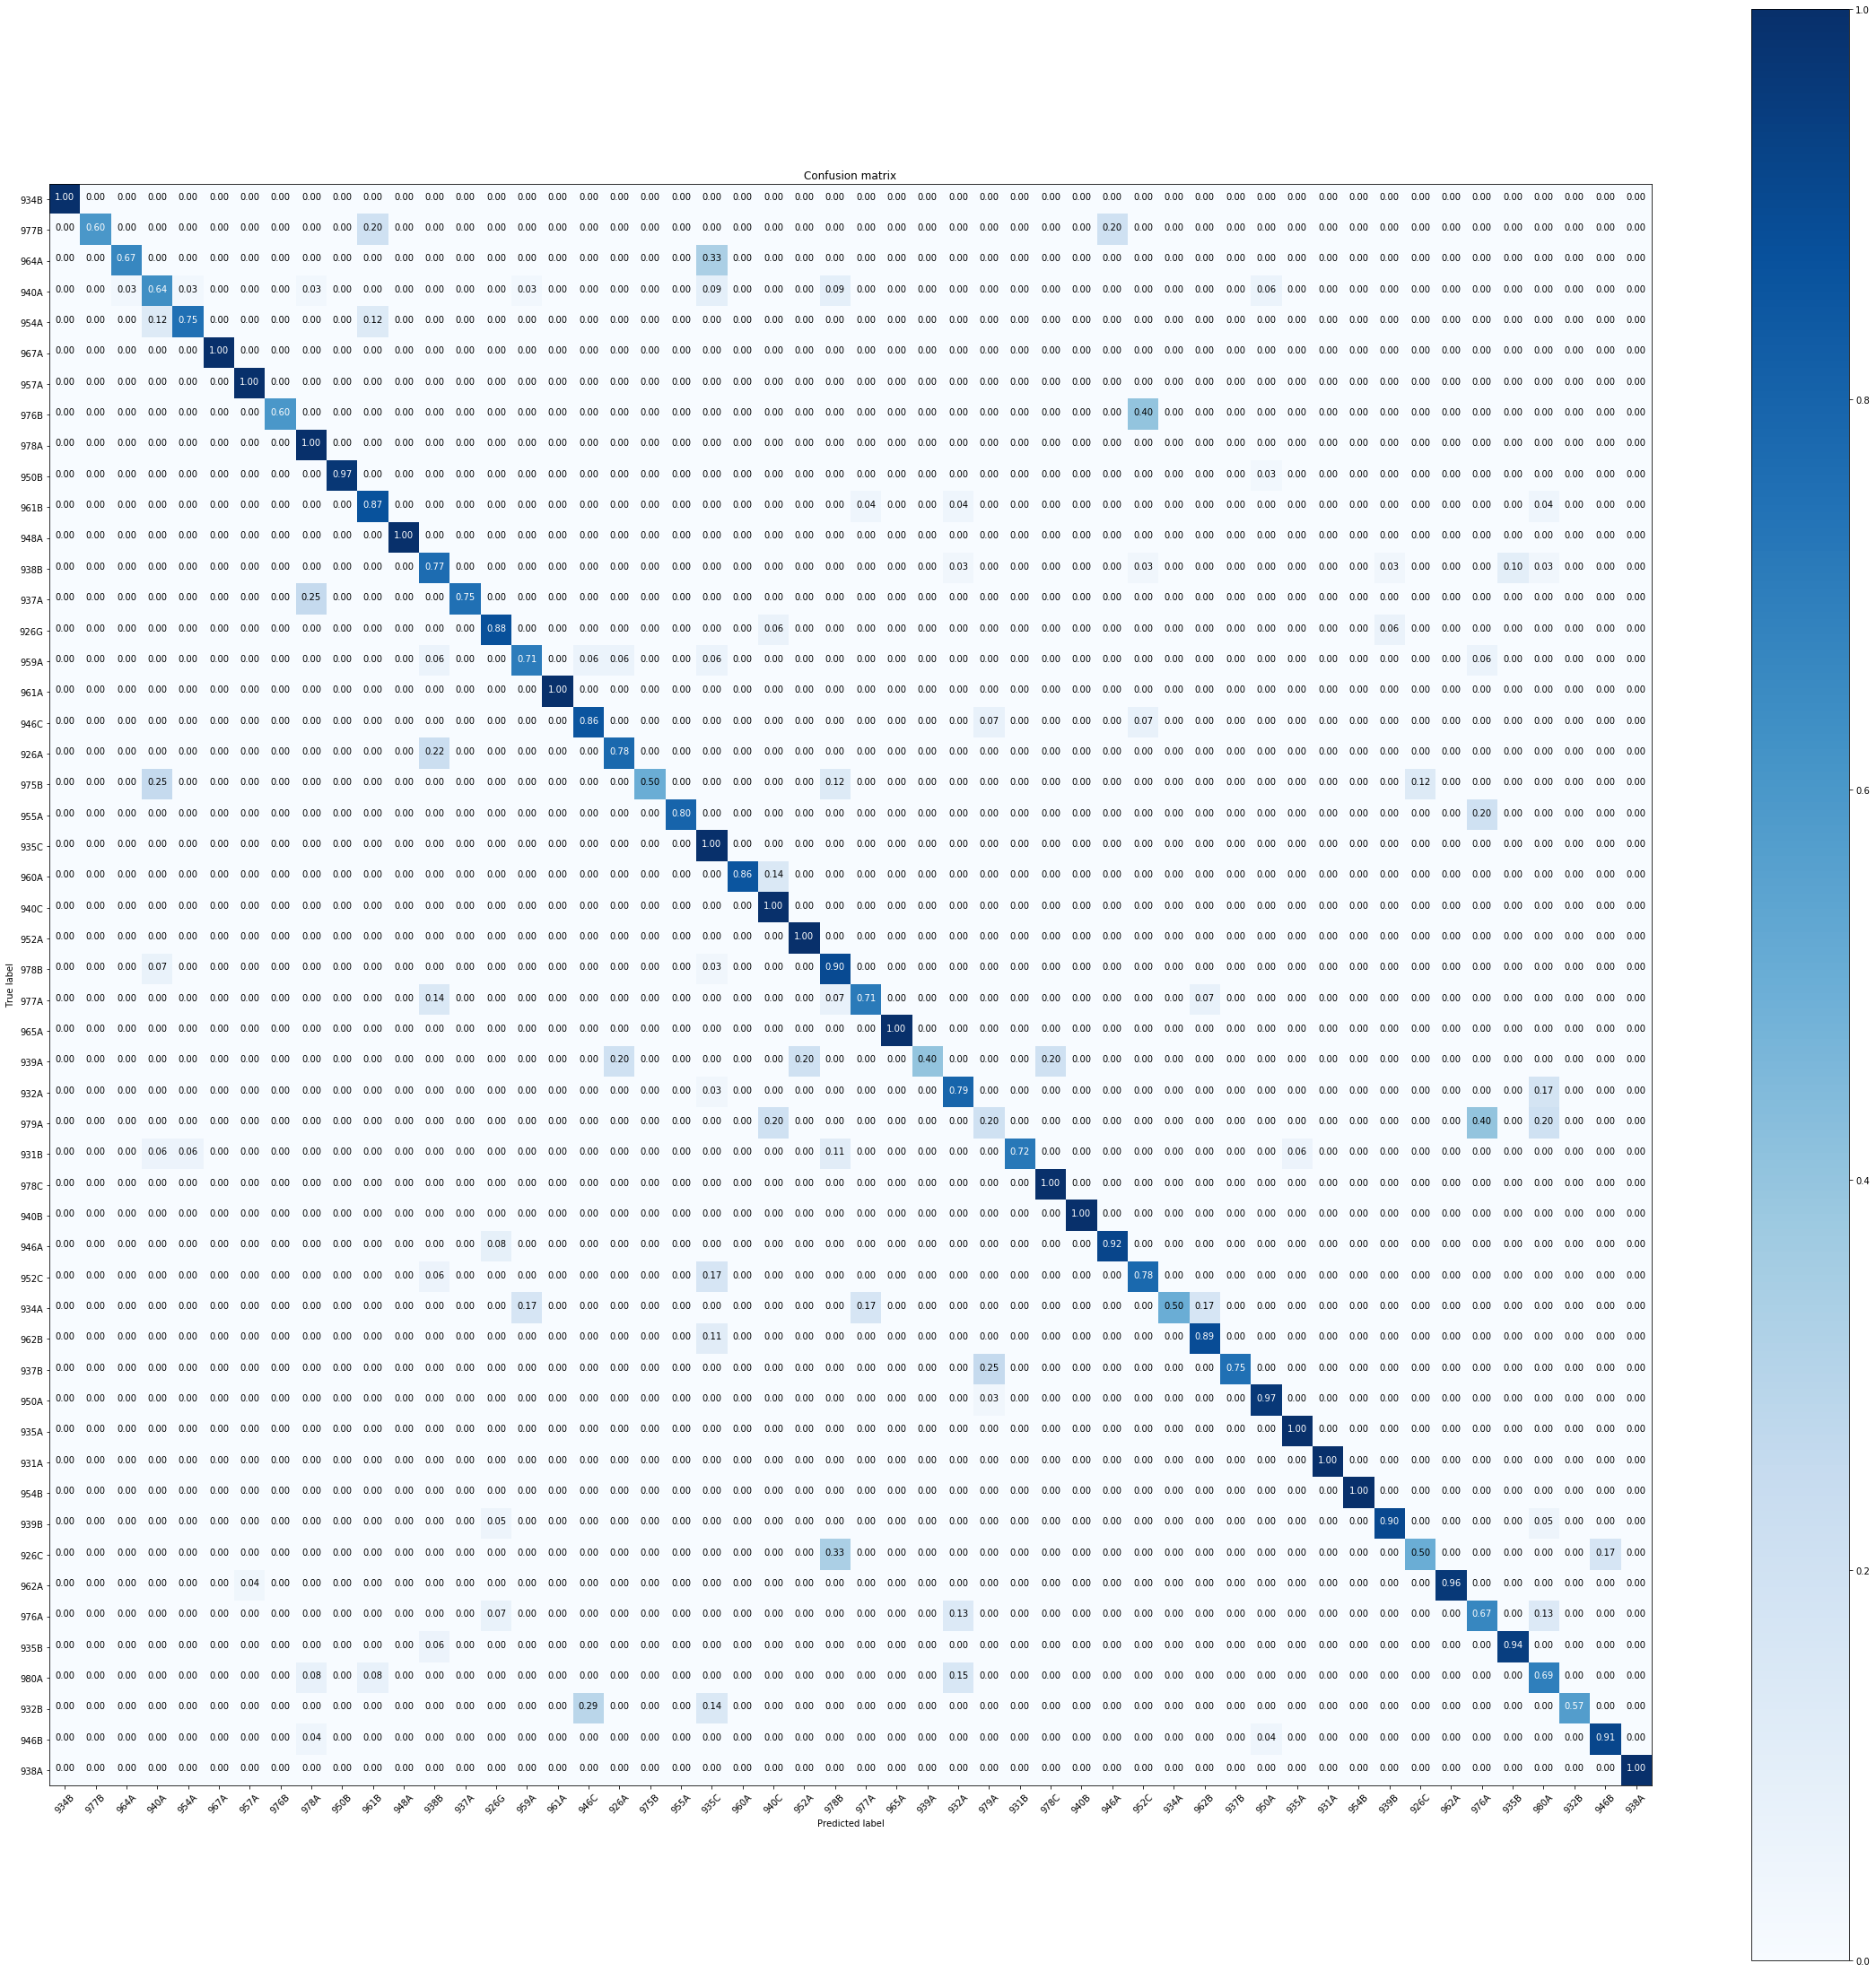

In [1113]:
plot_confusion_matrix(metrics.confusion_matrix(y_validate_no_comment, svm_y_pred_no_comment),set(svm_y_pred_no_comment),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_no_comment, dt_y_pred_no_comment),set(dt_y_pred_no_comment),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_no_comment, rf_y_pred_no_comment),set(rf_y_pred_no_comment),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_no_comment, nn_y_pred_no_comment),set(nn_y_pred_no_comment),normalize=True)

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.2        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.71428571 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.85714286]]
Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.4        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.86956522 0.        ]
 [0.         0.         0.         ... 0.         0.         0.76190476]]
Normalized confusion matrix
[[1.         0.         0.  

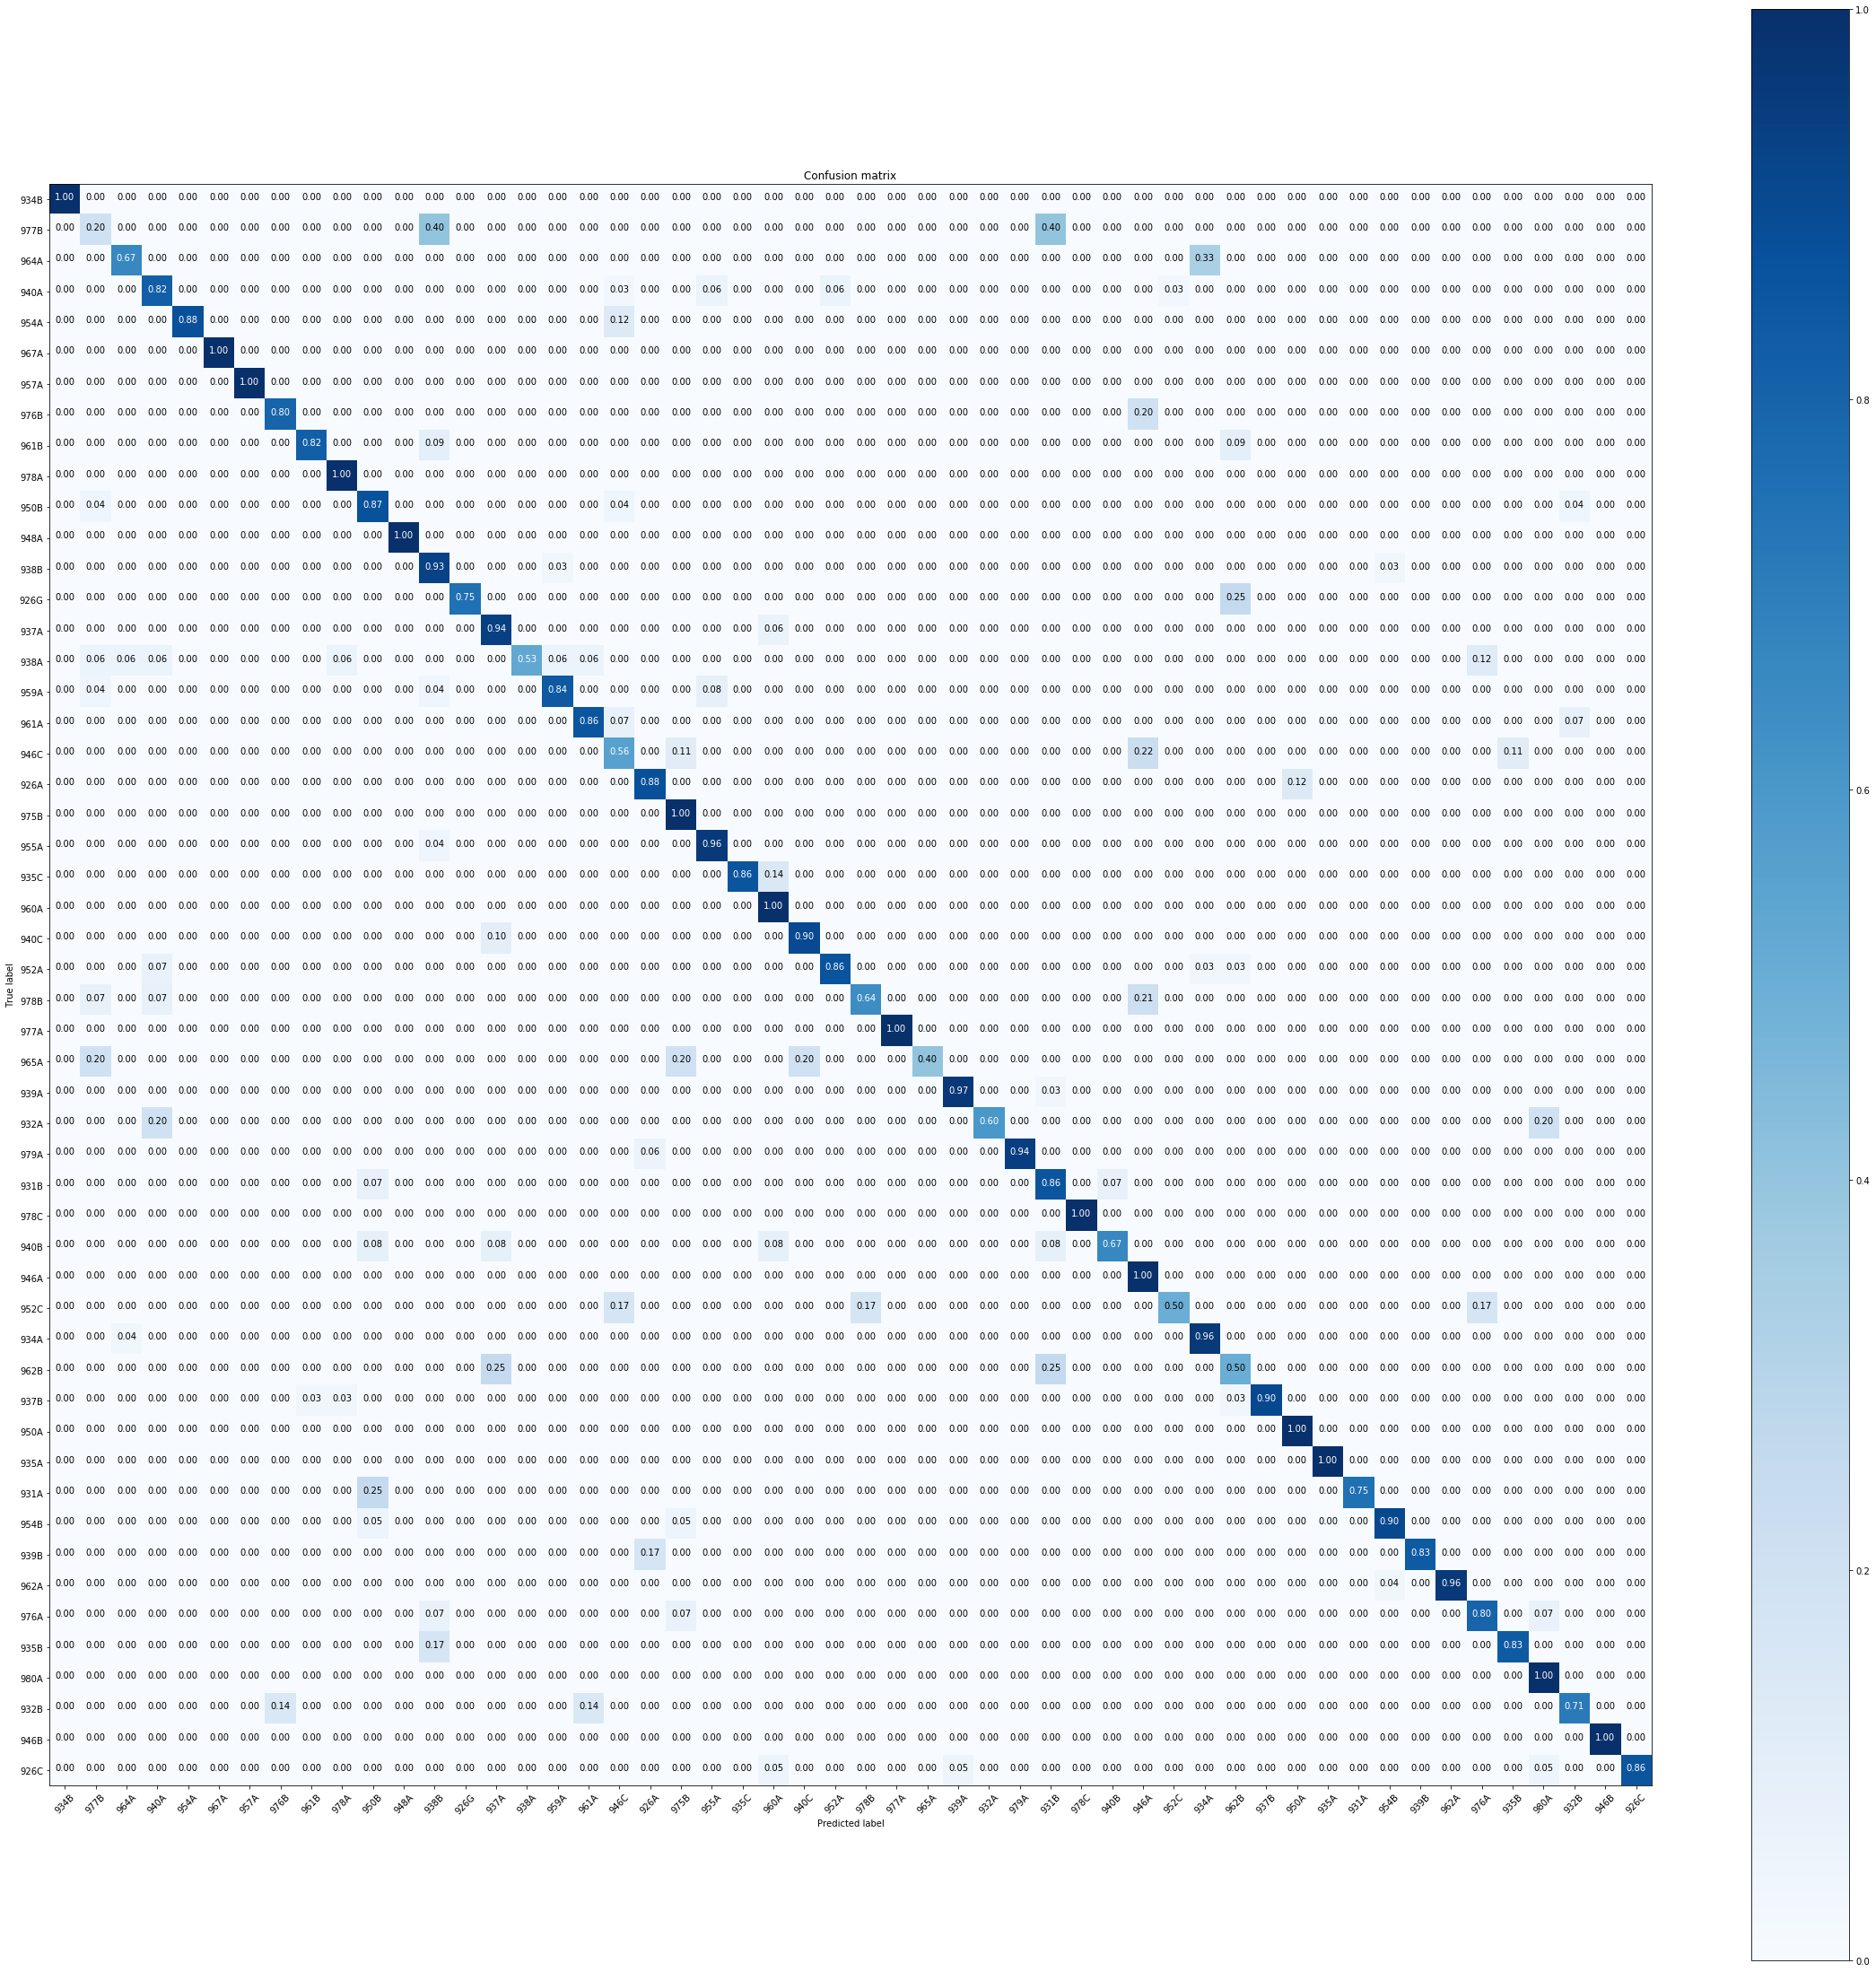

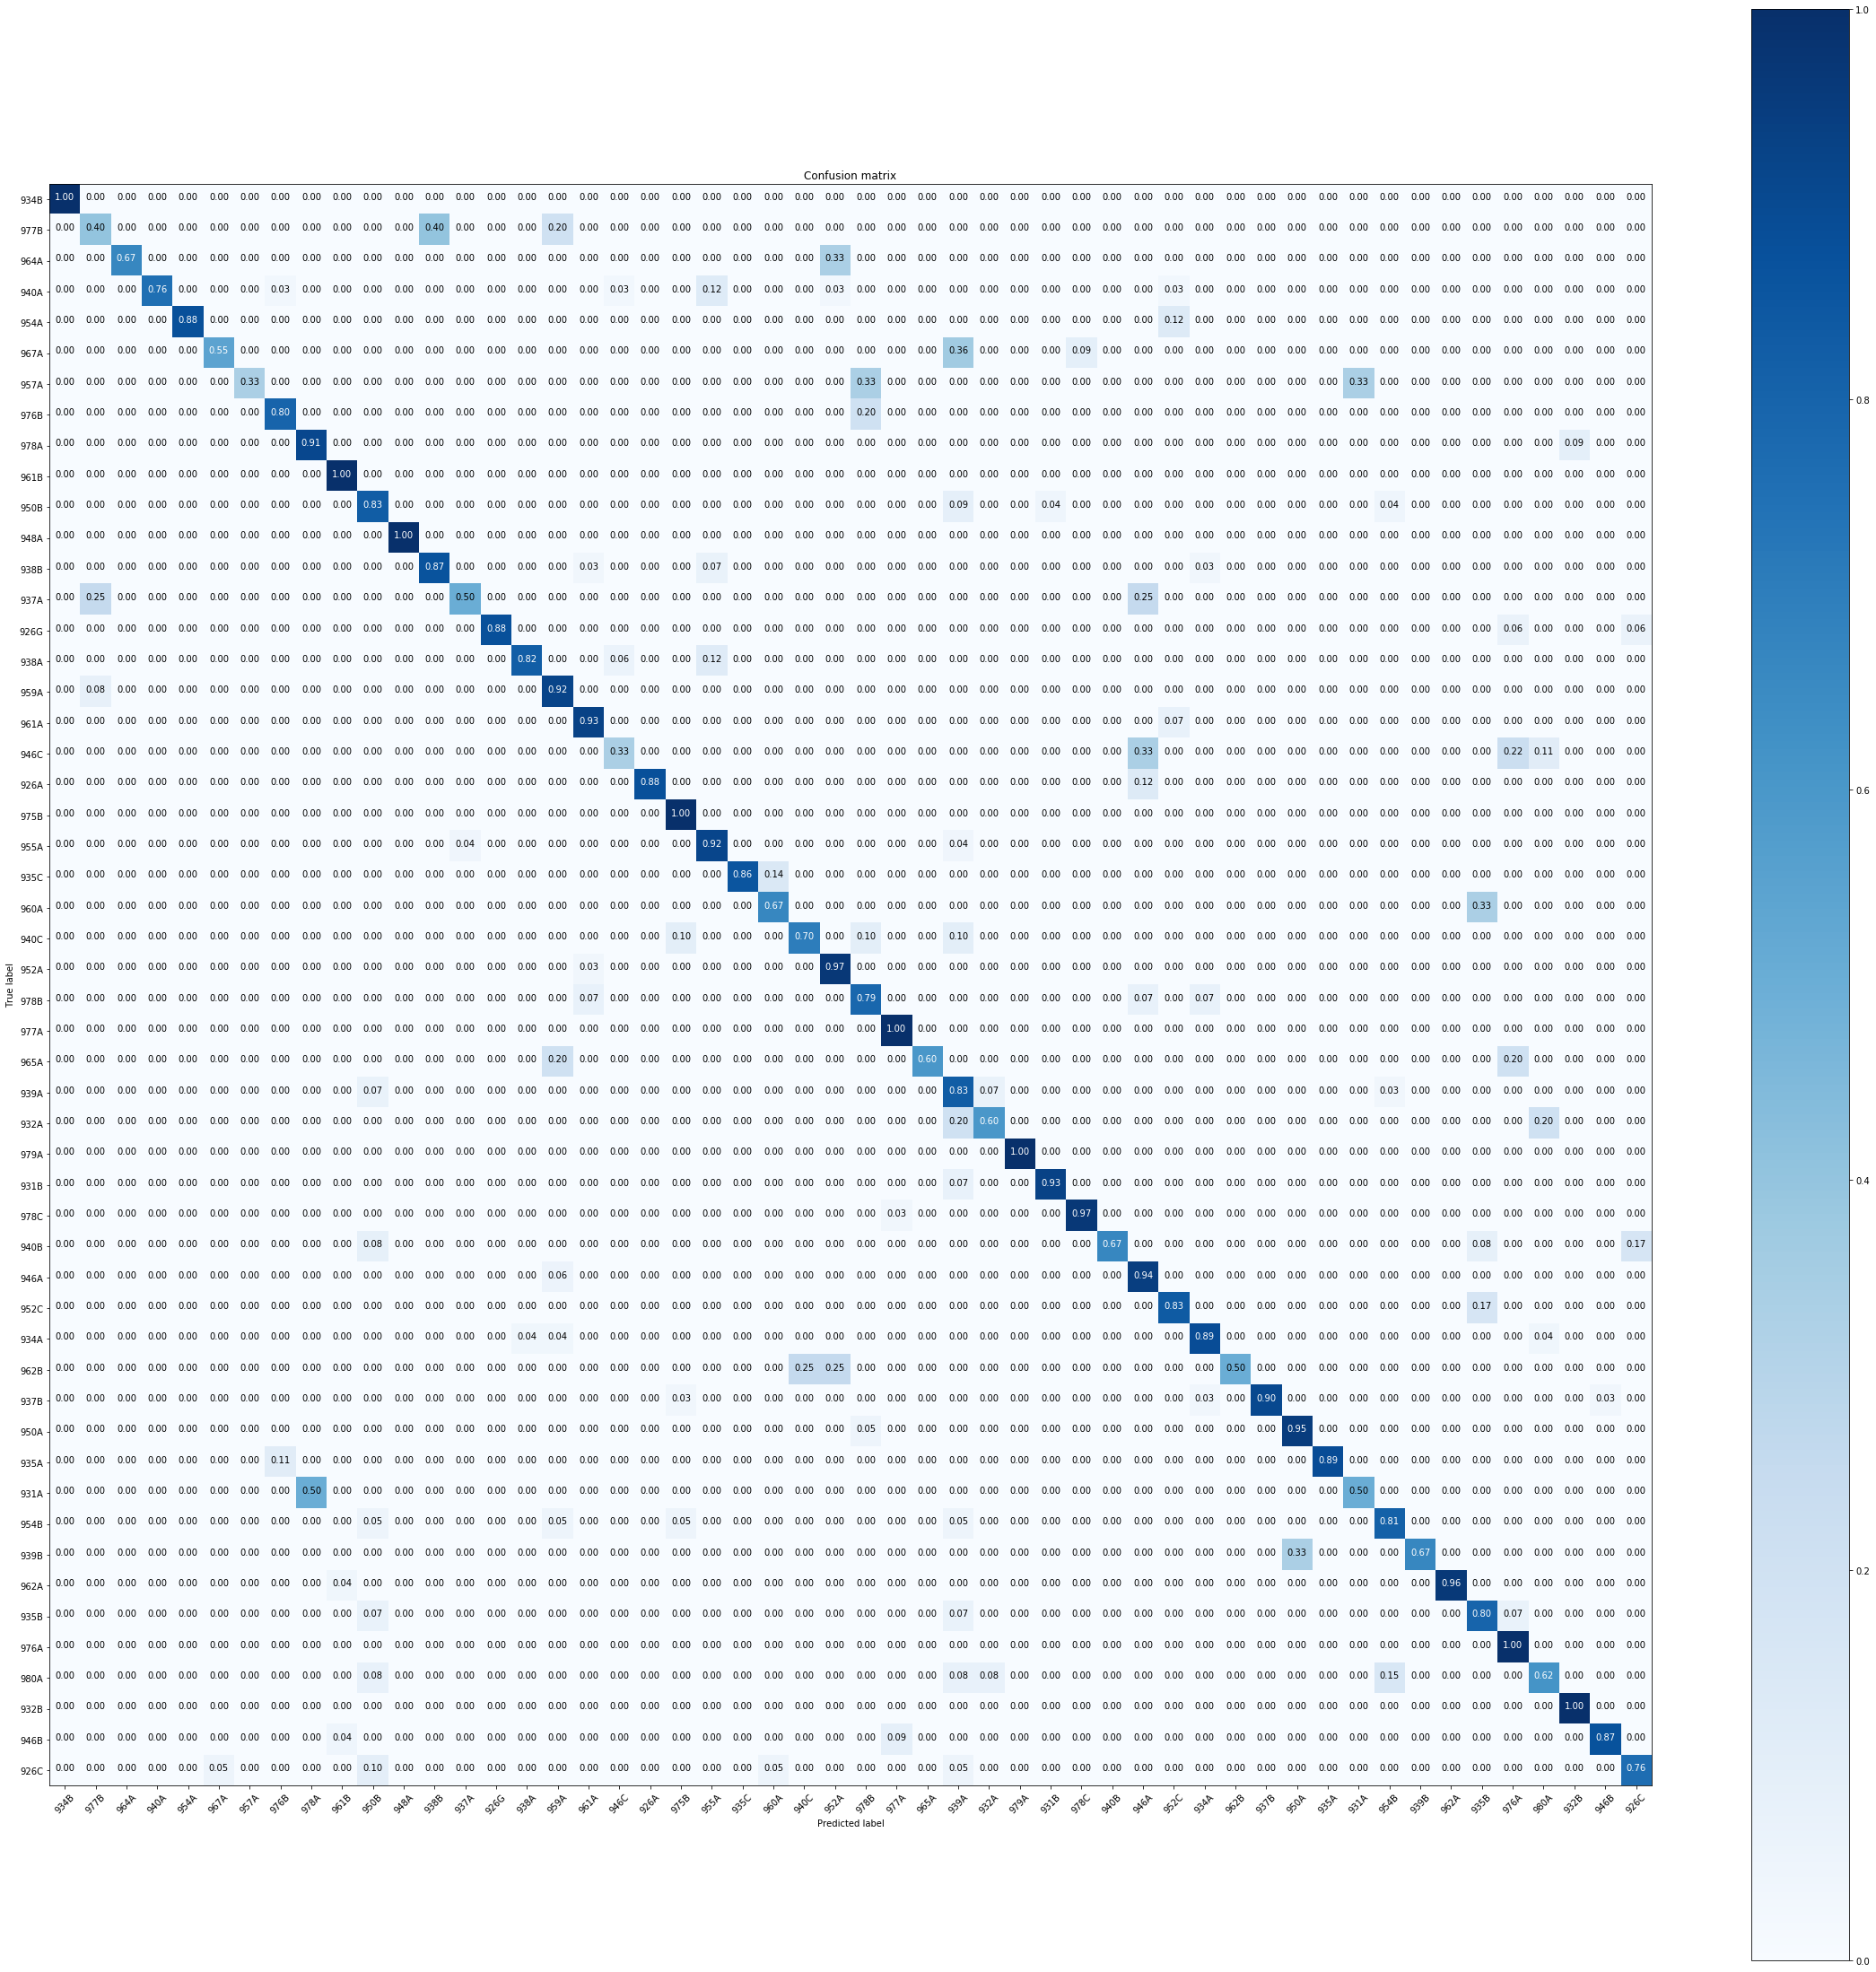

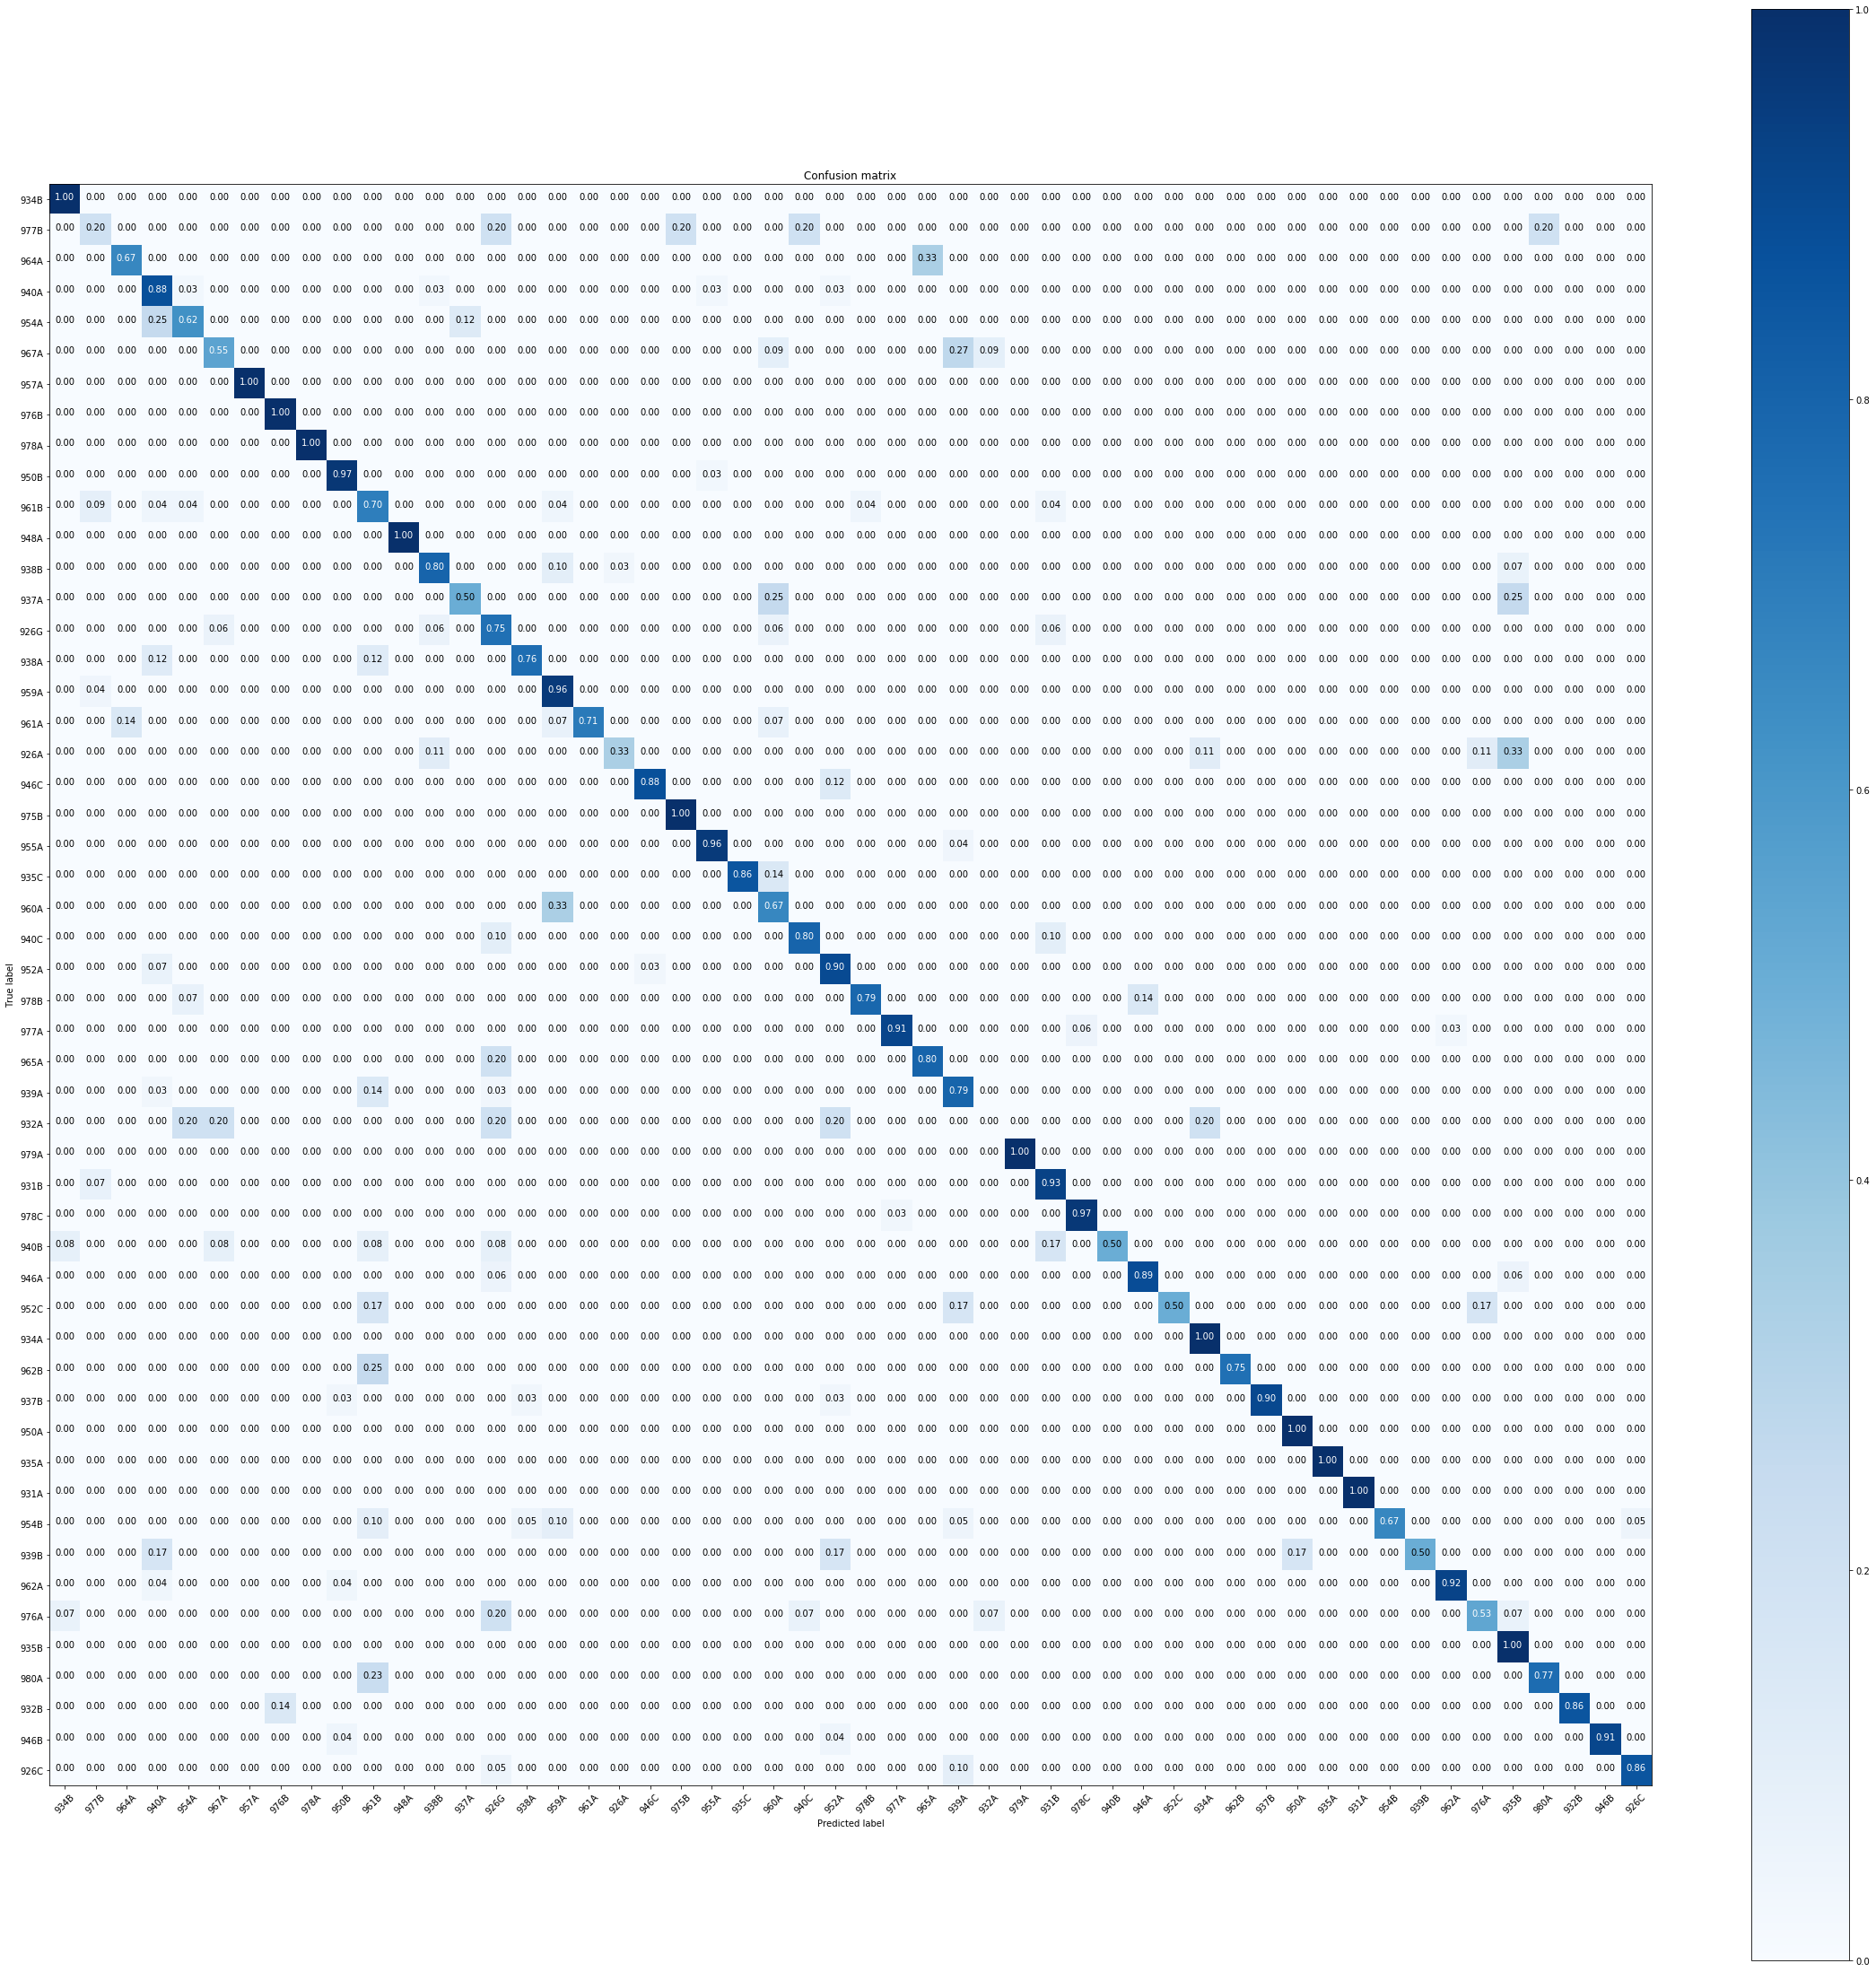

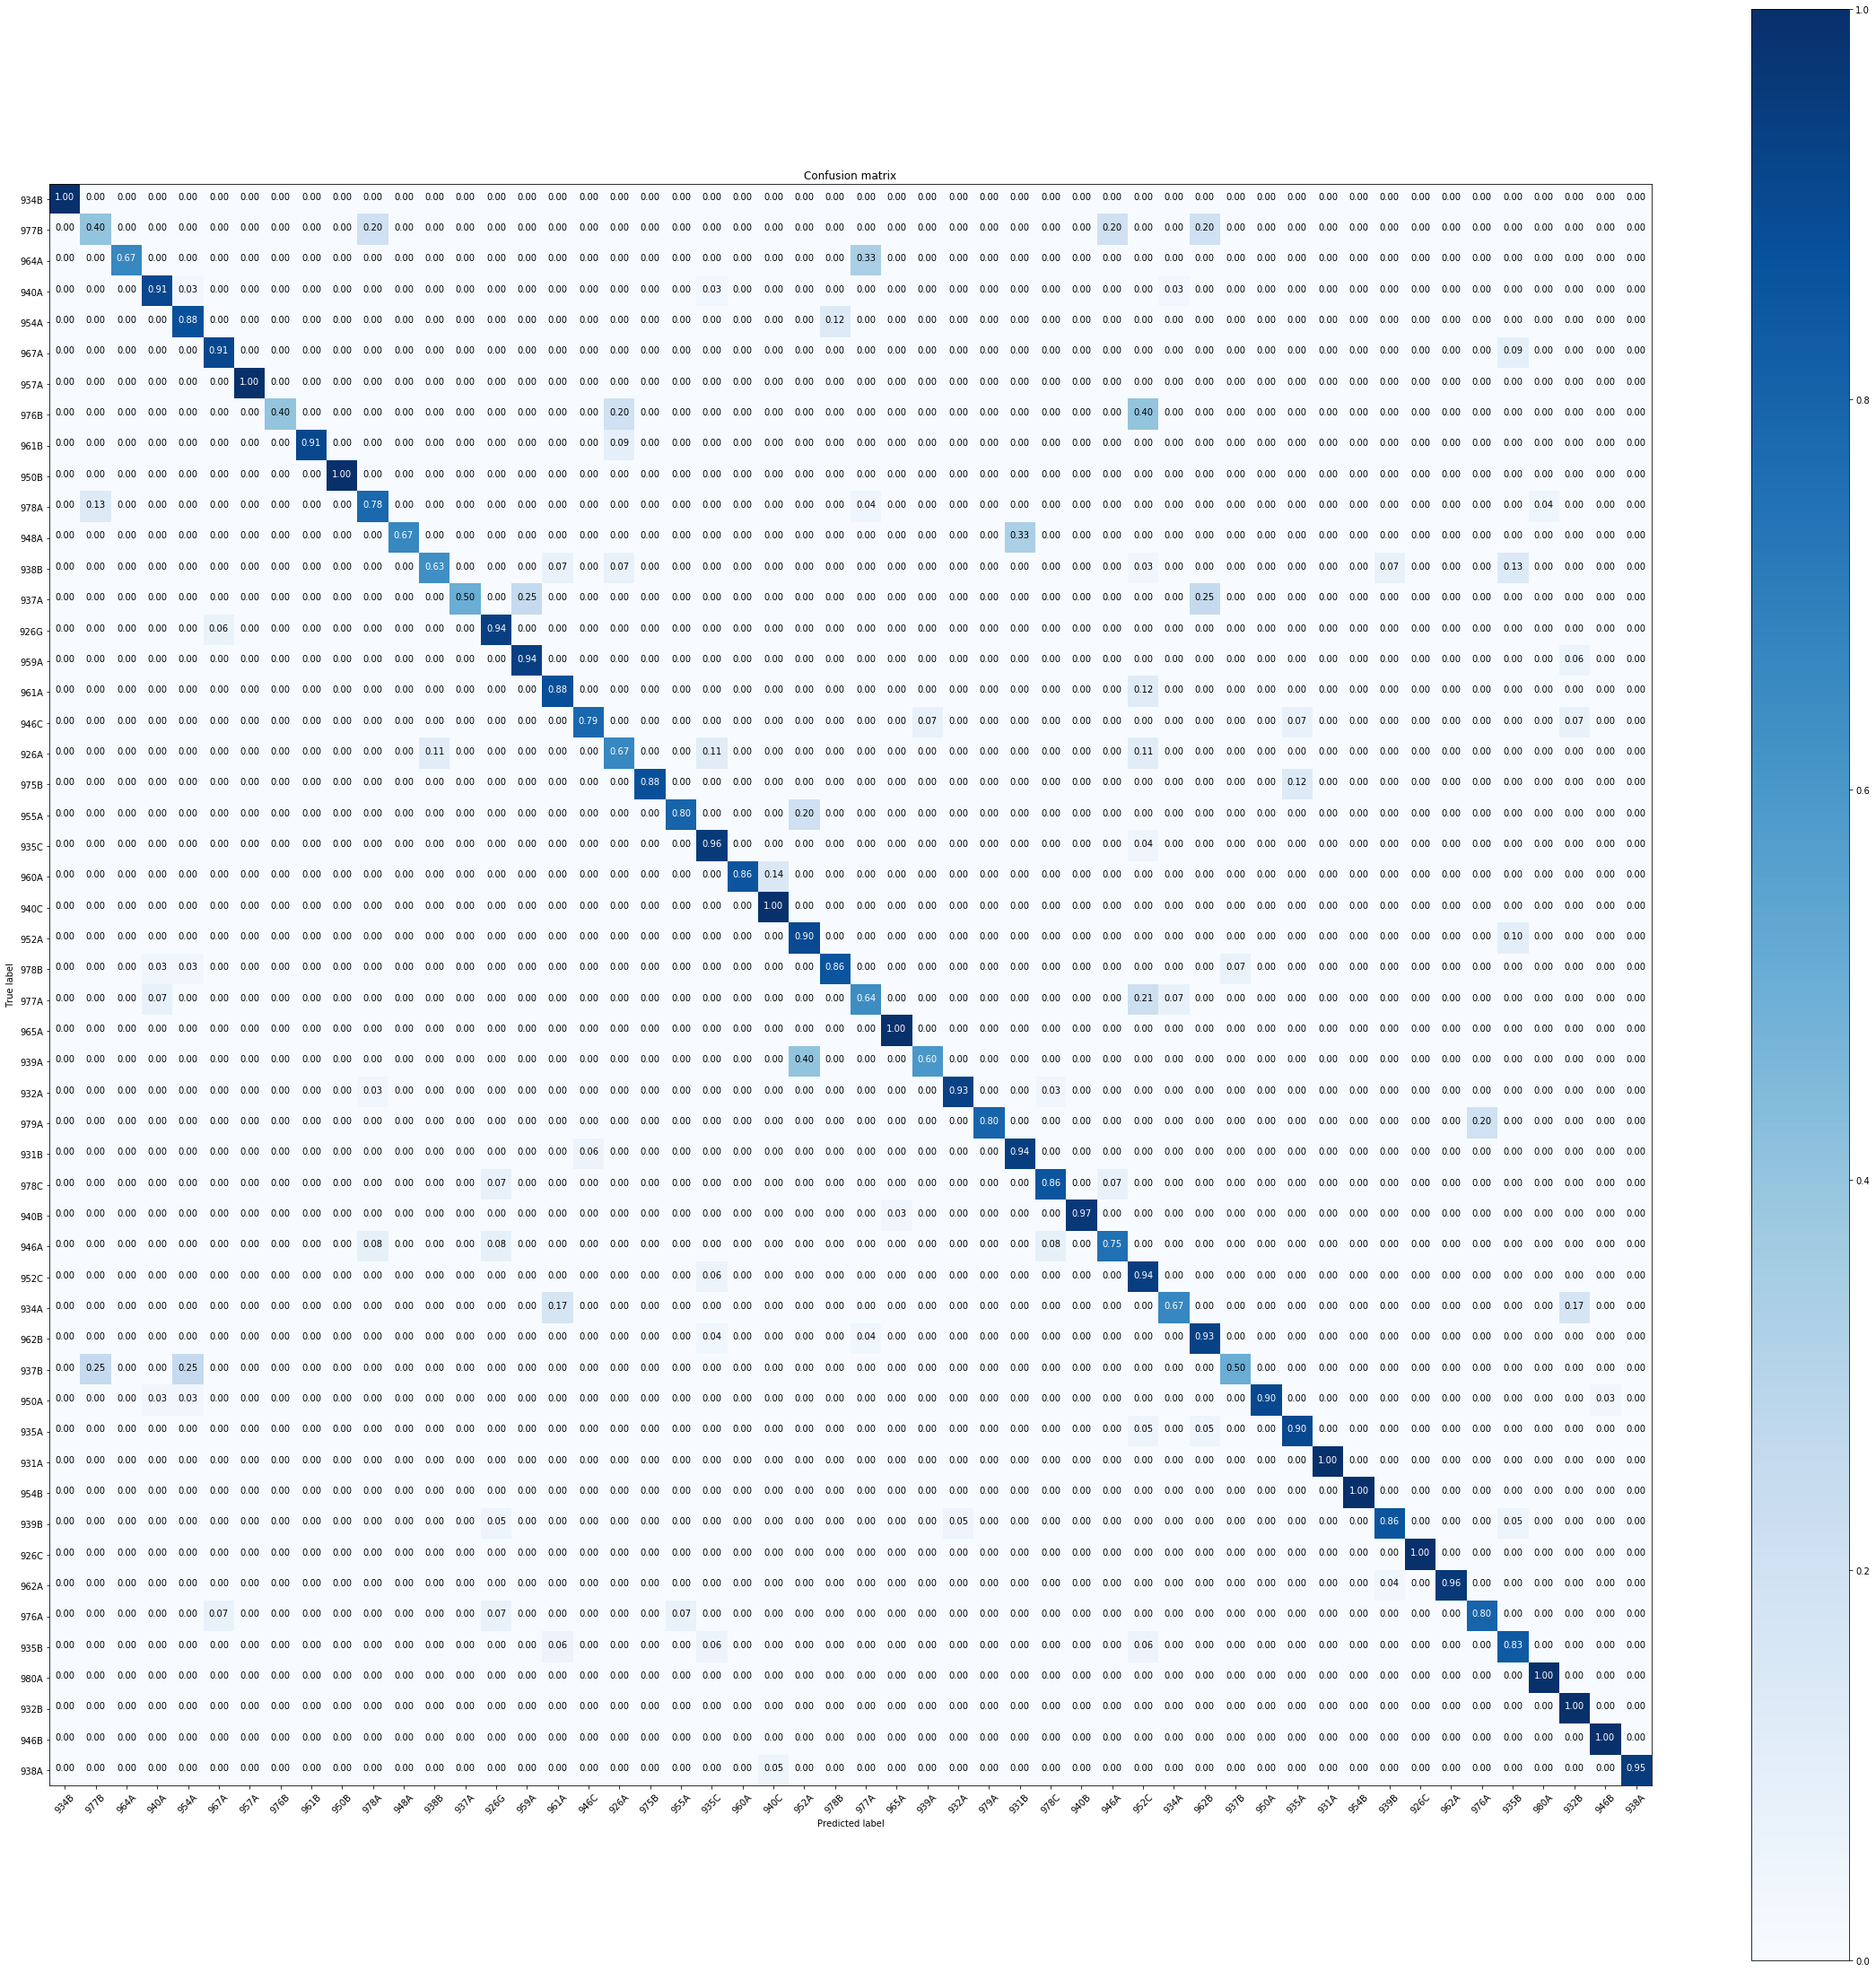

In [1114]:
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op, svm_y_pred_op),set(svm_y_pred_op),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op, dt_y_pred_op),set(dt_y_pred_op),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op, rf_y_pred_op),set(rf_y_pred_op),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op, nn_y_pred_op),set(nn_y_pred_op),normalize=True)

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.4        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.71428571 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.9047619 ]]
Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.8        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.91304348 0.        ]
 [0.         0.         0.         ... 0.         0.         0.80952381]]
Normalized confusion matrix
[[1.         0.         0.  

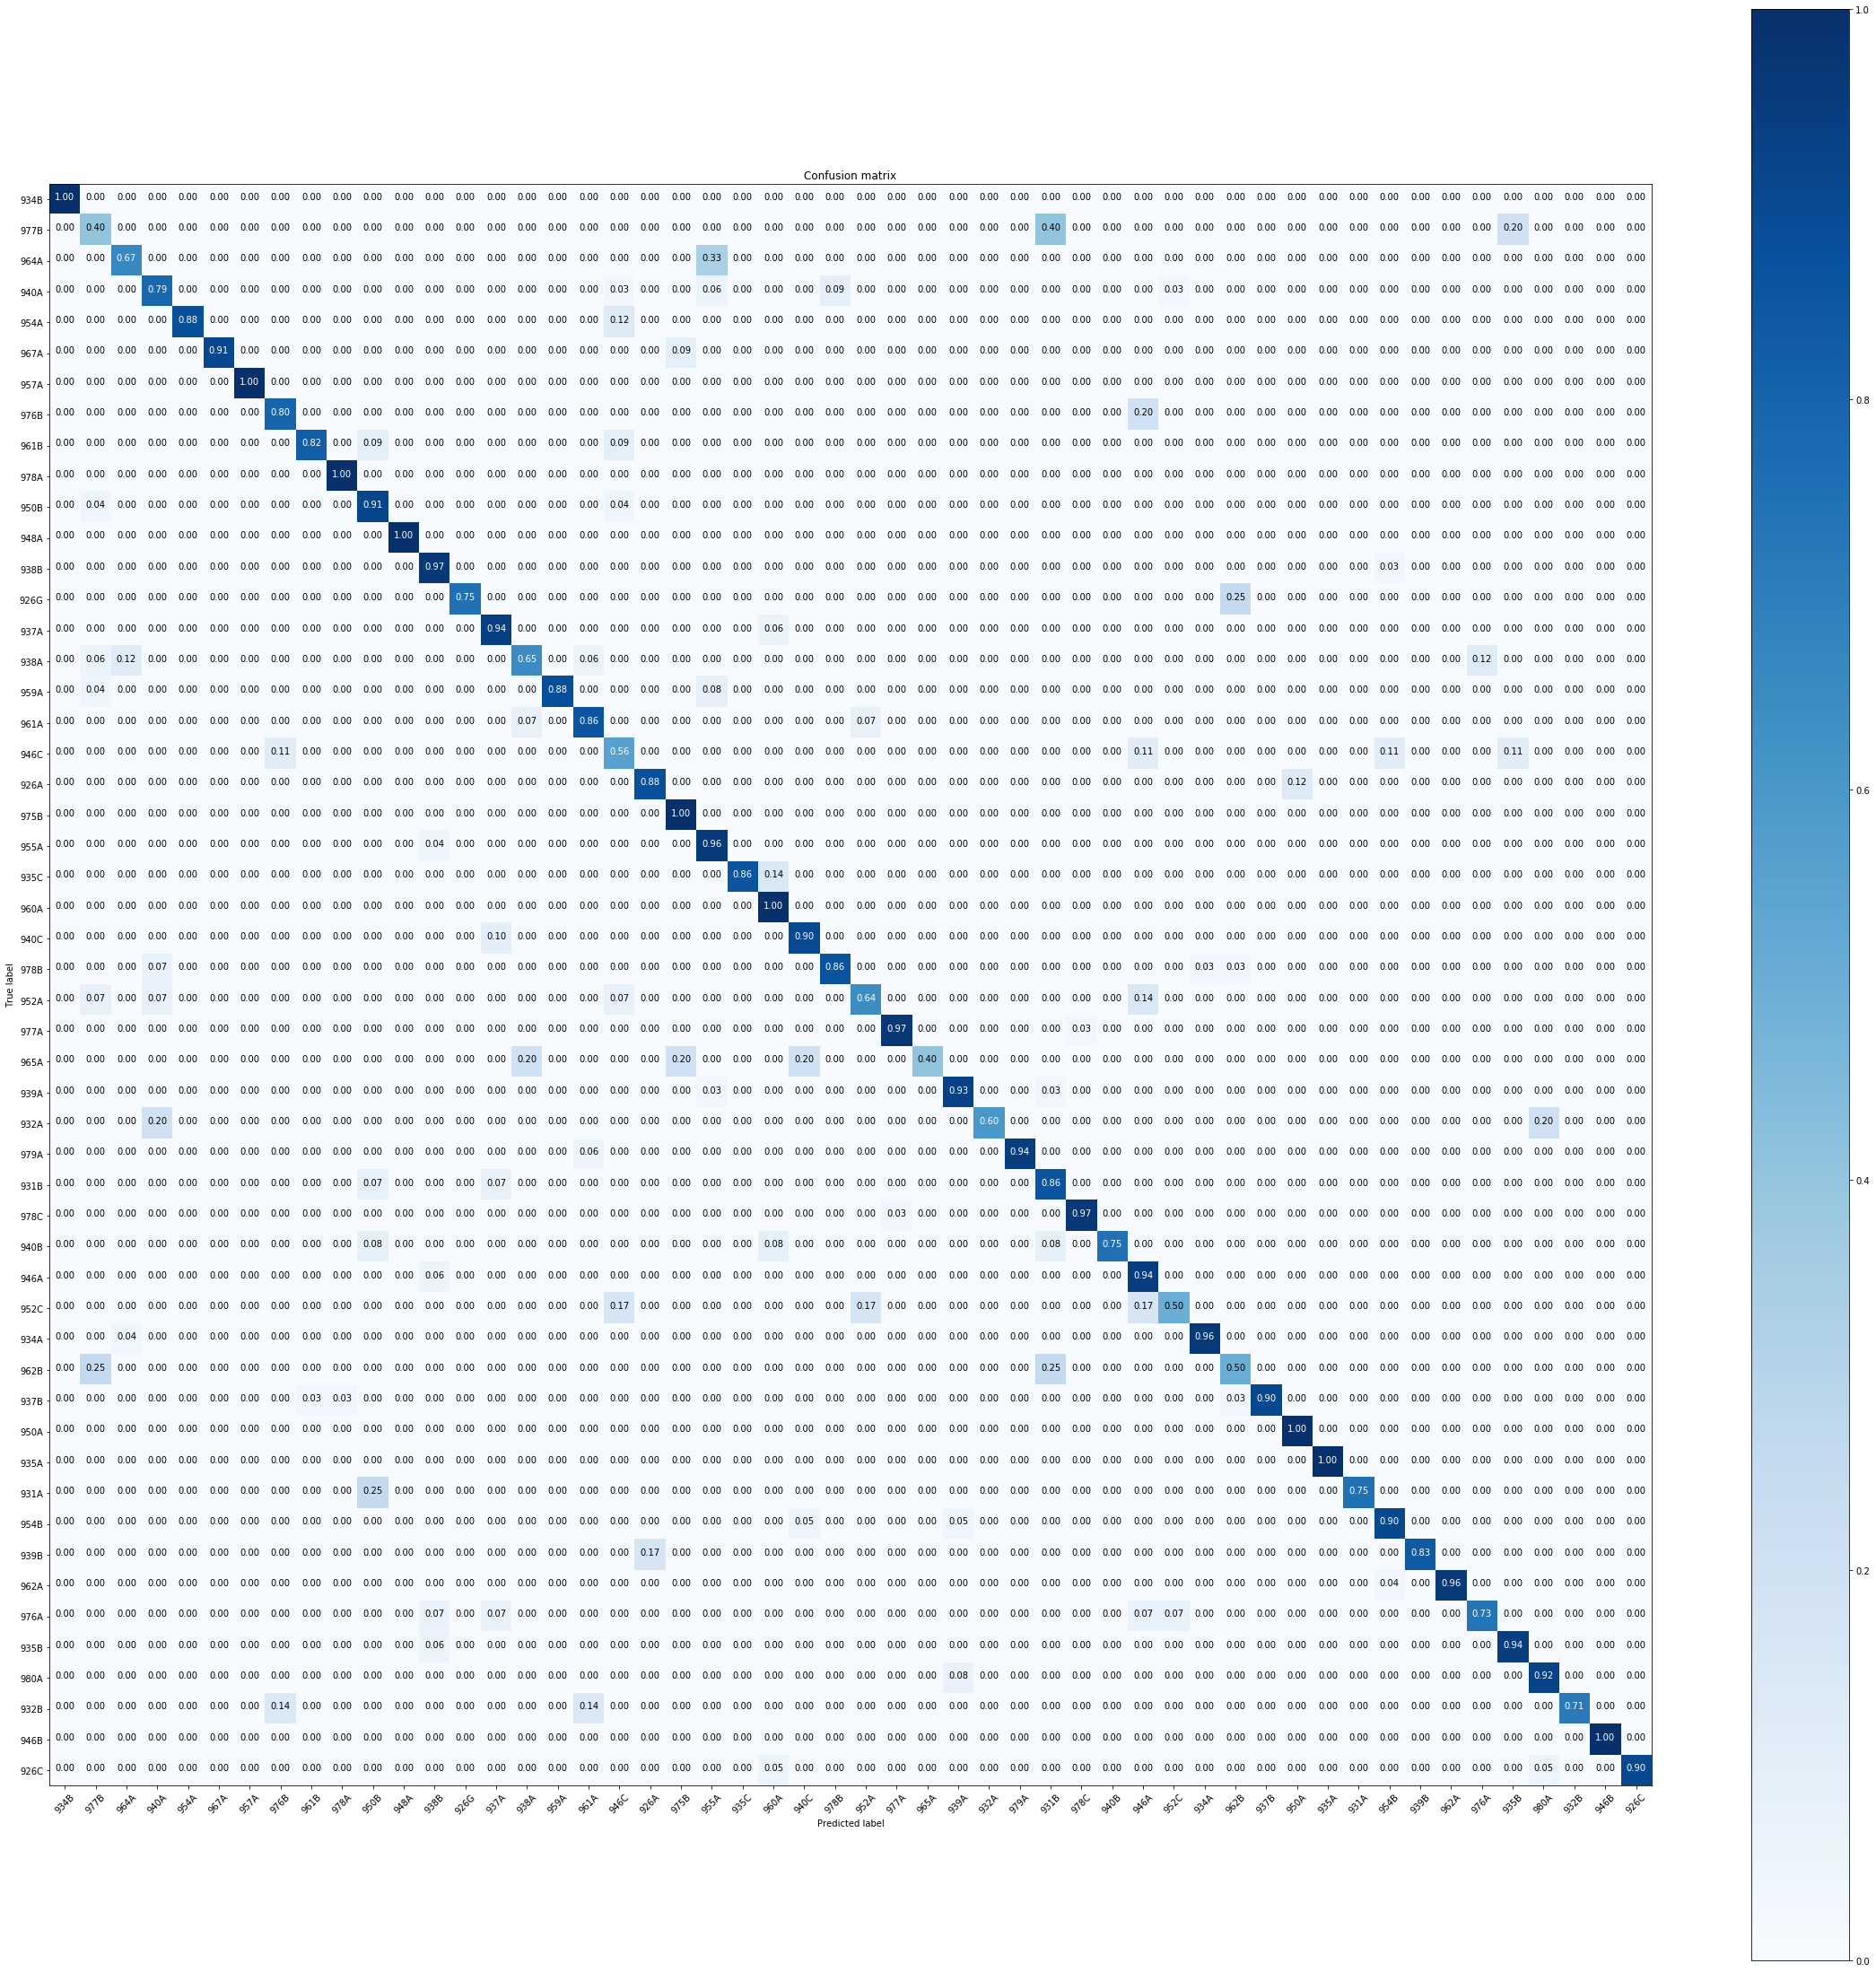

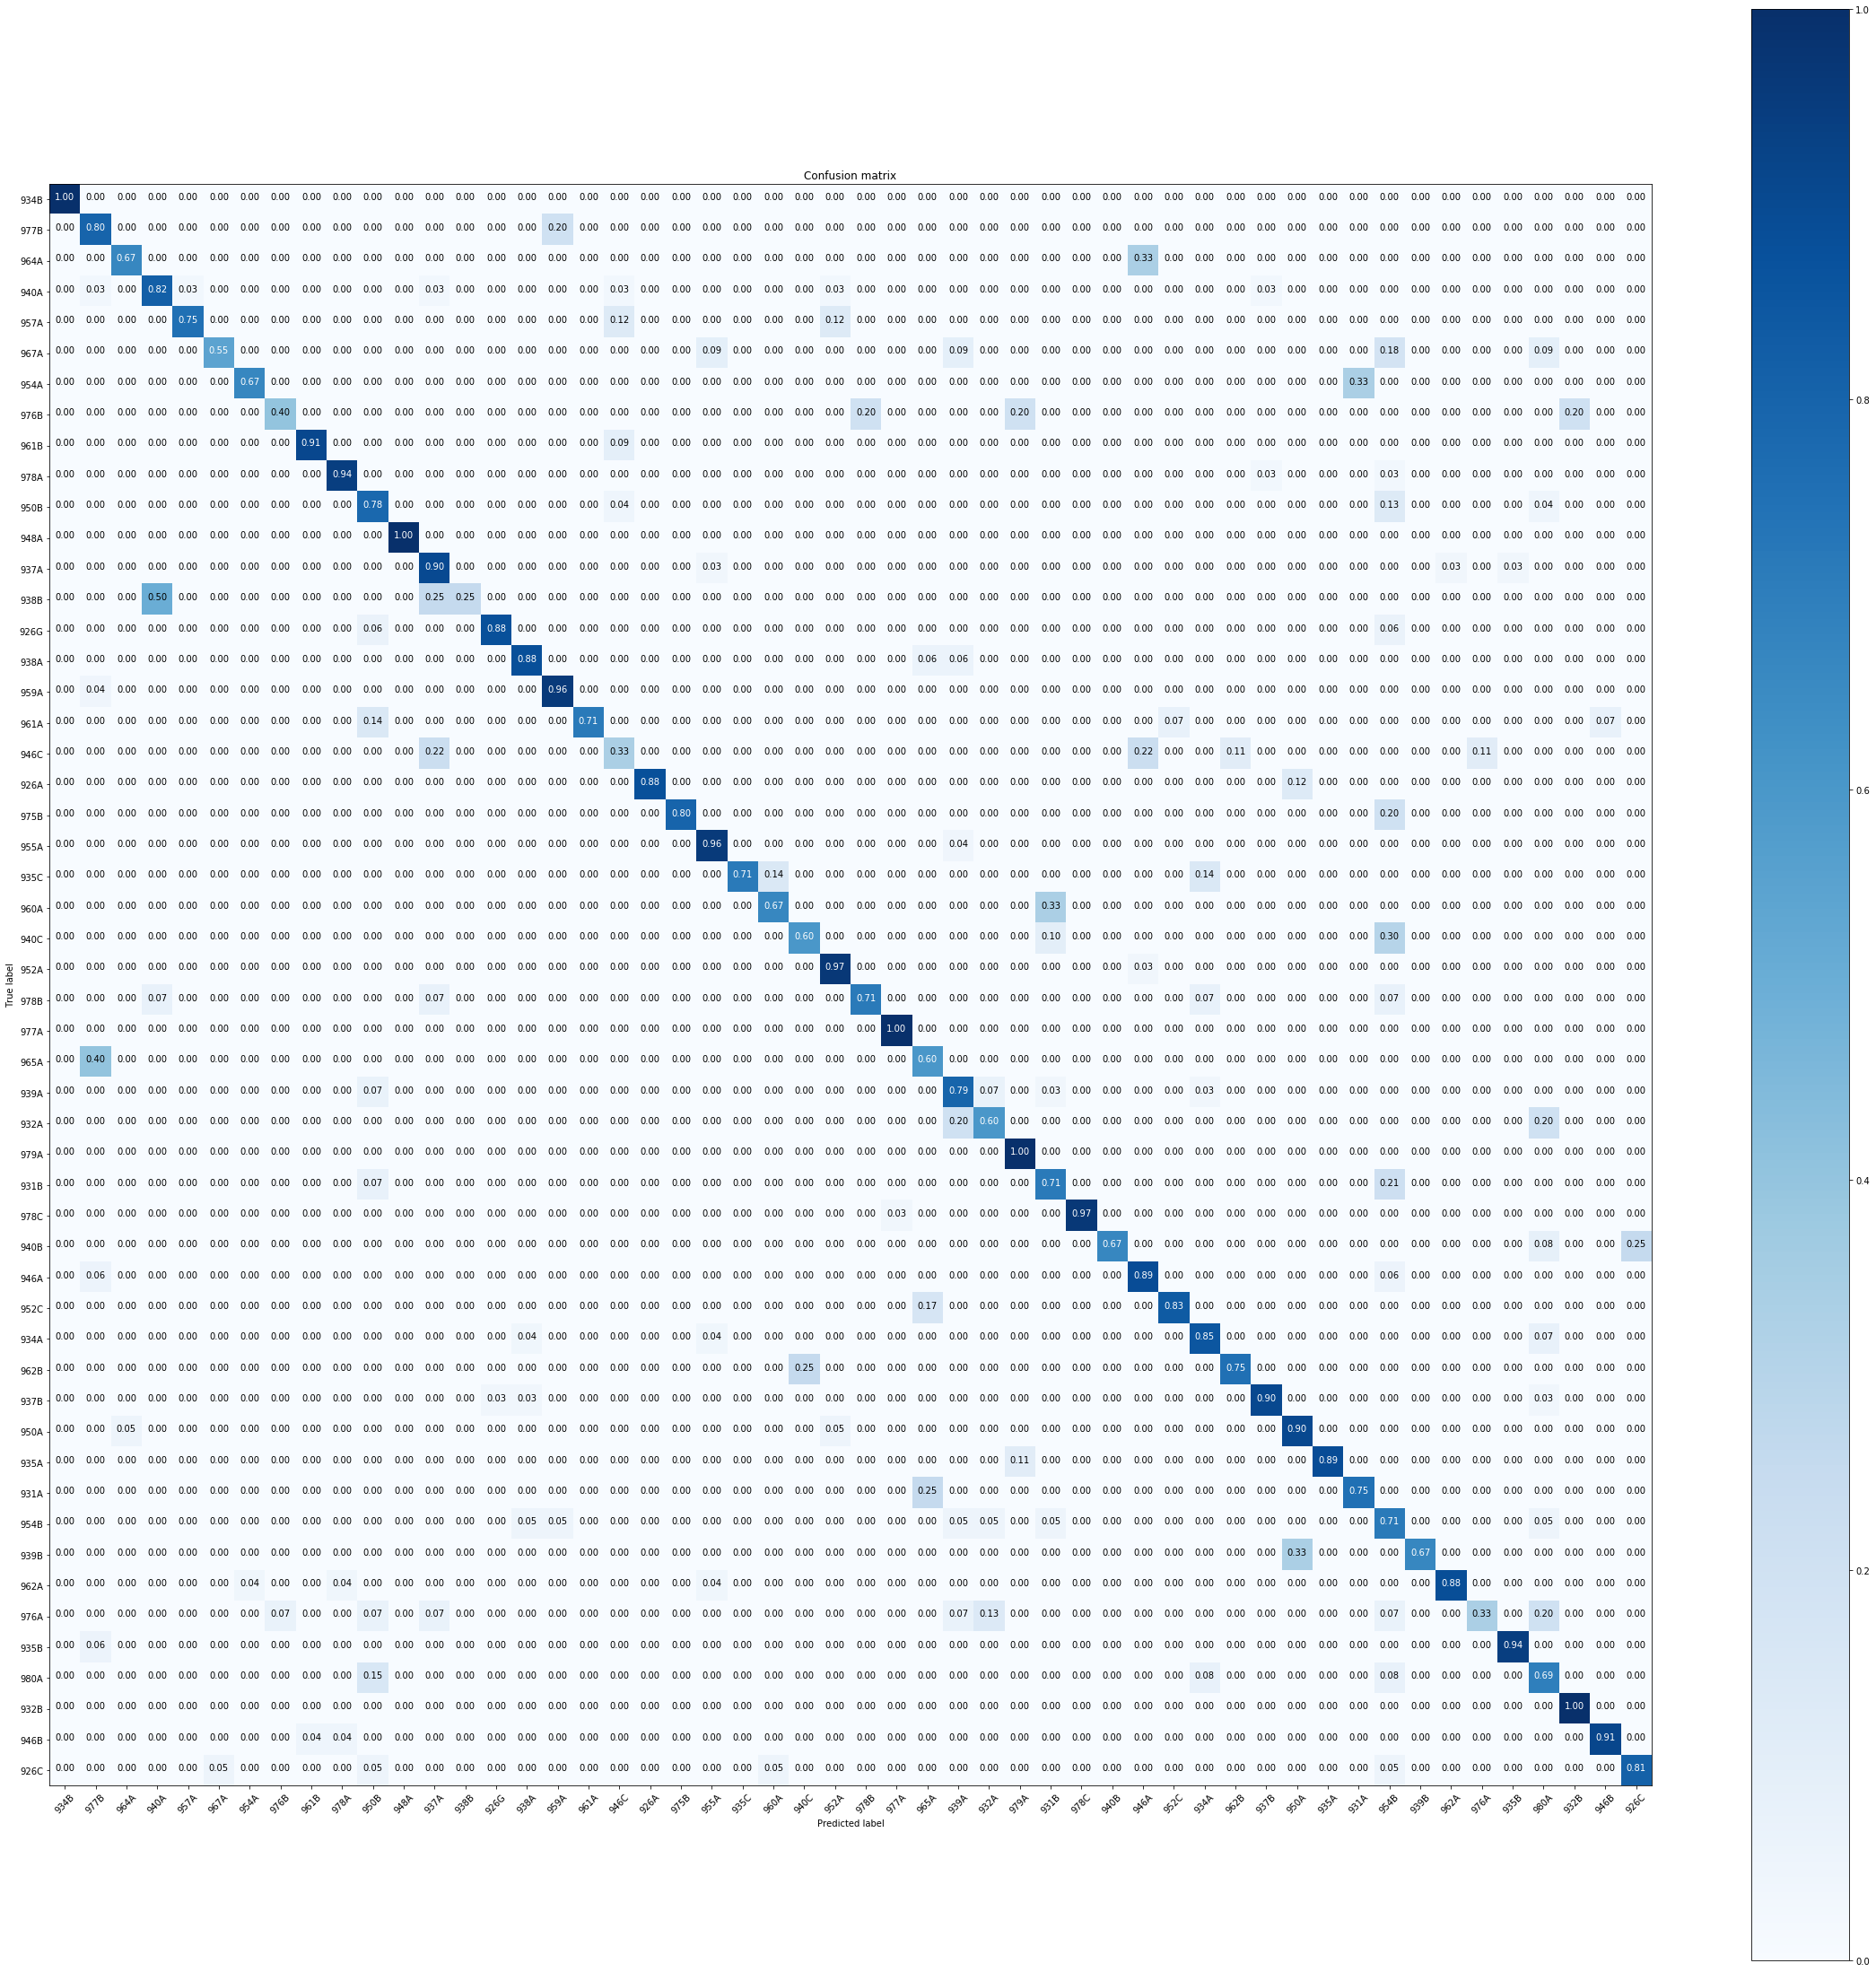

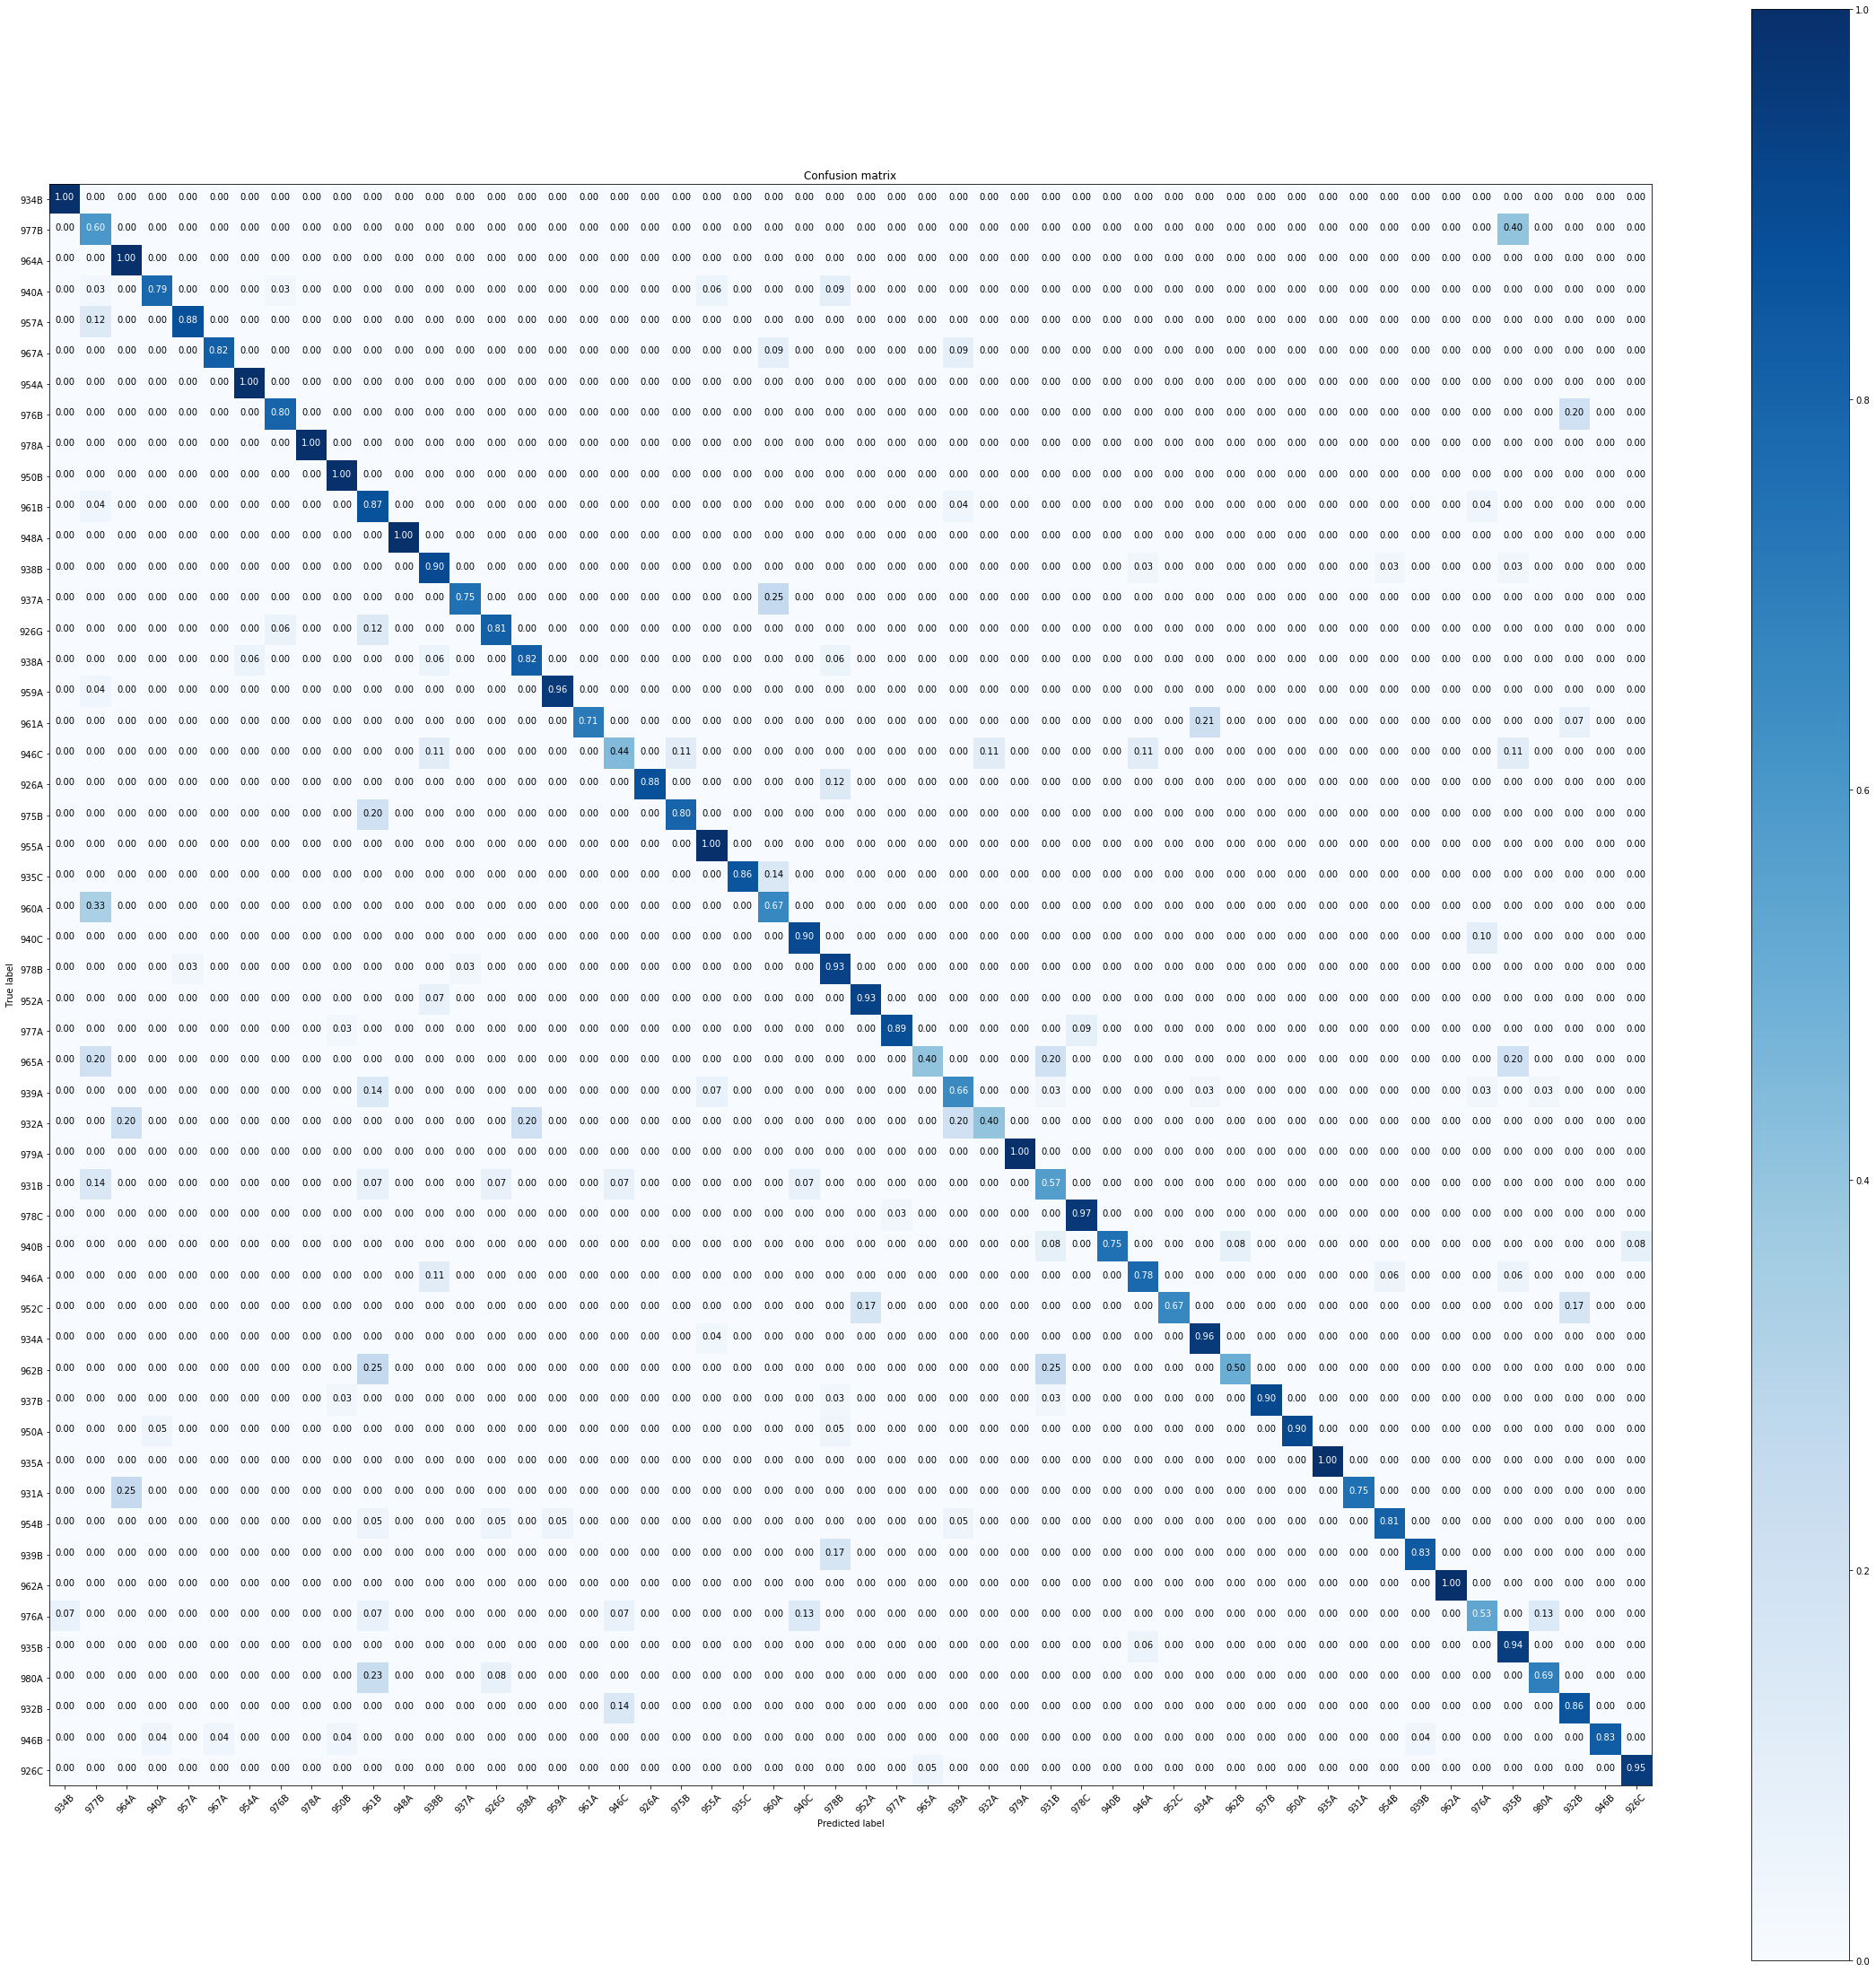

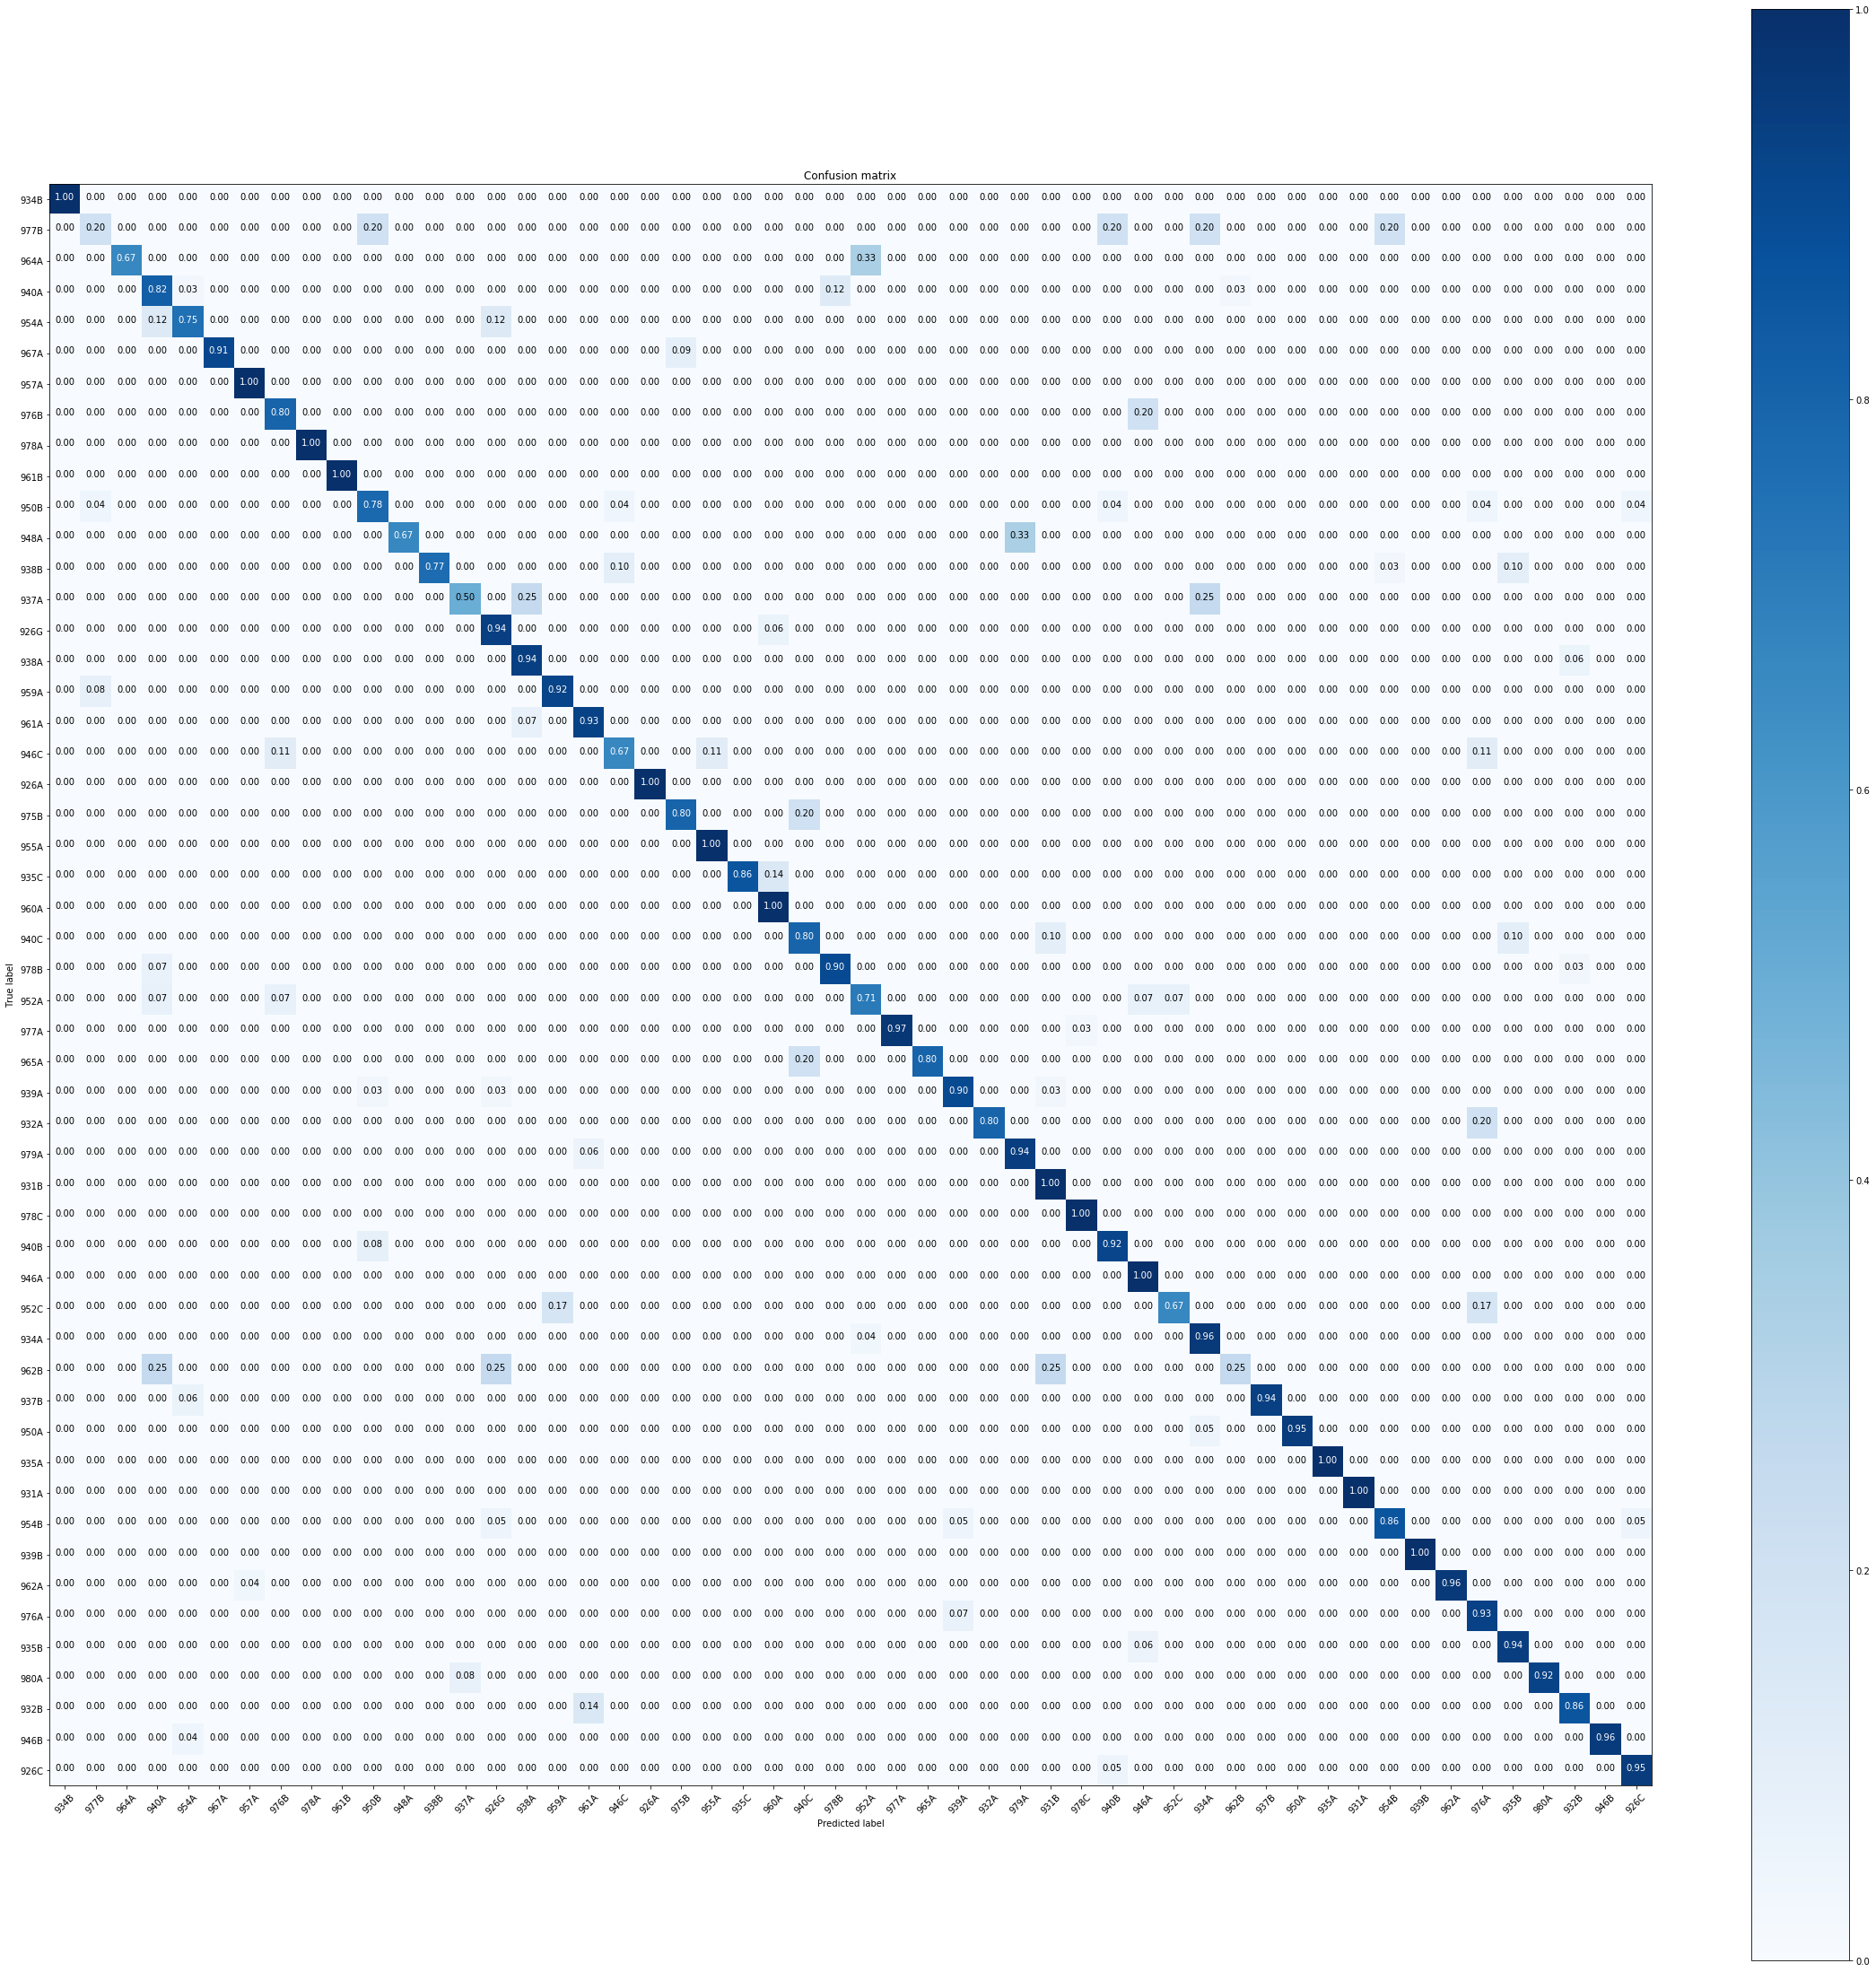

In [1115]:
plot_confusion_matrix(metrics.confusion_matrix(y_validate_ansii, svm_y_pred_ansii),set(svm_y_pred_ansii),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_ansii, dt_y_pred_ansii),set(dt_y_pred_ansii),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_ansii, rf_y_pred_ansii),set(rf_y_pred_ansii),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_ansii, nn_y_pred_ansii),set(nn_y_pred_ansii),normalize=True)

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.2        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.71428571 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.9047619 ]]
Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.6        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.86956522 0.        ]
 [0.         0.         0.         ... 0.         0.         0.76190476]]
Normalized confusion matrix
[[1.         0.         0.  

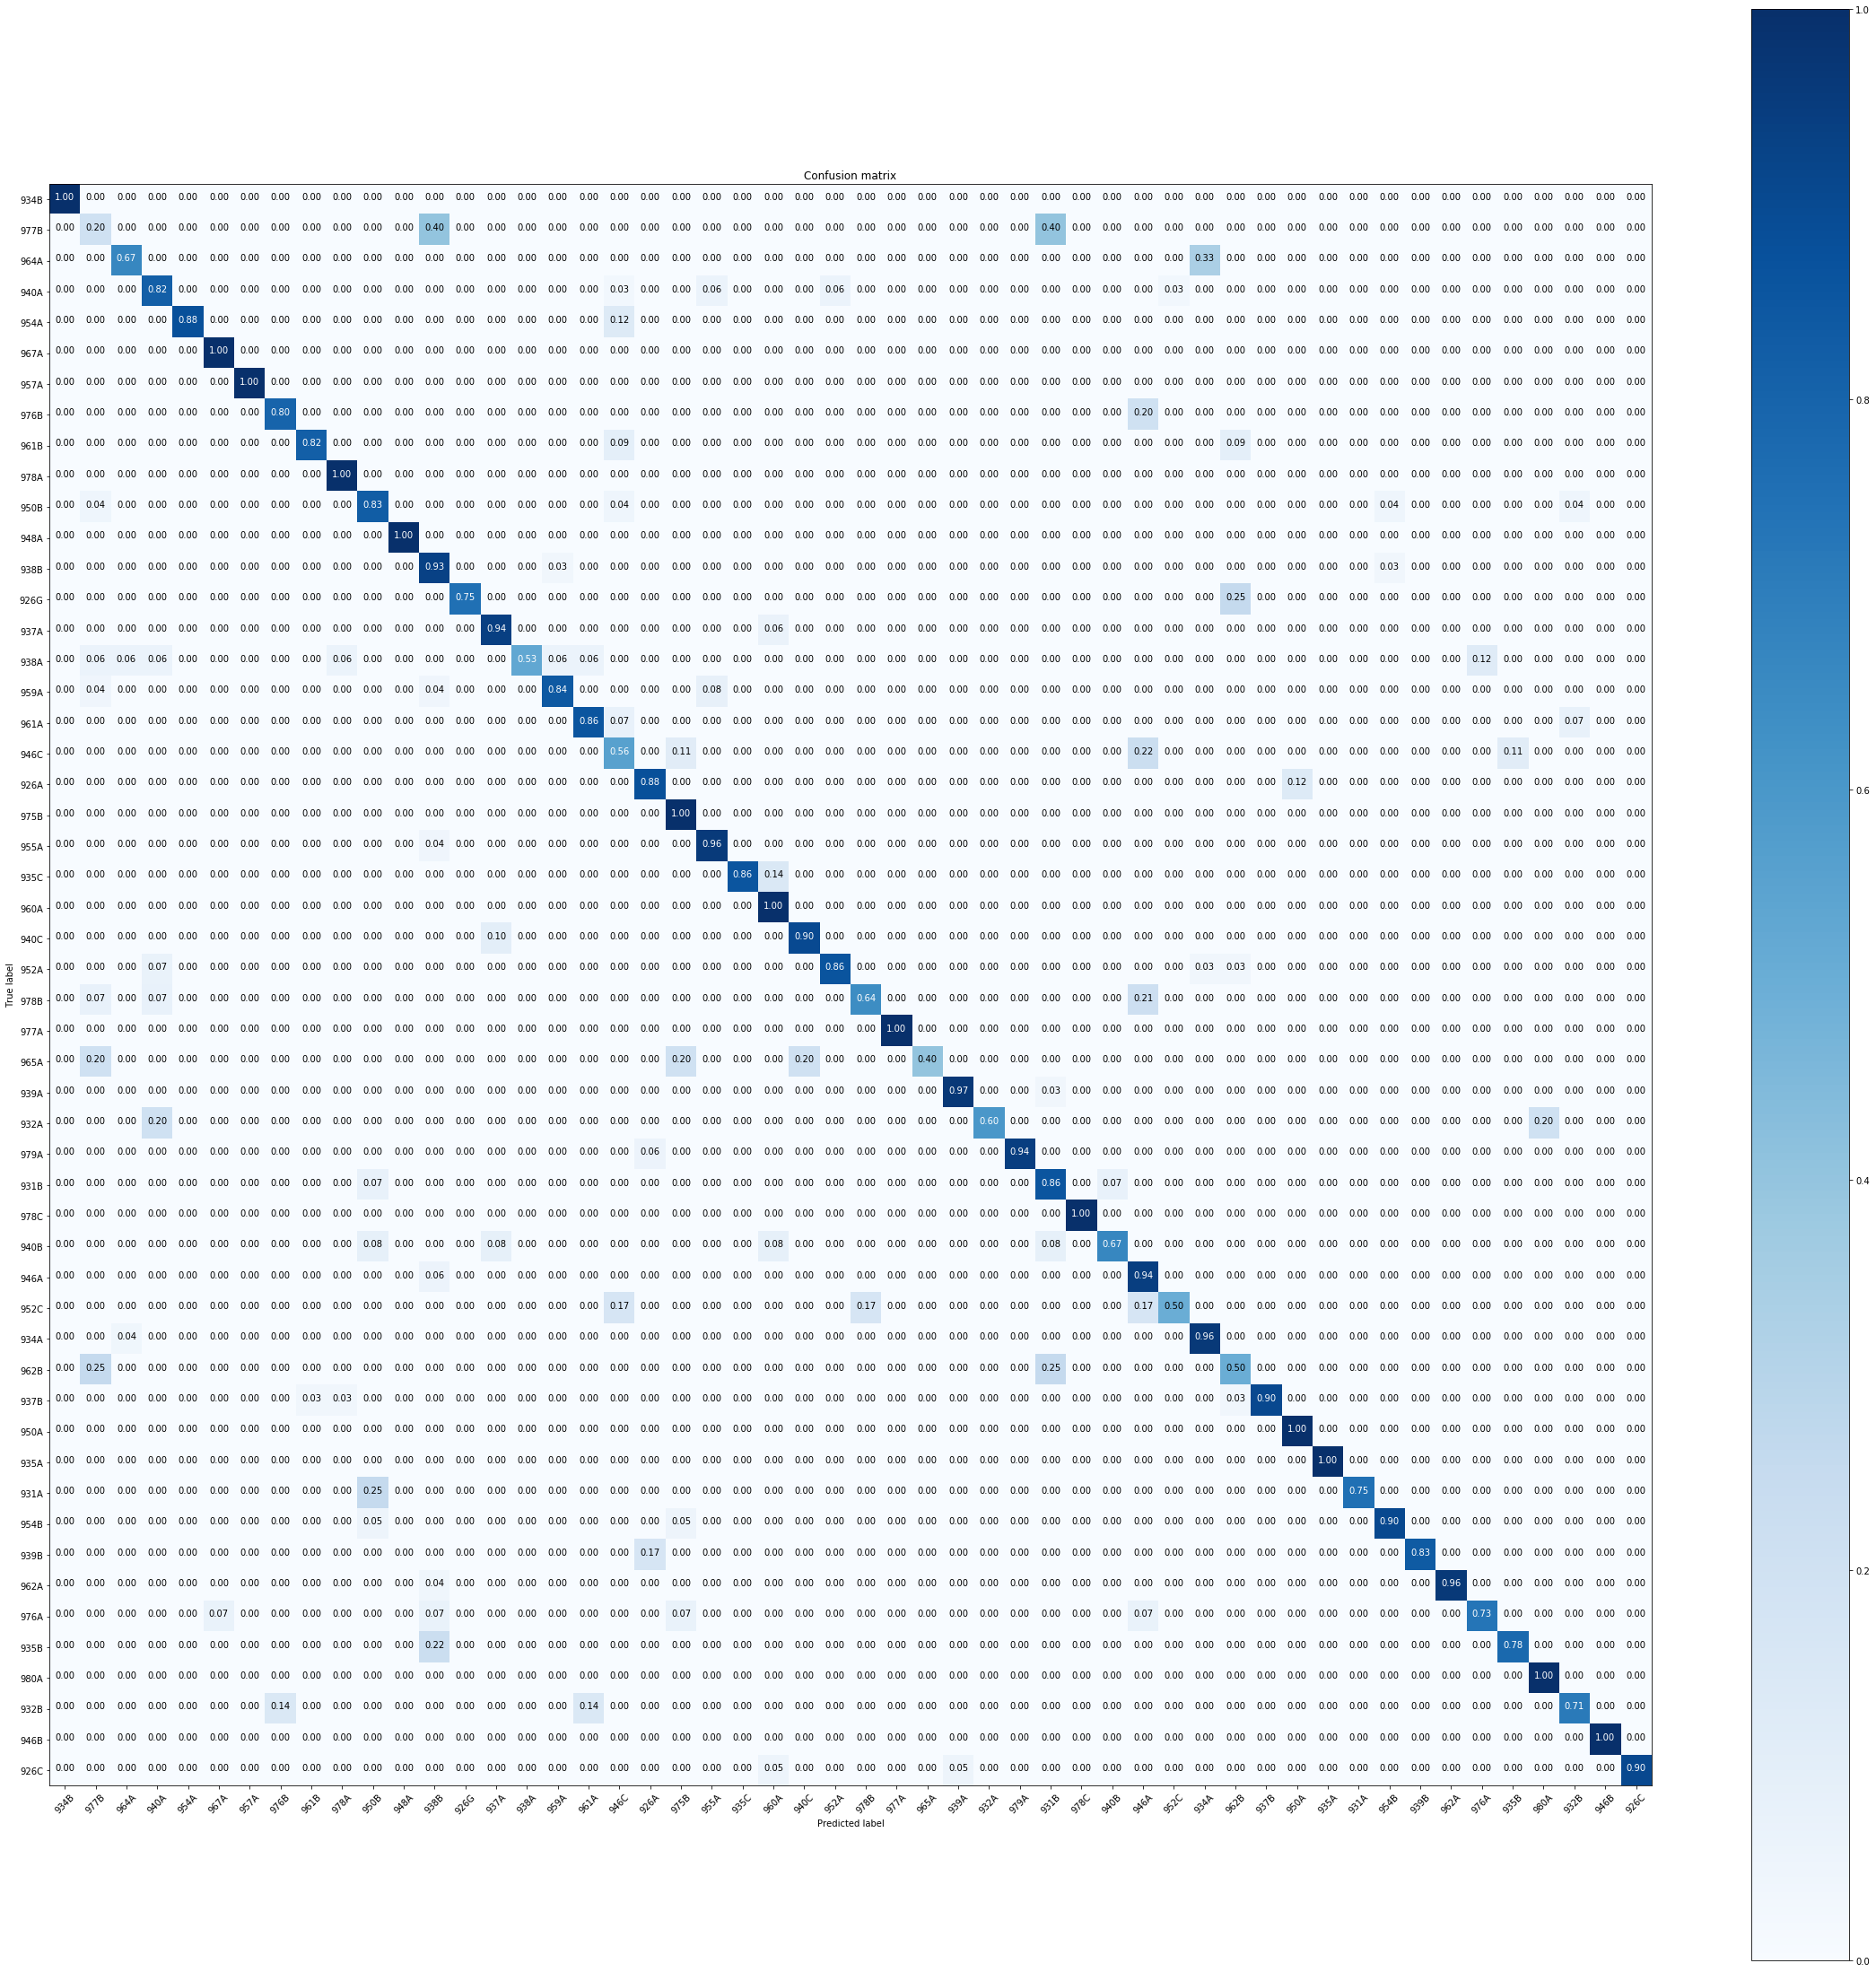

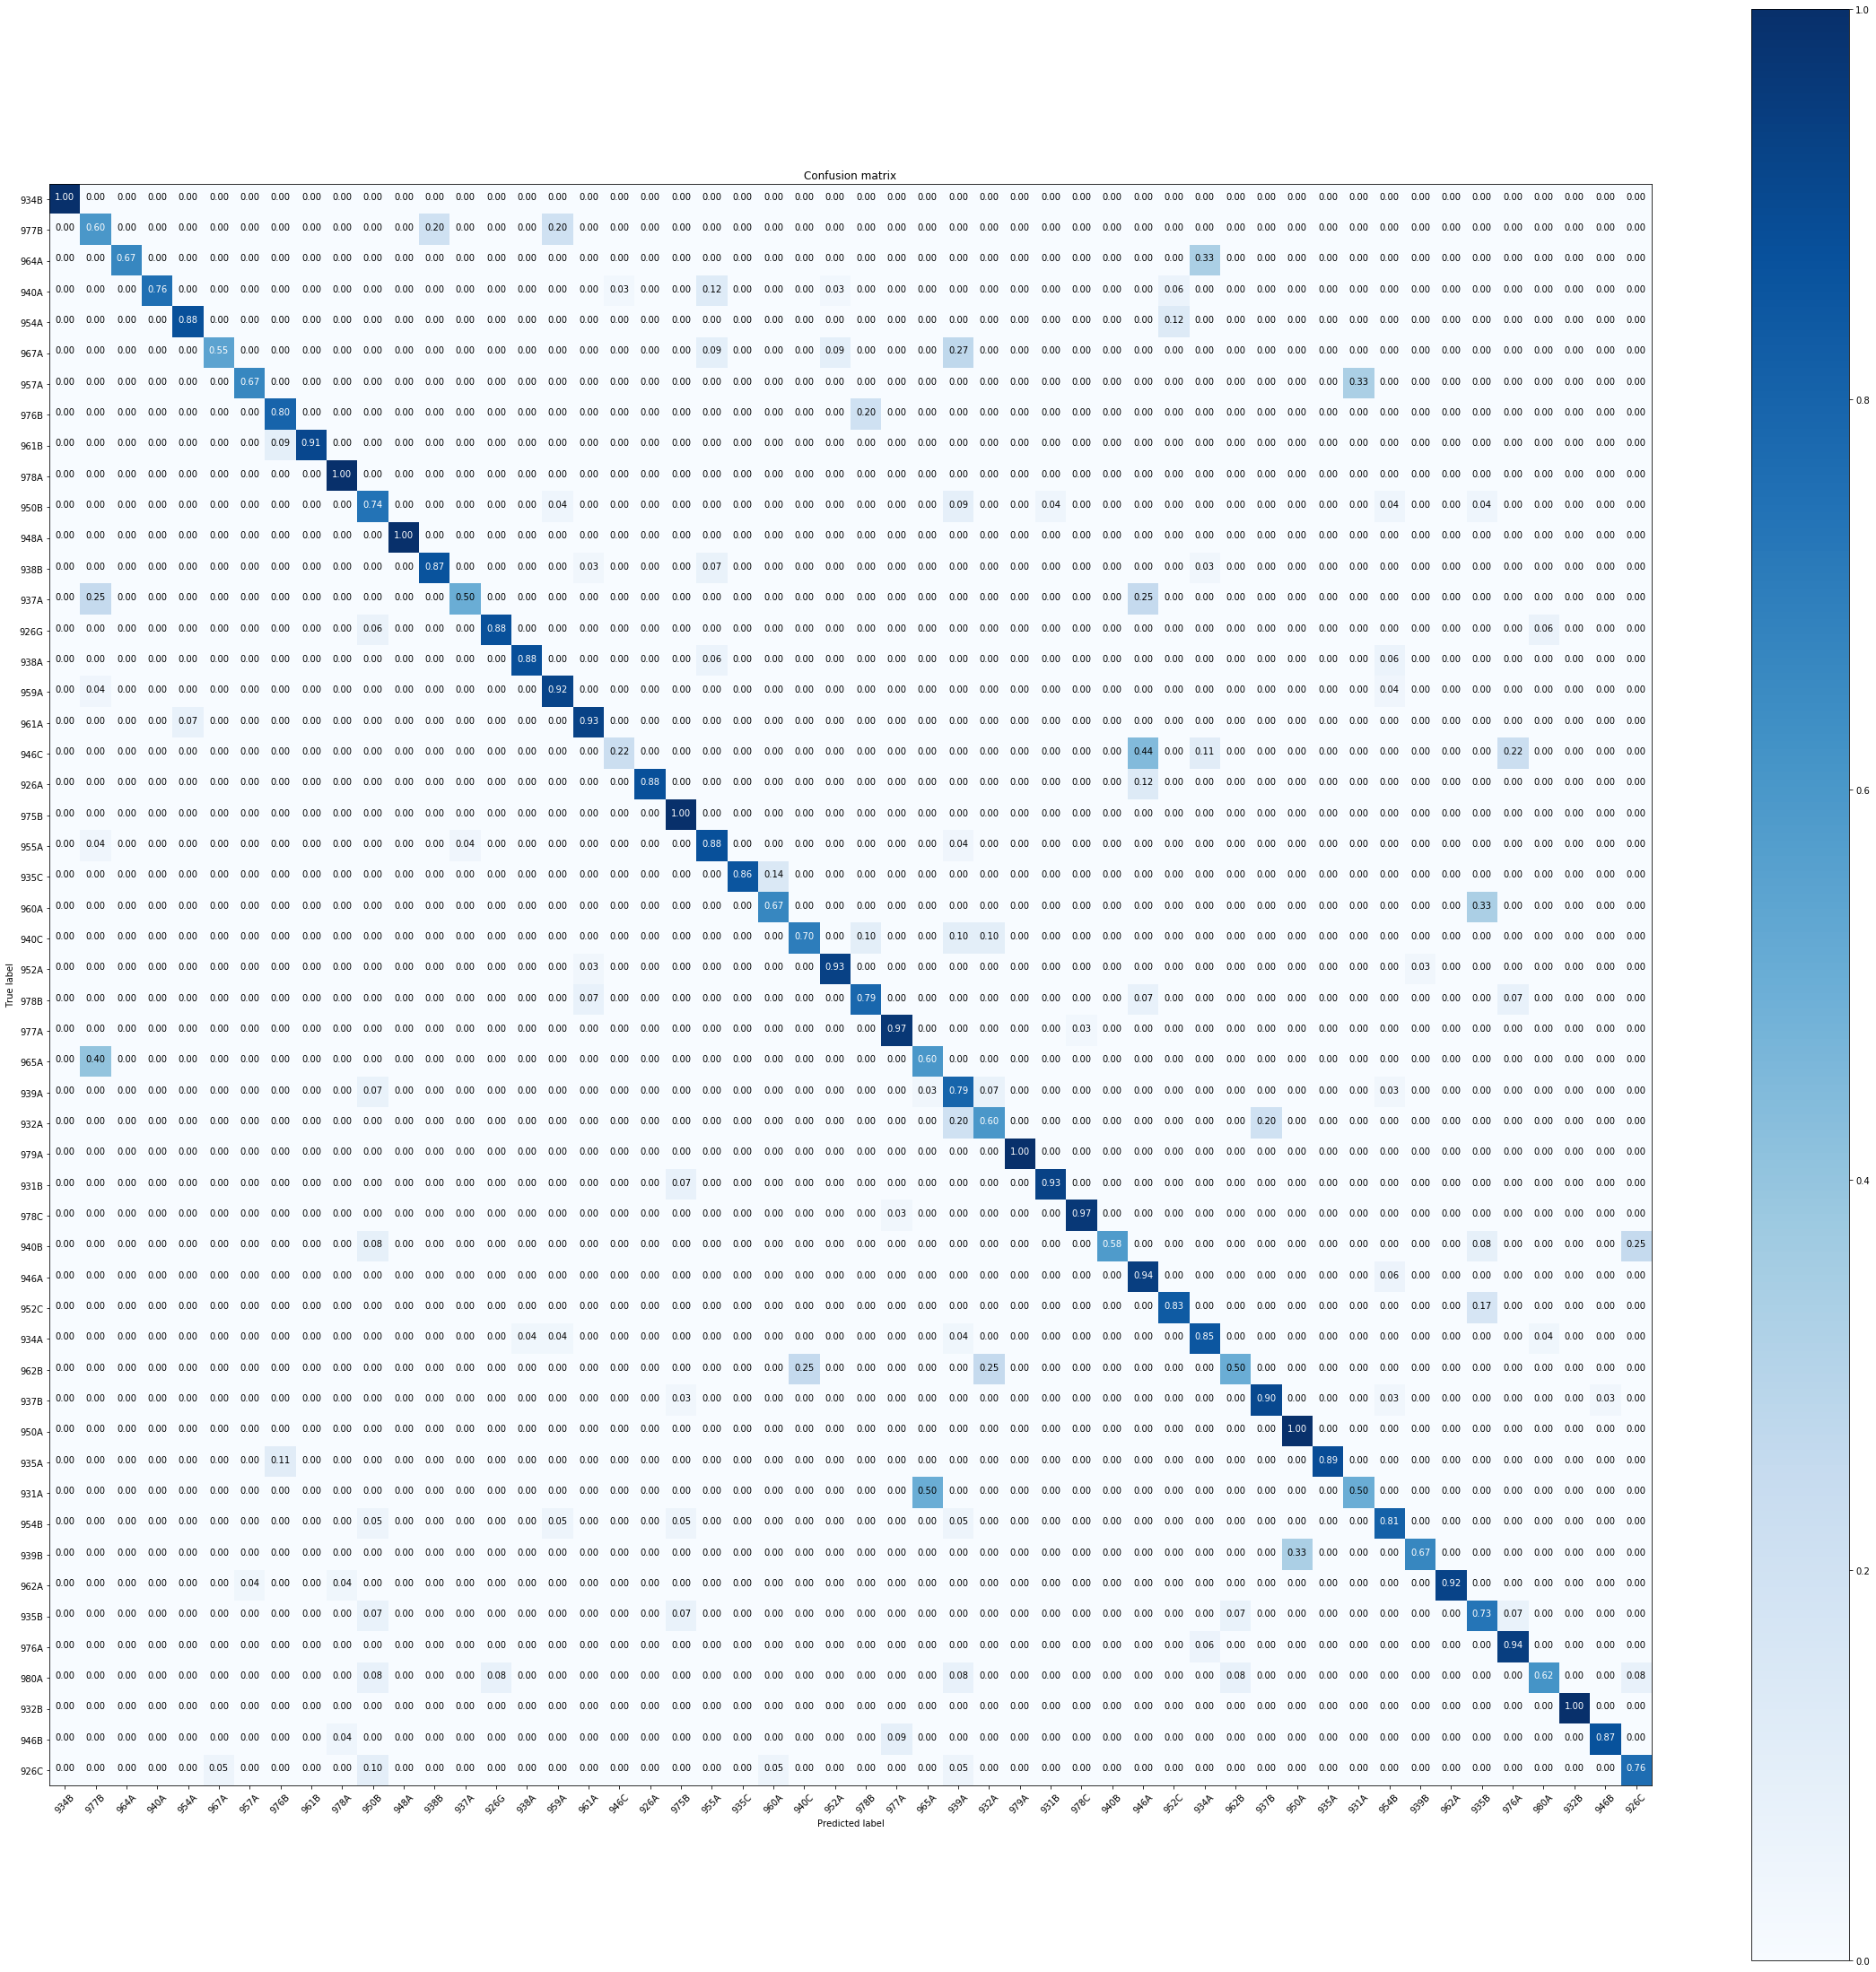

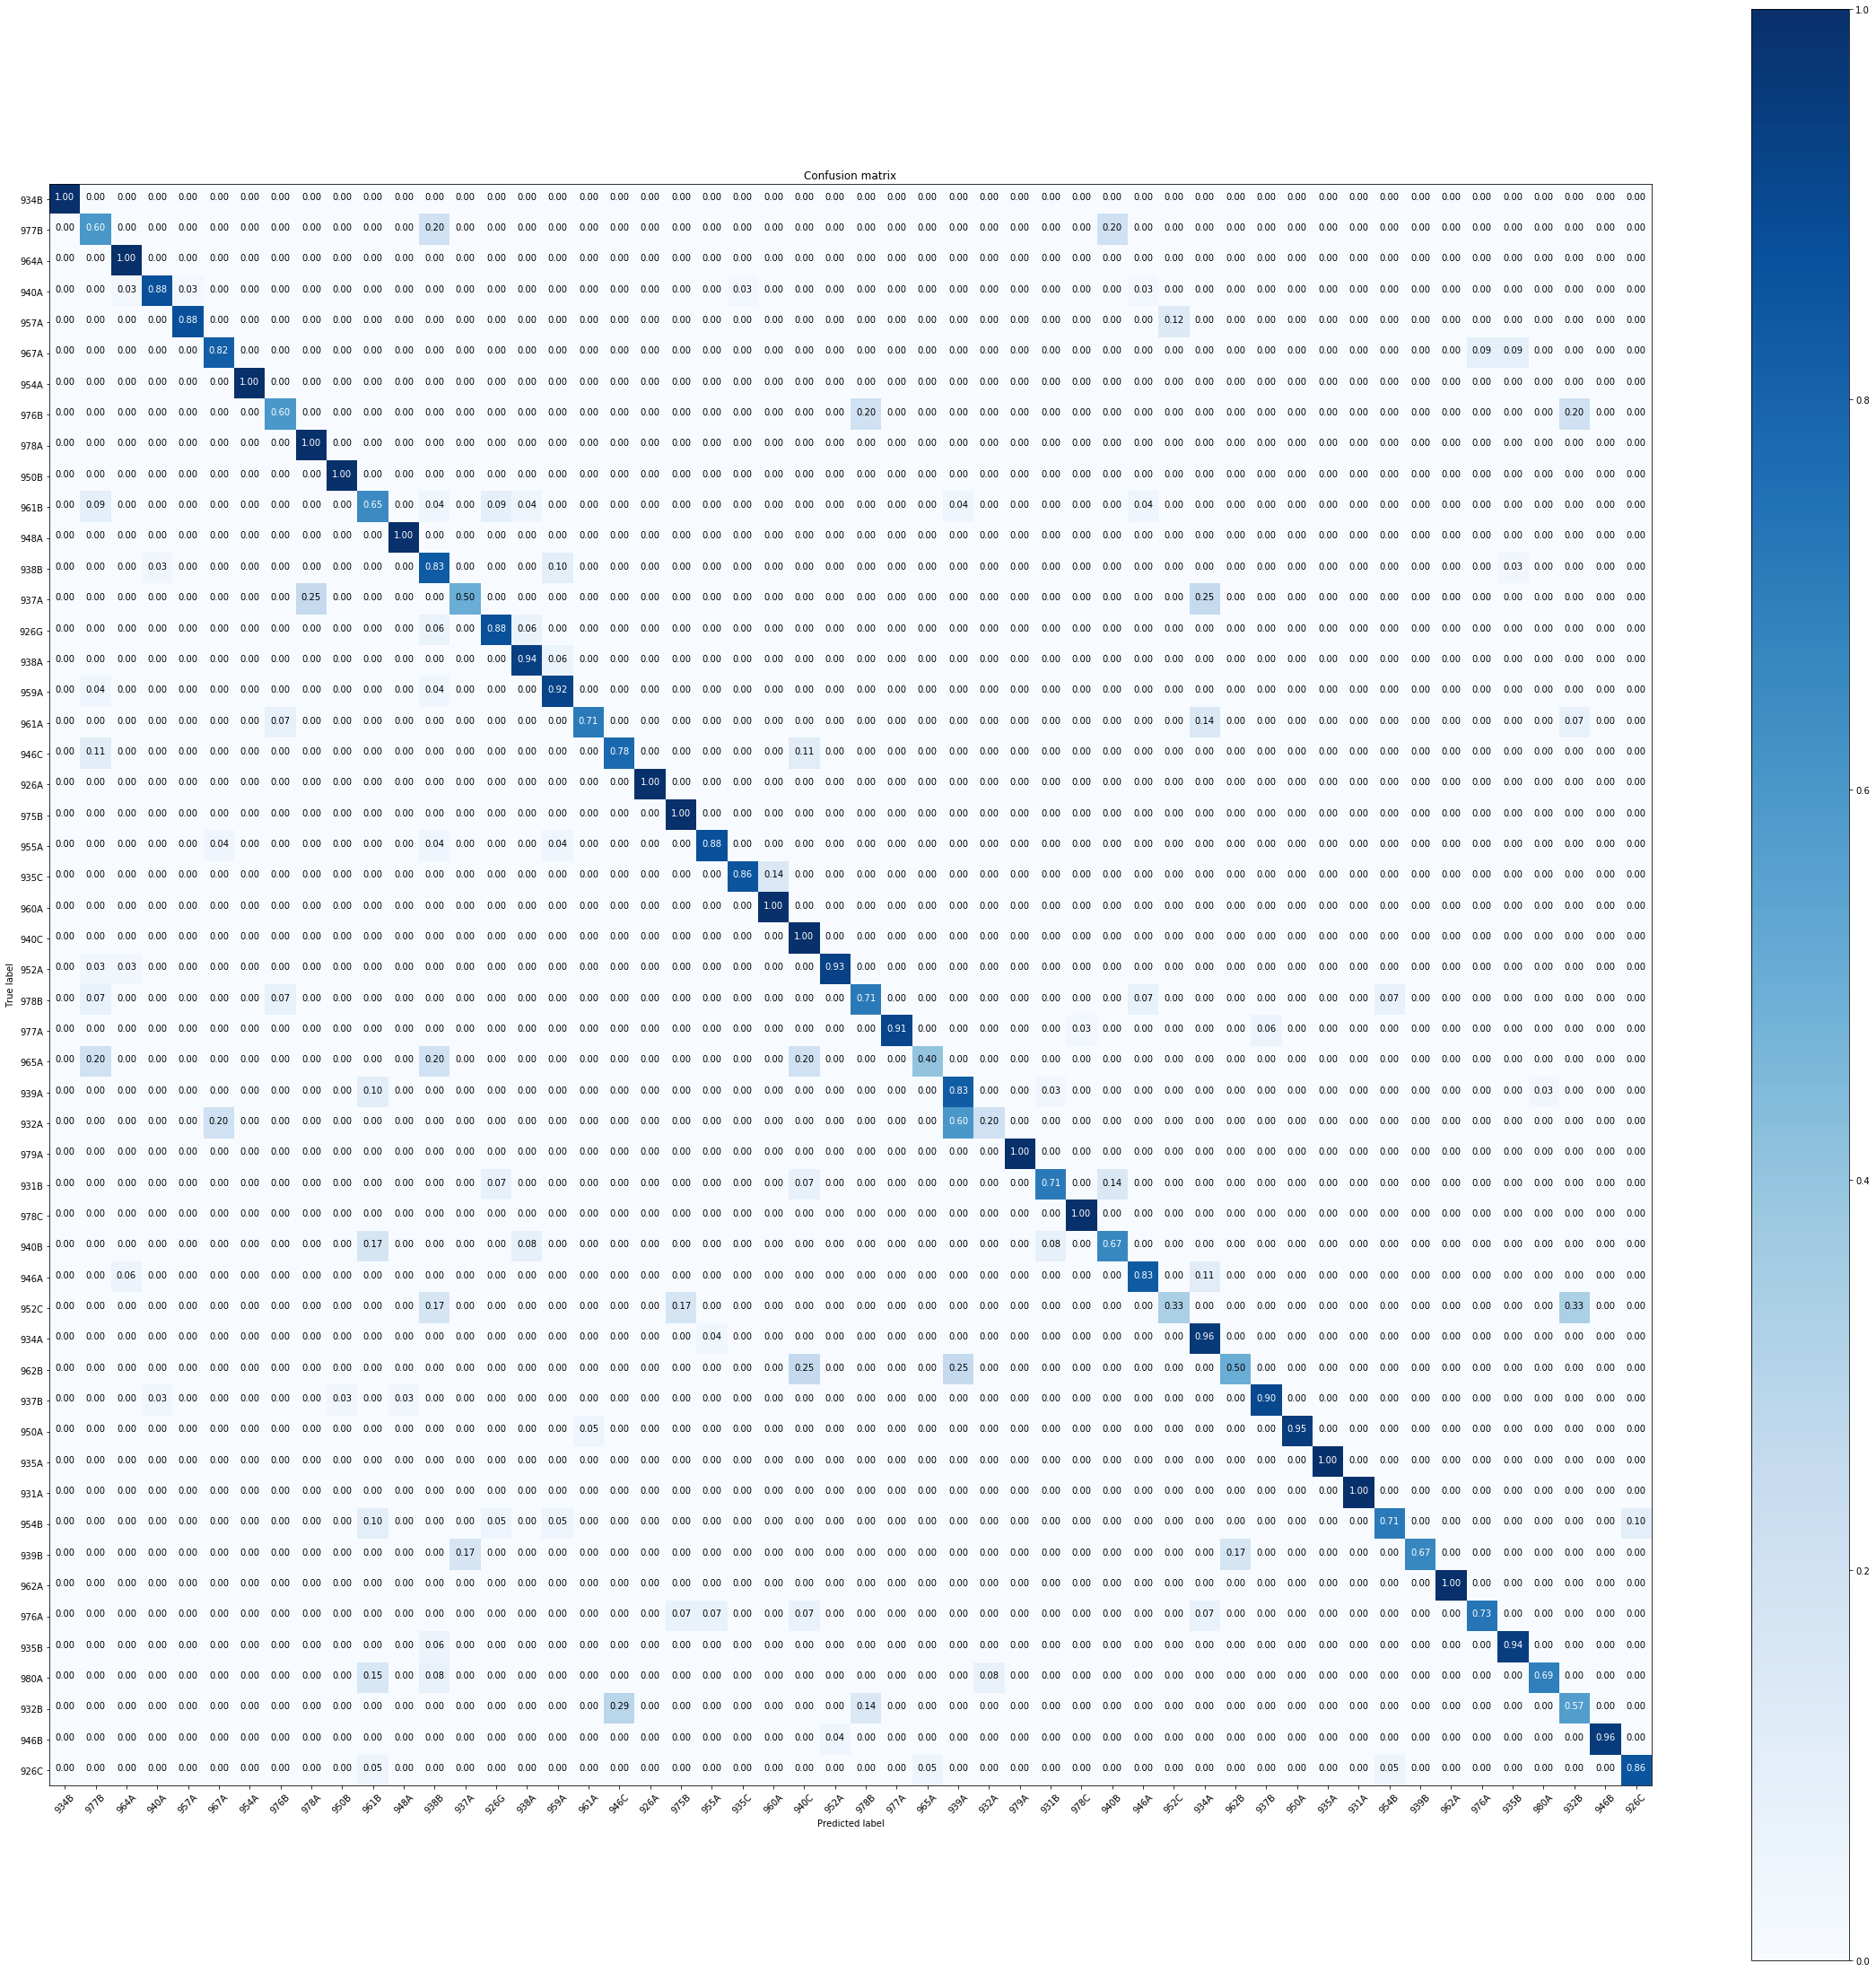

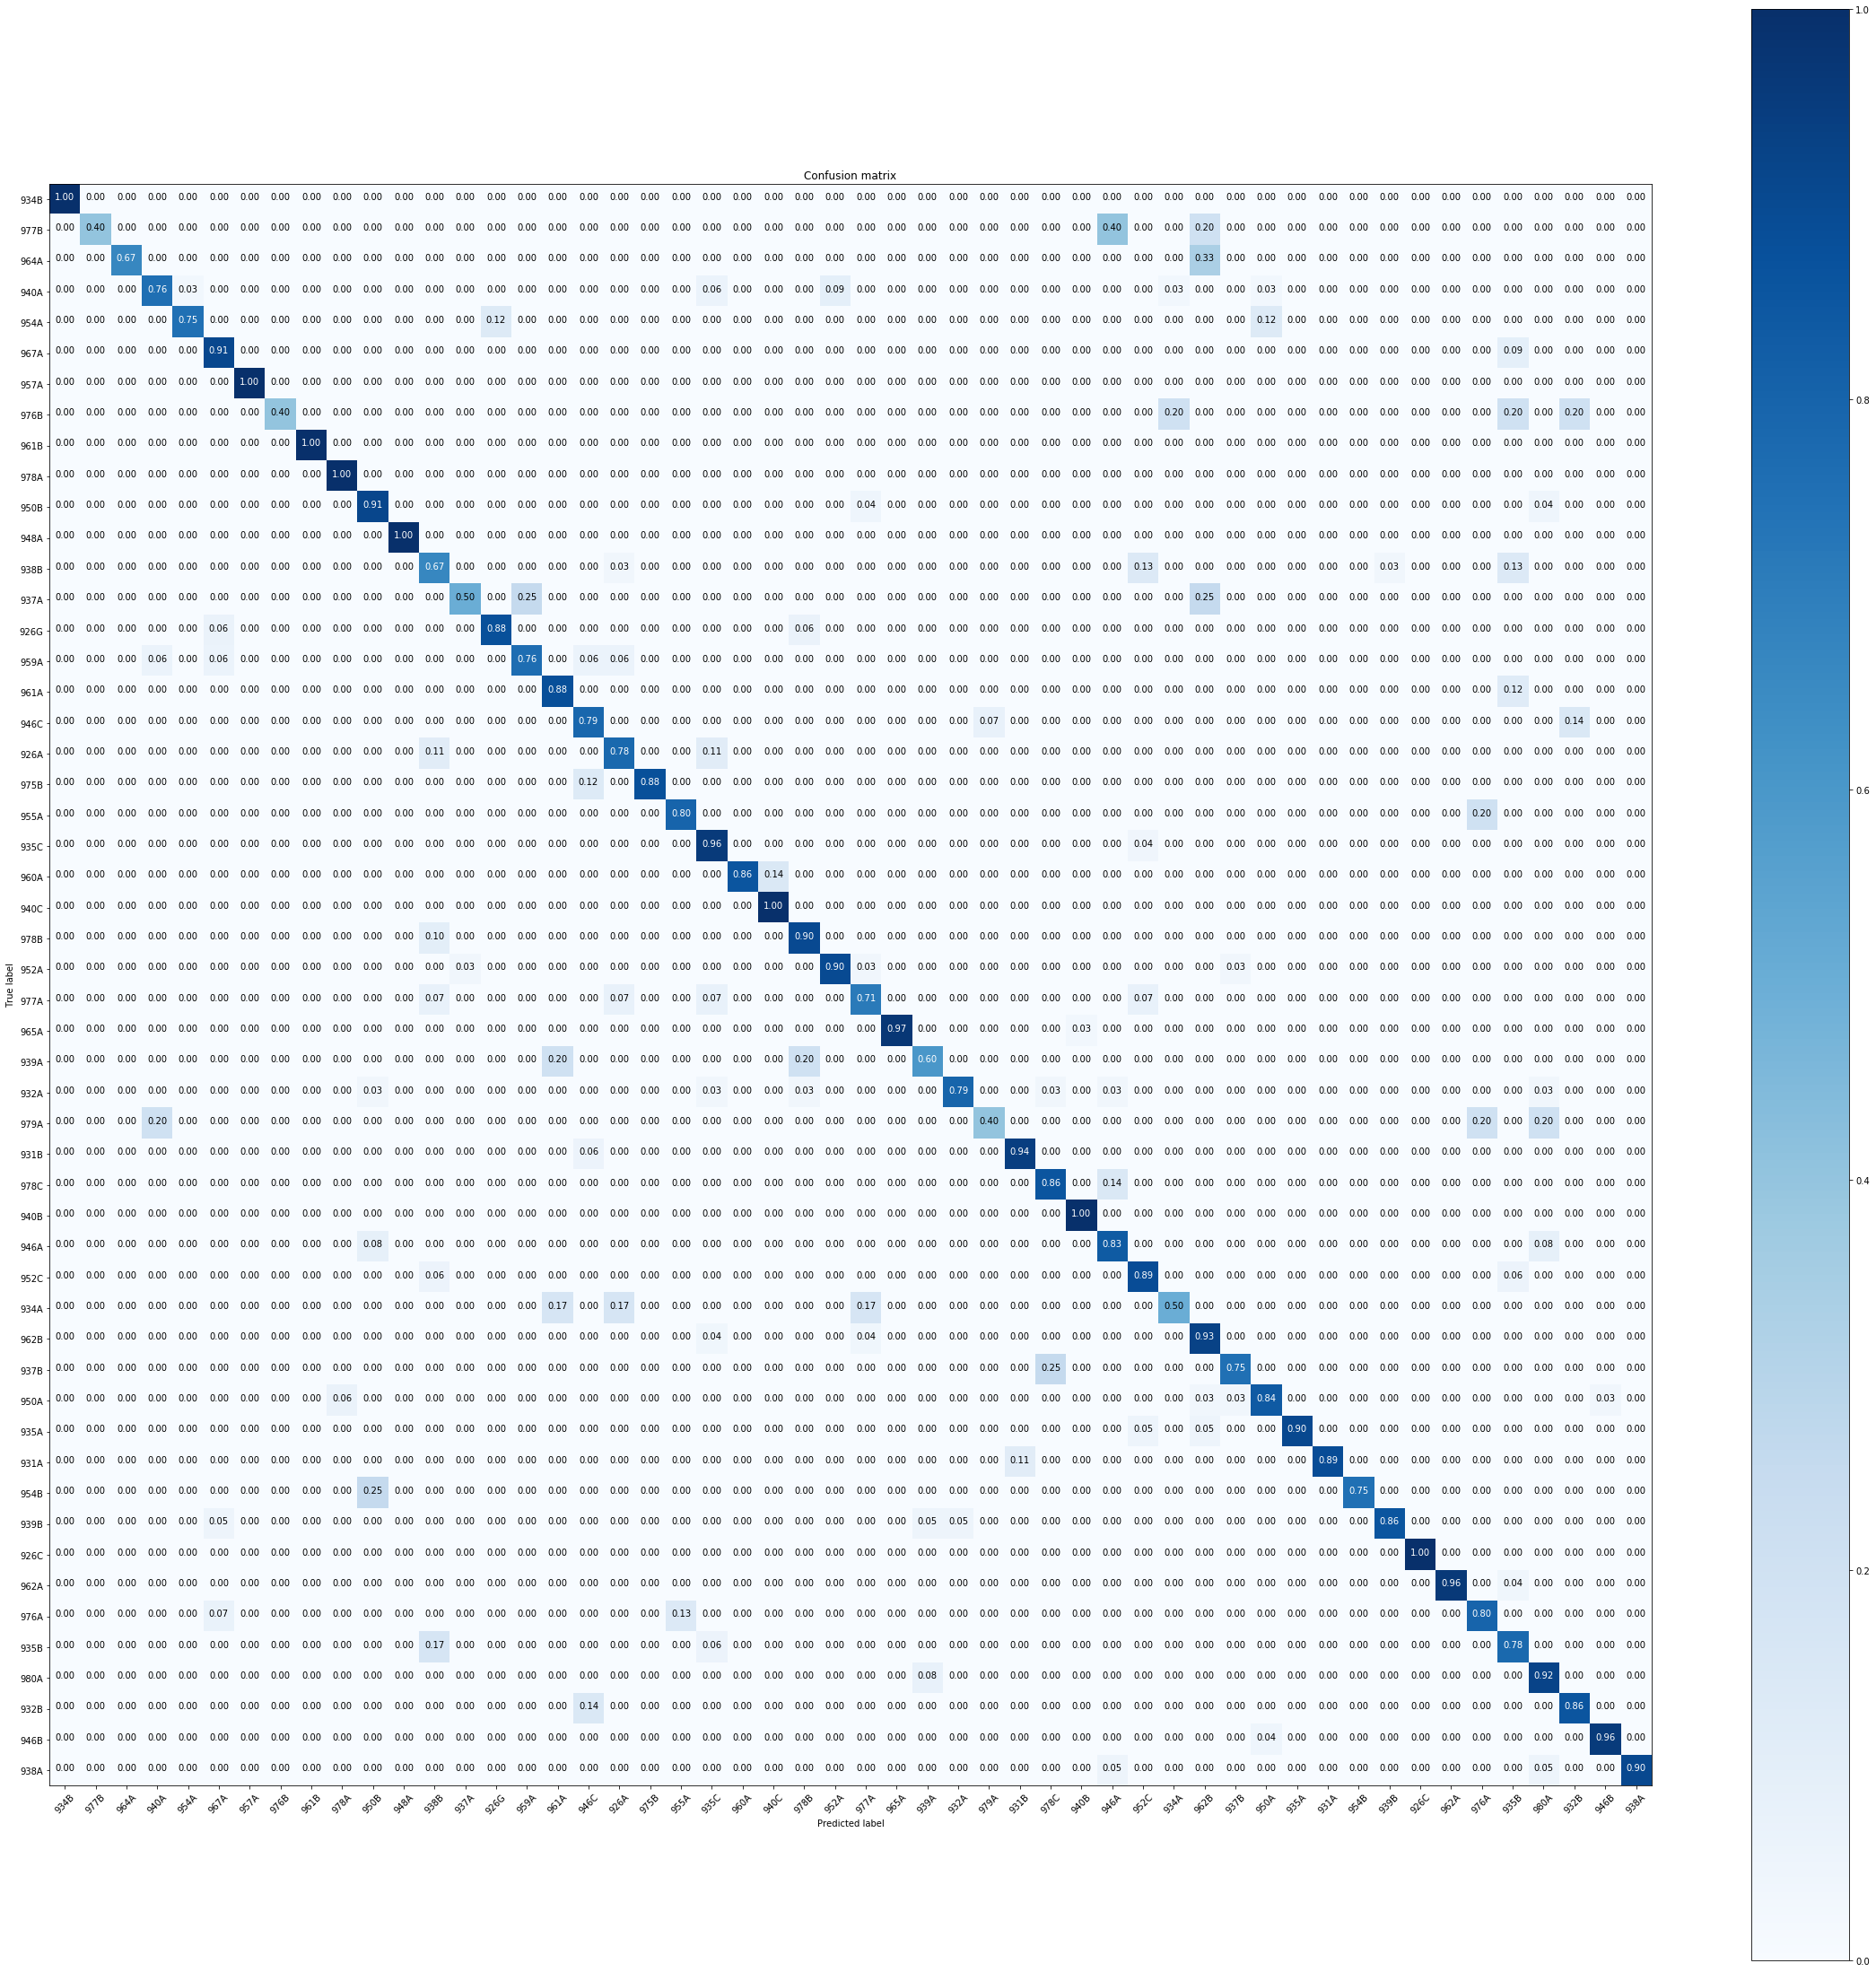

In [1118]:
plot_confusion_matrix(metrics.confusion_matrix(y_validate_posix, svm_y_pred_posix),set(svm_y_pred_posix),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_posix, dt_y_pred_posix),set(dt_y_pred_posix),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_posix, rf_y_pred_posix),set(rf_y_pred_posix),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_posix, nn_y_pred_posix),set(nn_y_pred_posix),normalize=True)

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.4        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.71428571 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.9047619 ]]
Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.6        0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.91304348 0.        ]
 [0.         0.         0.         ... 0.         0.         0.80952381]]
Normalized confusion matrix
[[1.         0.         0.  

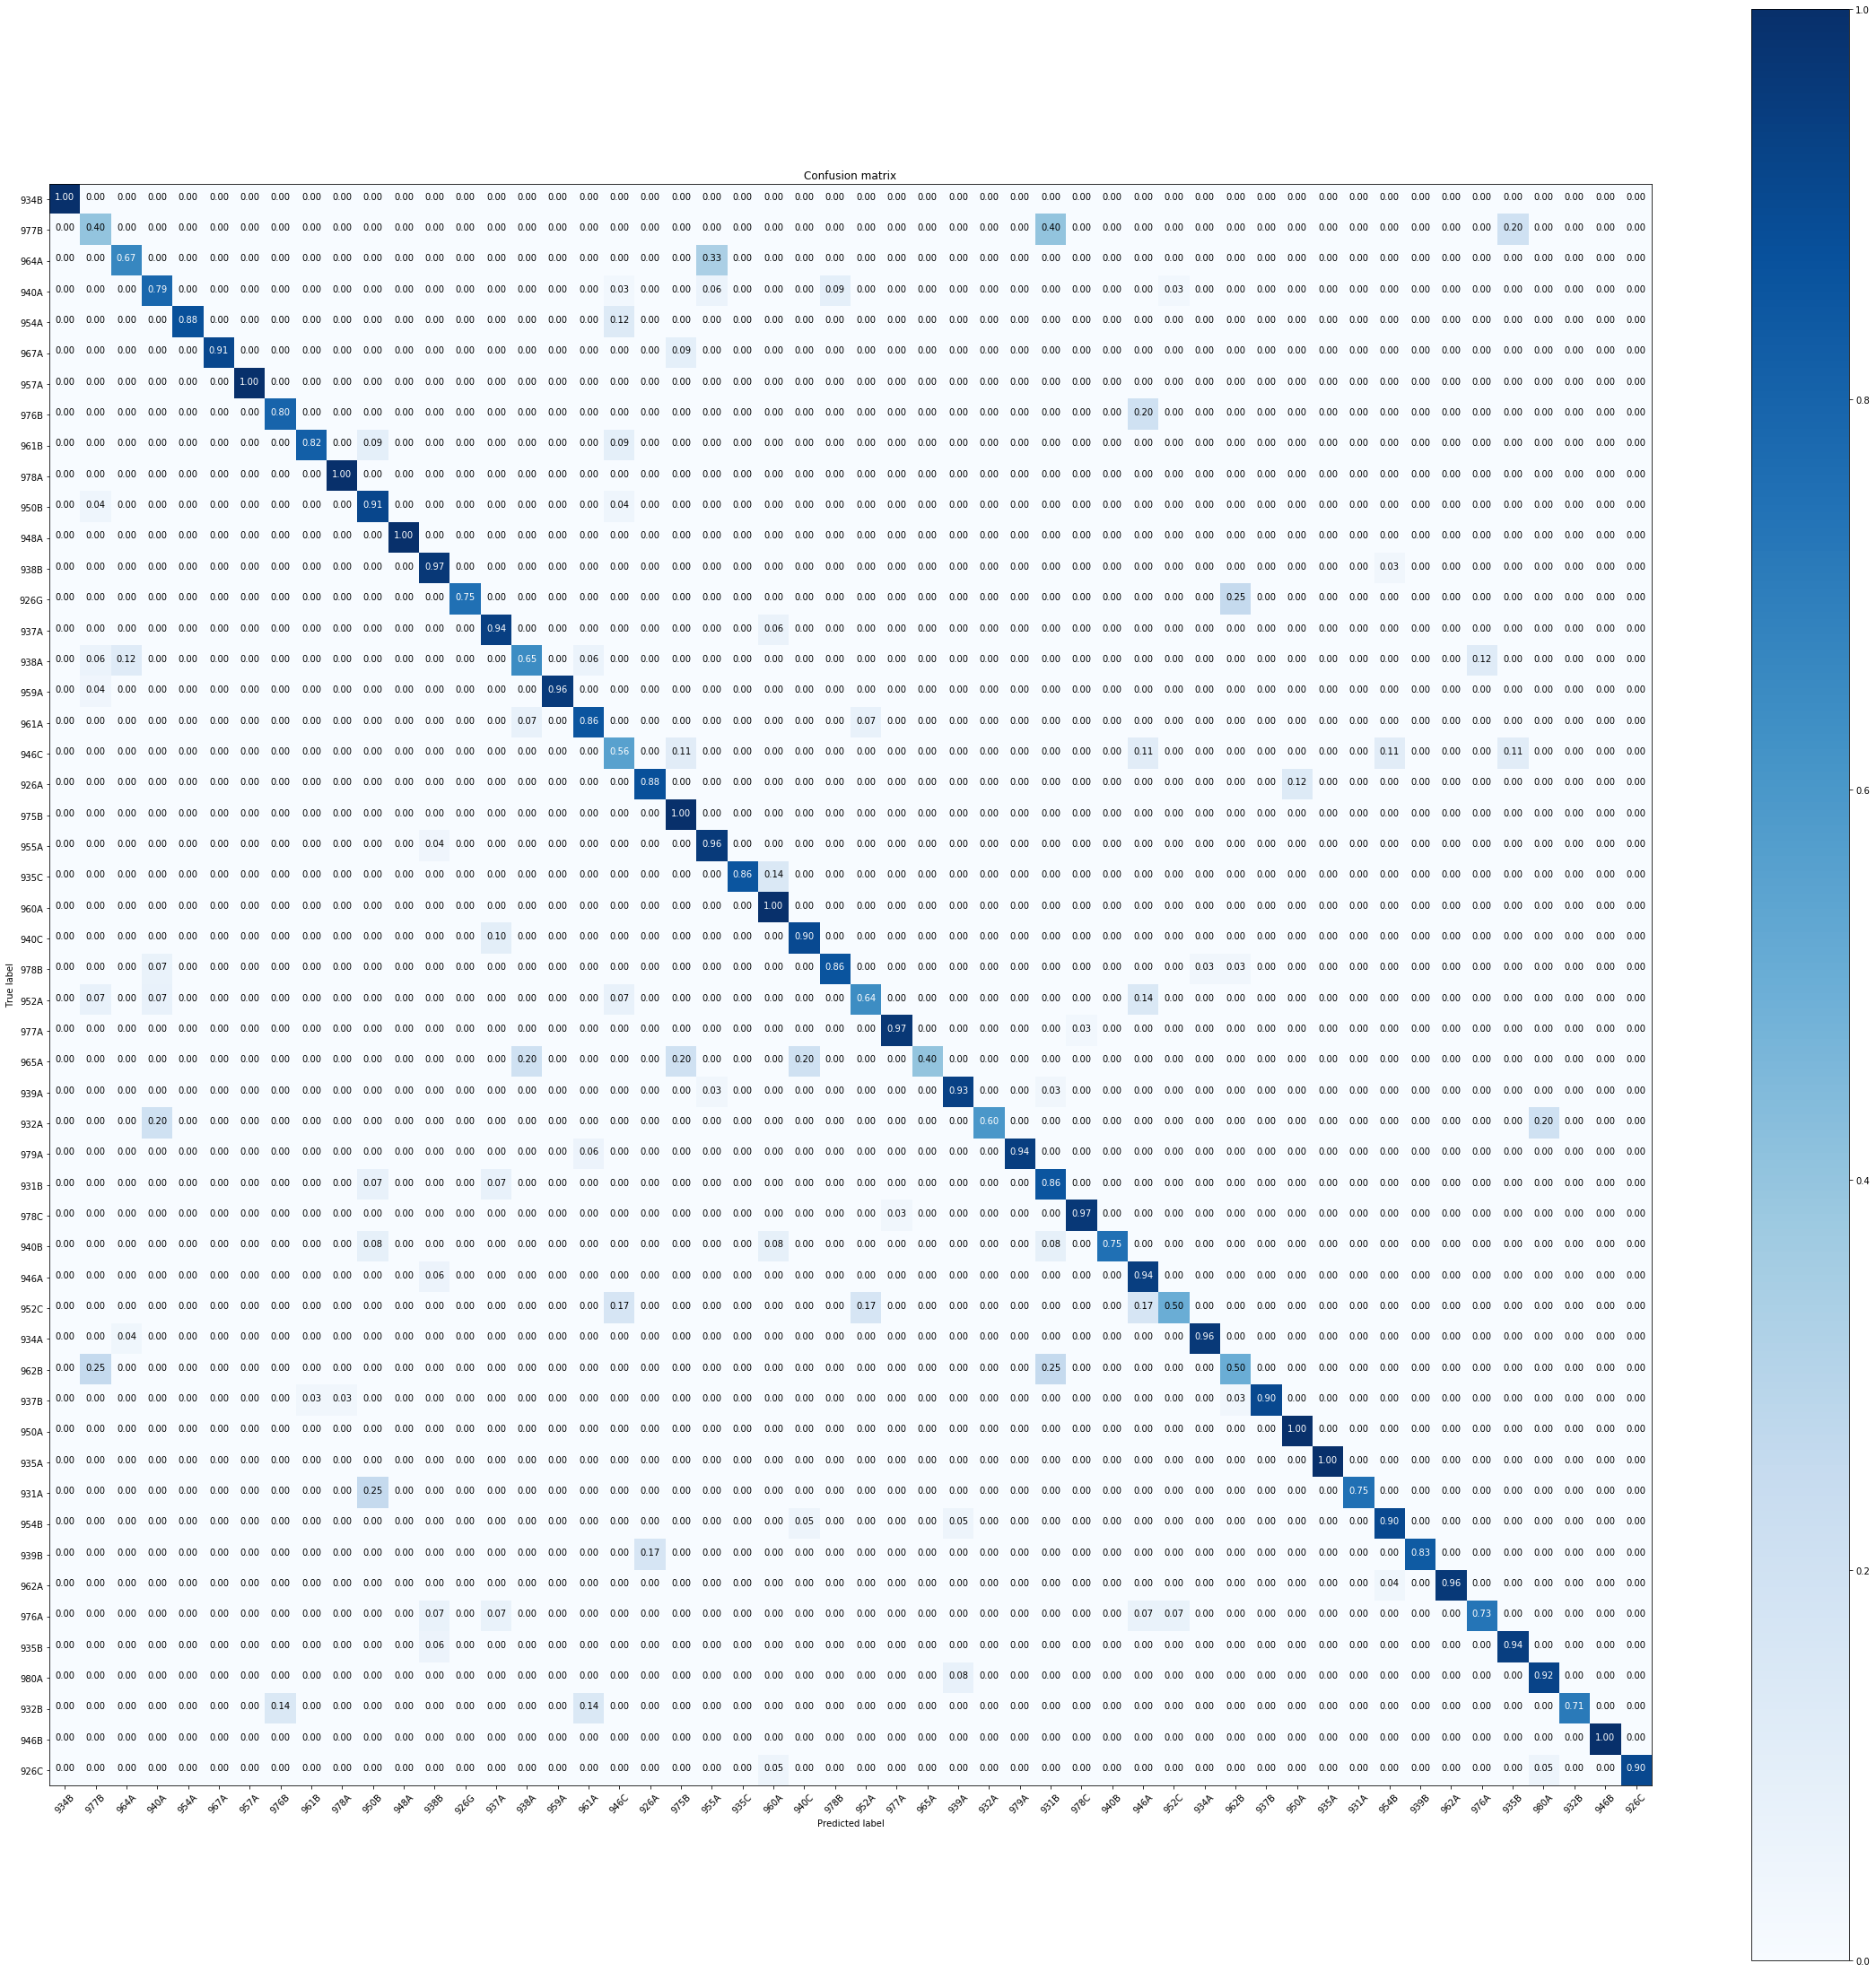

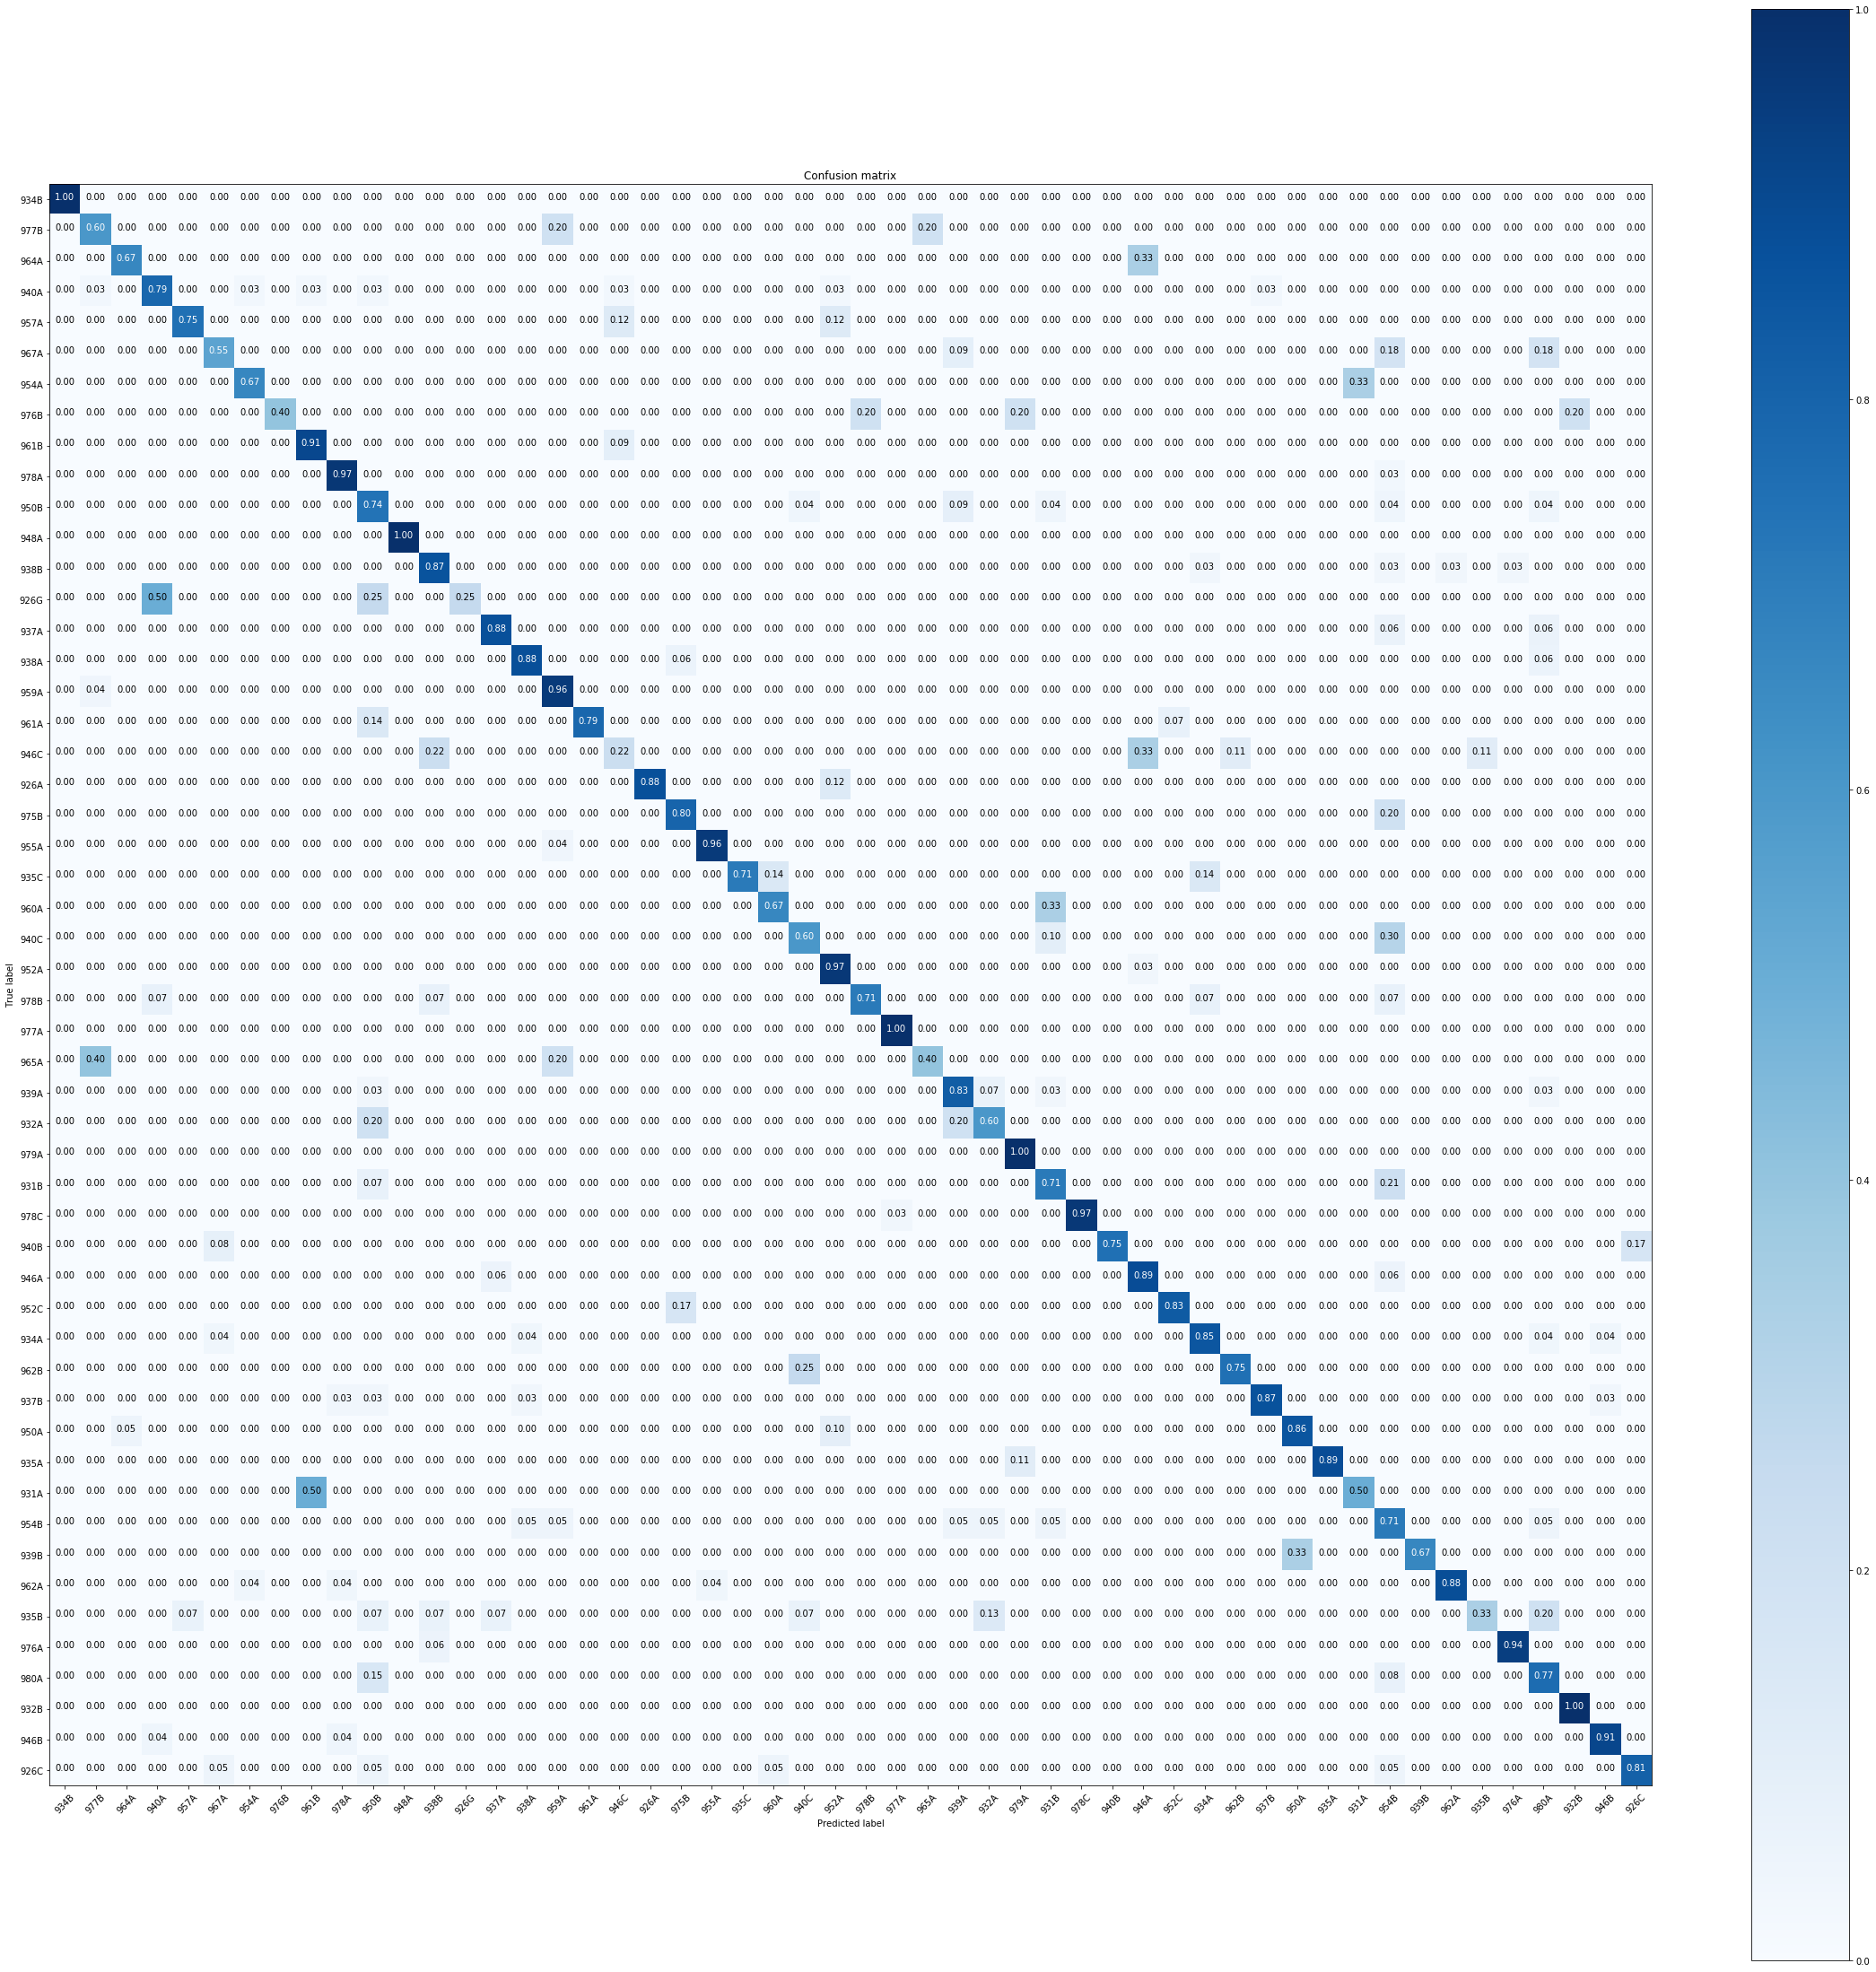

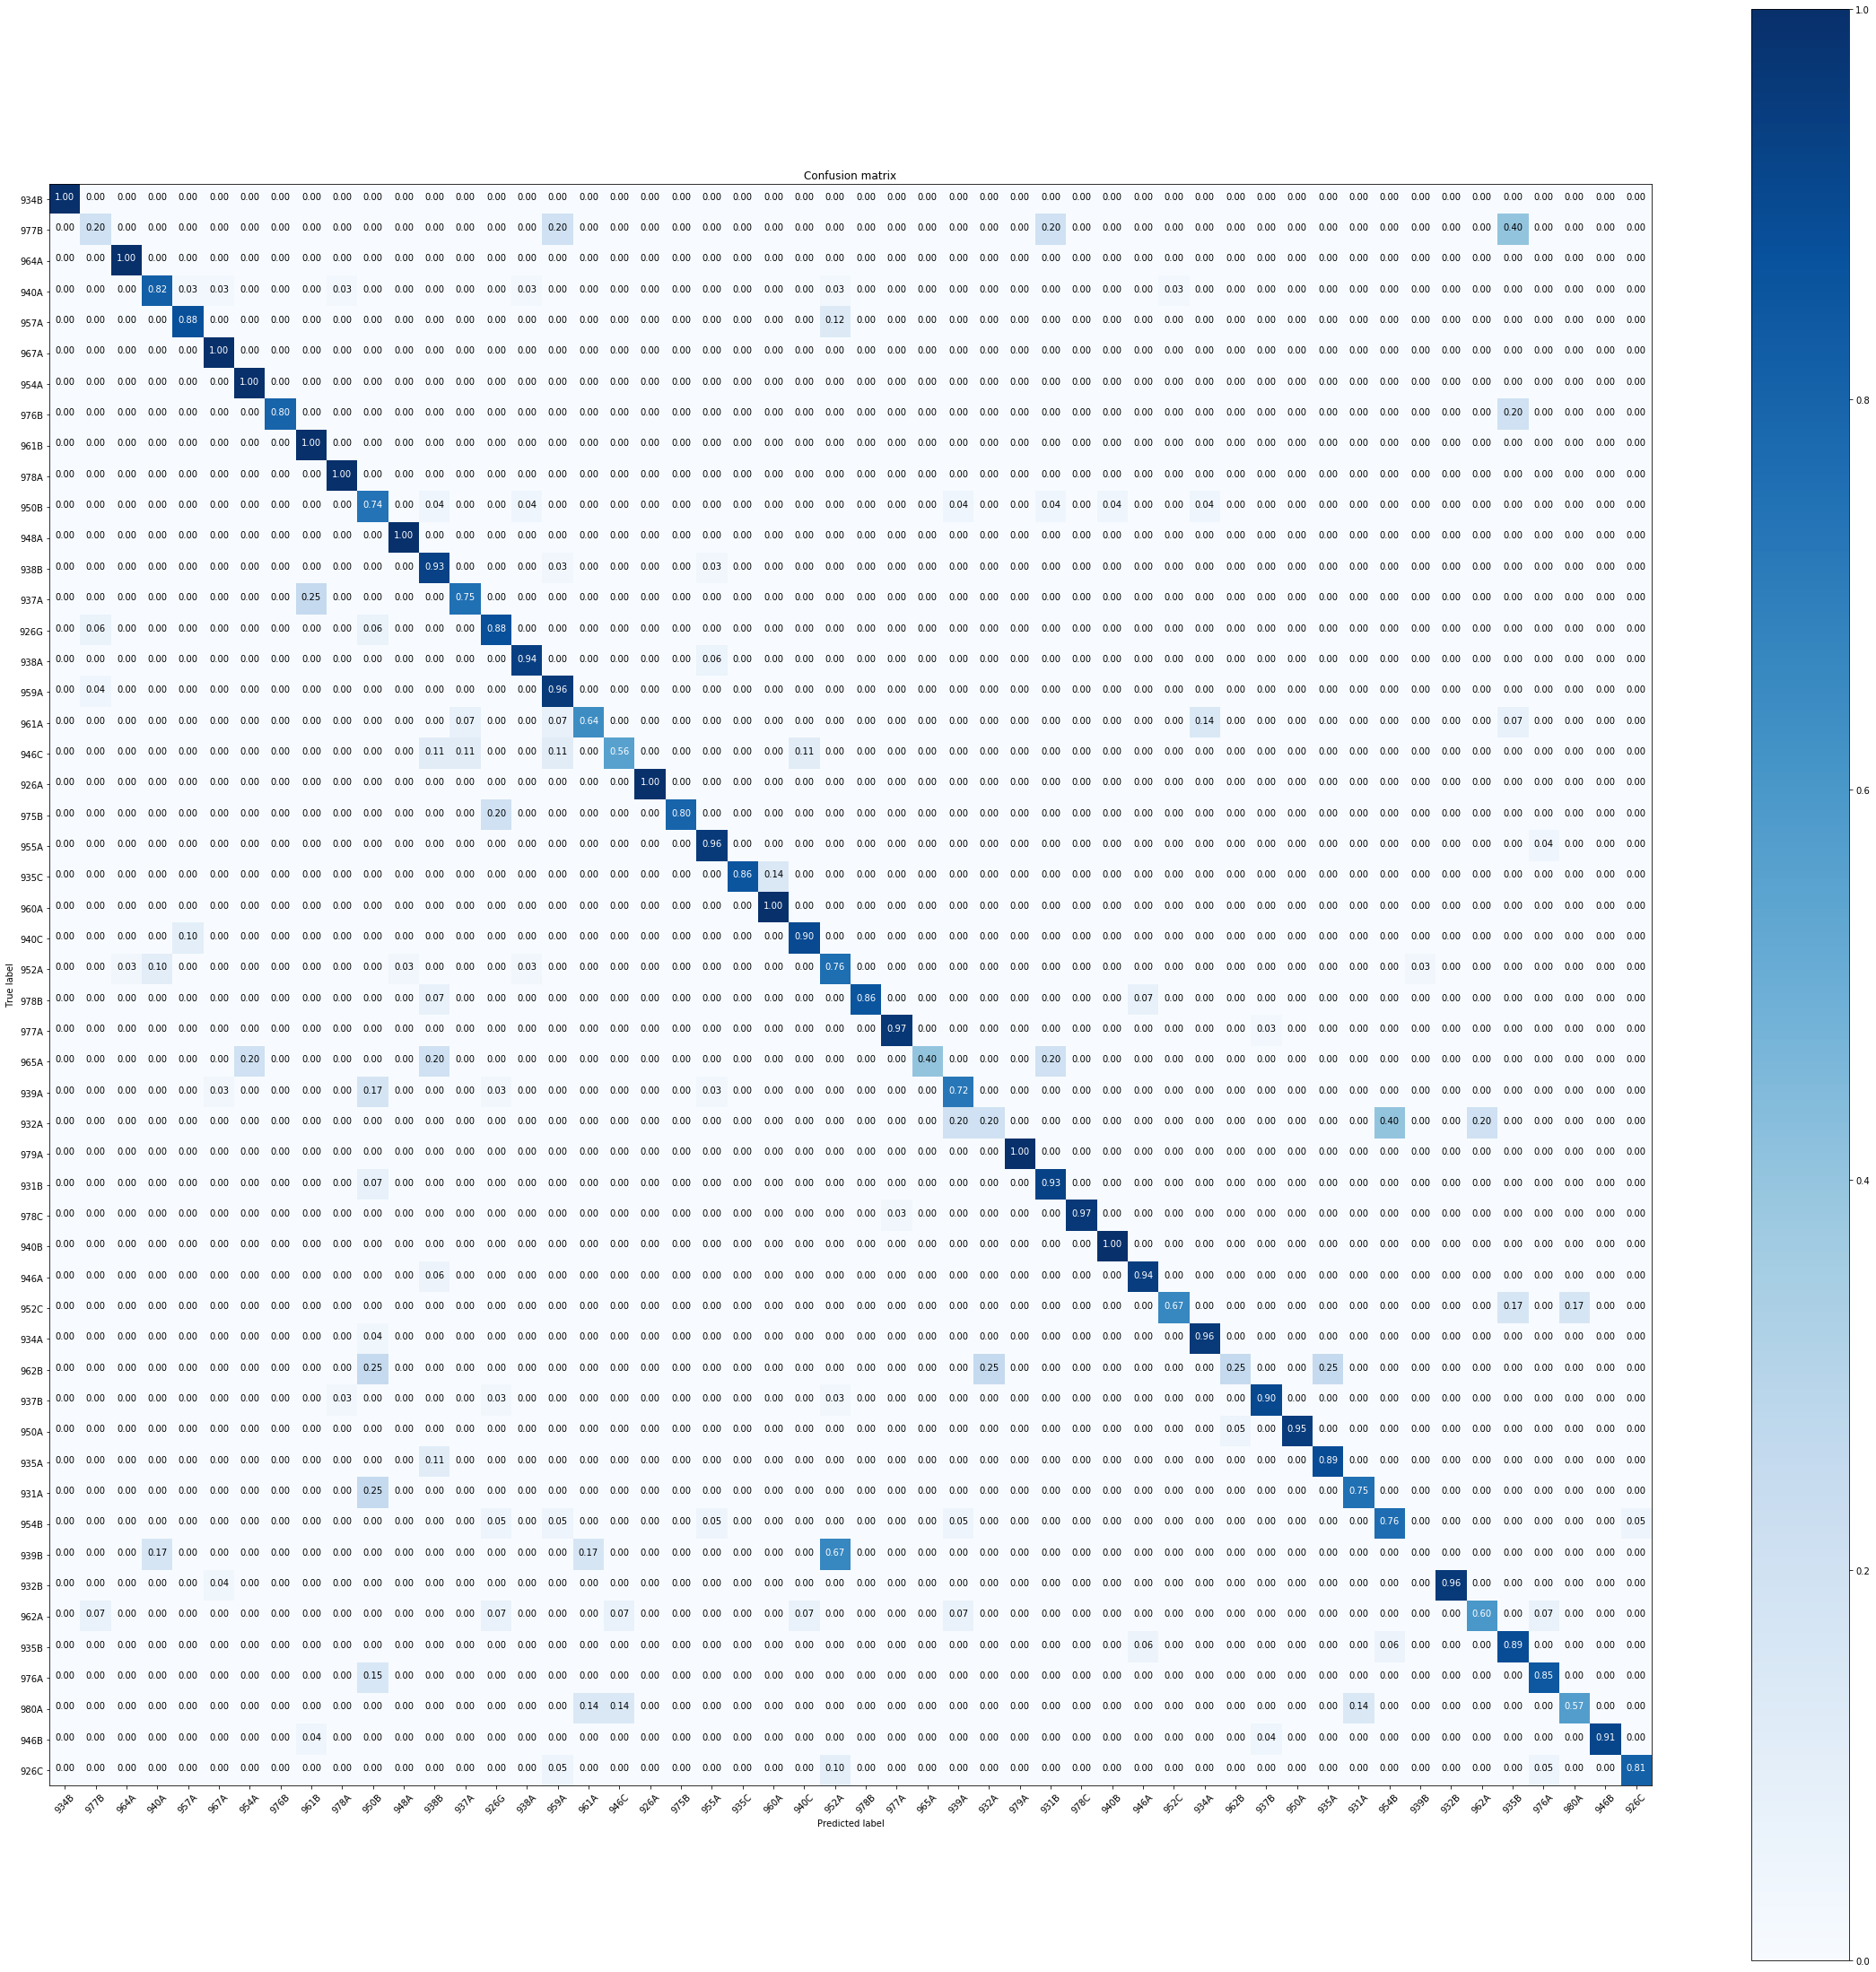

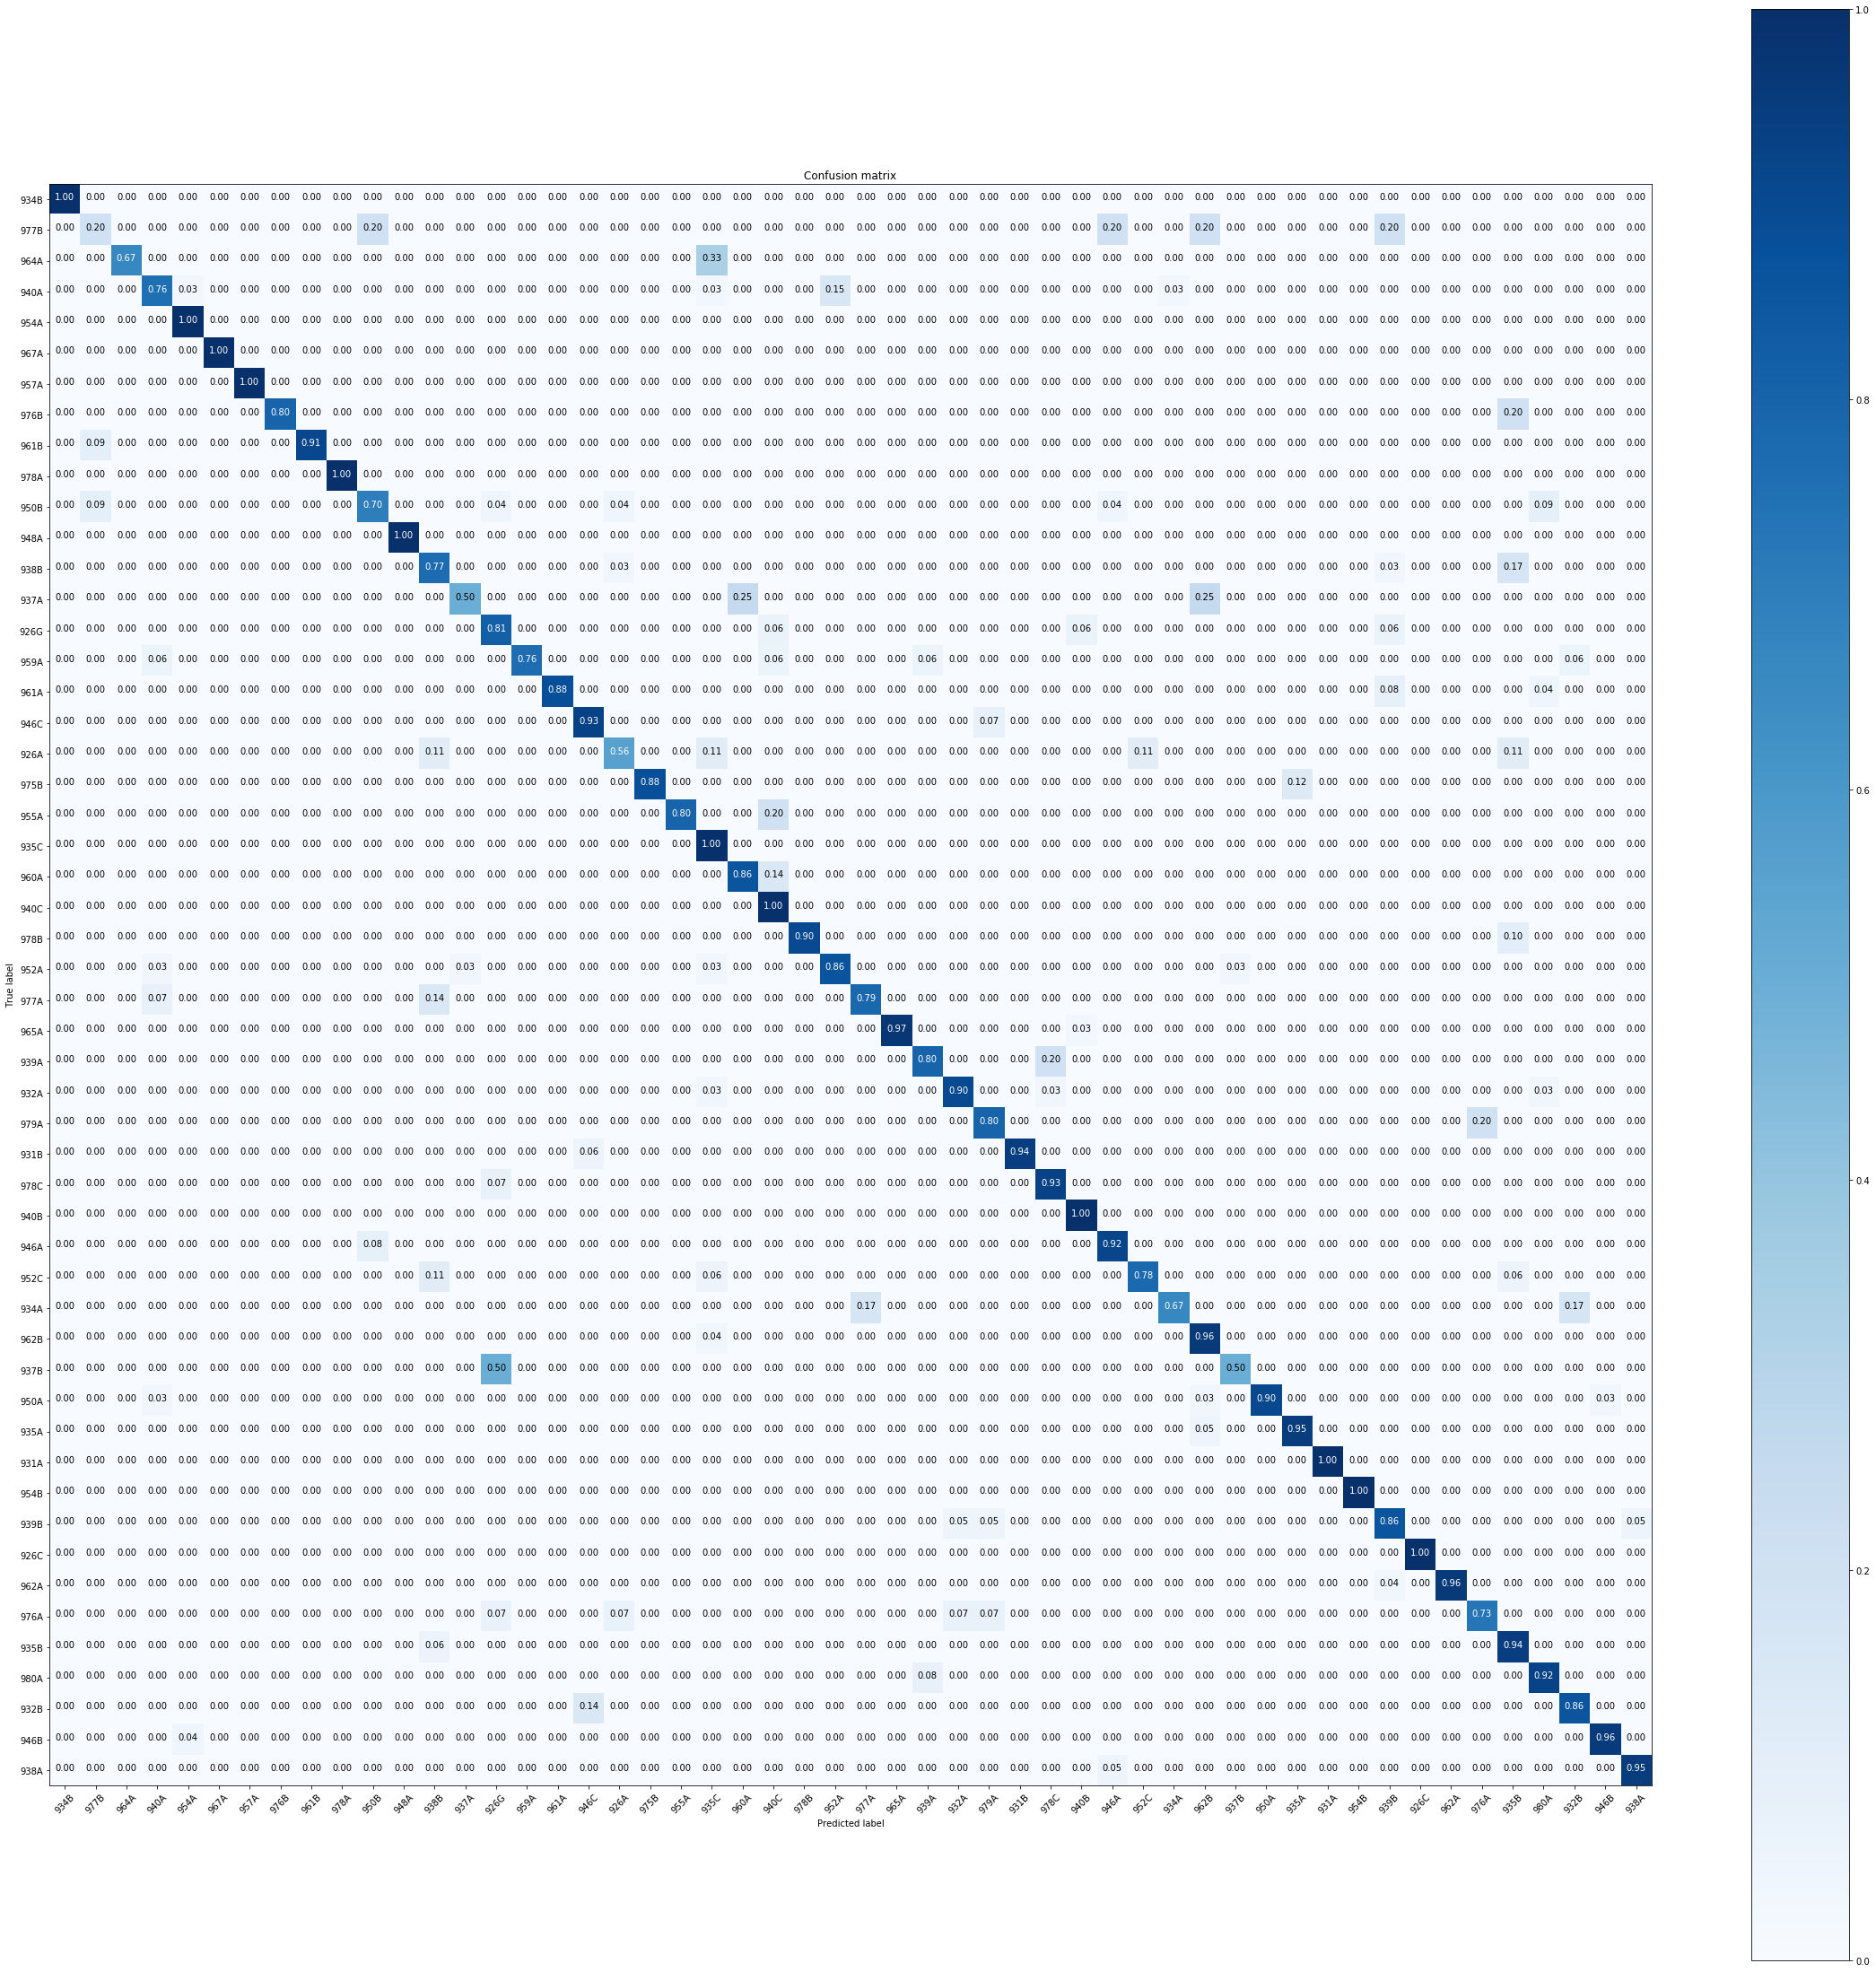

In [1119]:
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op_funct, svm_y_pred_op_funct),set(svm_y_pred_op_funct),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op_funct, dt_y_pred_op_funct),set(dt_y_pred_op_funct),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op_funct, rf_y_pred_op_funct),set(rf_y_pred_op_funct),normalize=True)
plot_confusion_matrix(metrics.confusion_matrix(y_validate_op_funct, nn_y_pred_op_funct),set(nn_y_pred_op_funct),normalize=True)